## Retina Net
object detection in Aerial Images is challengin and intersting problem It will be very useful to have models that can extract valuable information from Geo data. Retina Net is the most **famous single stage detector**

## Retina Net
 
RetinaNet is a single stage detector that uses Feature Pyramid Network (FPN) and Focal loss for training.
RetinaNetis a state-of-the-art detector presented by Lin, Goyal et al. in2017. In order to understand what RetinaNet is and does we
can decompose this nework in 3 parts:
<p>a) A backbone network built on top of ResNet called ”Feature
Pyramid Net” and is what computes the convolutional feature
maps of an entire image.</p>
<p>b) A subnetwork that uses the backbone’s output to perform
the object classification.</p>
<p>c) A subnetwork that uses the backbone’s output and is
responsible for performing the bounding box.</p>

![alt text](images/retina.png "Title")

Feature pyramid network is a structure for multiscale object detectiont combines low-resolution, semantically strong features with high-resolution, semantically weak features via a top-down pathway and lateral connections. The net result is that it produces feature maps of different scale on multiple levels in the network which helps with both classifier and regressor networks.

The Focal Loss is designed to address the single-stage object detection problems with the imbalance where there is a very large number of possible background classes and just a few foreground classes. Easily classified negatives comprise the majority of the loss and dominate the gradient. While alpha balances the importance of positive/negative examples, it does not differentiate between easy/hard examples. So the authors have reshaped the cross entropy function and come up with focal loss as mentioned below
\begin{equation}
F L(p t)=-\left(1-p_{t}\right)^{Y} * \alpha_{t} * \log (p t)
\end{equation}

<p>Here gamma is called the focusing param and alpha is called the balancing param.</p>
gamma =2 and alpha =0.25 works best and in general alpha should be decreased slightly as gamma is increased.

## Downloding the repo for the retinanet

In [1]:
#!git clone https://github.com/fizyr/keras-retinanet.git


In [2]:
# change to keras-retina dir

In [3]:
#%cd keras-retinanet/



In [4]:
# to install all the required content 
#!pip install . --user

In [5]:
#!python setup.py build_ext --inplace

## Making the dataset

We start by creating annotations for the training and validation dataset, using the tool **LabelImg**. This excellent annotation tool let you quickly annotate the bounding boxes of the objects to train the machine learning model.
https://github.com/tzutalin/labelImg
![alt text](images/labelimg.png "Title")



## Annotations format

The CSV file with annotations should contain one annotation per line. Images with multiple bounding boxes should use one row per bounding box. Note that indexing for pixel values starts at 0. The expected format of each line is:

**path/to/image.jpg,x1,y1,x2,y2,class_name**



In [1]:
# import the required package

import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas as pd

### creating an annotation for training the model

In [3]:

ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

annotations = []
classes = set([])
DATASET_DIR="/home/bhuwan/Desktop/video/helsinkicity/"
for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [3]:

df=pd.read_csv("/home/bhuwan/Desktop/video/annotations.csv")
df.head()


/home/bhuwan/Desktop/video/helsinkicity/image301.jpg  2298  1407  2367  \
0  /home/bhuwan/Desktop/video/helsinkicity/image3...    2365   911  2434   
1  /home/bhuwan/Desktop/video/helsinkicity/image3...    2349  1166  2418   
2  /home/bhuwan/Desktop/video/helsinkicity/image3...    2275   929  2344   
3  /home/bhuwan/Desktop/video/helsinkicity/image3...    2642   518  2711   
4  /home/bhuwan/Desktop/video/helsinkicity/image3...    2609   645  2678   

   1481  person  
0   985  person  
1  1240  person  
2  1003  person  
3   592  person  
4   719  person

# Debugging

Creating your own dataset does not always work out of the box. There is a **debug.py** tool to help find the most common mistakes.

Particularly helpful is the --annotations flag which displays your annotations on the images from your dataset. Annotations are colored in green when there are anchors available and colored in red when there are no anchors available. If an annotation doesn't have anchors available, it means it won't contribute to training. It is normal for a small amount of annotations to show up in red, but if most or all annotations are red there is cause for concern. The most common issues are that the annotations are too small or too oddly shaped (stretched out).


In [6]:
! python keras-retinanet/keras_retinanet/bin/debug.py --config config.ini --display-name --random-transform --annotations csv annotations.csv  classes.csv  

Using TensorFlow backend.
^C


## Anchor Boxes and optimization 

Anchor boxes were first introduced in Faster RCNN paper and later became a common element in all the following papers like yolov2, ssd and RetinaNet. Previously selective search and edge boxes used to generate region proposals of various sizes and shapes depending on the objects in the image, with standard convolutions it is highly impossible to generate region proposals of varied shapes, so anchor boxes comes to our rescue.


In [5]:
!python /home/bhuwan/Desktop/retina-net/anchor-optimization-master/optimize_anchors.py "/home/bhuwan/Desktop/video/annotations.csv" --ratios=5 --no-resize 

Using TensorFlow backend.
Loading object dimensions.
Optimising anchors.
Current best anchor configuration
Ratios: [0.297, 0.316, 1.0, 3.164, 3.371]
Scales: [0.458, 1.246, 1.307]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.27, 0.301, 1.0, 3.327, 3.704]
Scales: [0.671, 0.998, 1.833]
Number of labels that don't have any matching anchor: 13

Current best anchor configuration
Ratios: [0.45, 0.457, 1.0, 2.19, 2.222]
Scales: [0.581, 1.039, 1.824]
Number of labels that don't have any matching anchor: 3

Current best anchor configuration
Ratios: [0.559, 0.642, 1.0, 1.559, 1.788]
Scales: [0.469, 1.566, 1.928]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.362, 0.719, 1.0, 1.391, 2.765]
Scales: [0.77, 1.203, 1.926]
Number of labels that don't have any matching anchor: 29

Current best anchor configuration
Ratios: [0.558, 0.943, 1.0, 1.06, 1.791]
Scales: [0.735, 0.945, 1.204]
Number of

Current best anchor configuration
Ratios: [0.505, 0.75, 1.0, 1.334, 1.98]
Scales: [0.42, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.505, 0.75, 1.0, 1.334, 1.98]
Scales: [0.42, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.505, 0.749, 1.0, 1.335, 1.98]
Scales: [0.421, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.505, 0.749, 1.0, 1.335, 1.98]
Scales: [0.421, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.505, 0.749, 1.0, 1.335, 1.979]
Scales: [0.421, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configuration
Ratios: [0.505, 0.749, 1.0, 1.335, 1.979]
Scales: [0.421, 0.527, 0.677]
Number of labels that don't have any matching anchor: 0

Current best anchor configurat

In [ ]:
#! python keras_retinanet/bin/train.py  --batch-size 8 --steps 1000 --epochs 100 --snapshot-path snapshot/ --tensorboard-dir logs/ csv annotations.csv classes.csv

In [2]:

!python keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone   --weights keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5 --batch-size 4 --steps 85 --epochs 150 --config config.ini   csv annotations.csv classes.csv

Using TensorFlow backend.
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhuwan/anaconda3/

tracking <tf.Variable 'Variable:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(15, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
________________________




Epoch 1/150
2020-01-18 18:12:33.576670: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudnn.so.7
85/85 [==============================] - 90s 1s/step - loss: 3.8848 - regression_loss: 2.8046 - classification_loss: 1.0801

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5

Epoch 2/150
85/85 [==============================] - 86s 1s/step - loss: 3.3537 - regression_loss: 2.6196 - classification_loss: 0.7341

Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
Epoch 3/150
85/85 [==============================] - 90s 1s/step - loss: 3.0875 - regression_loss: 2.5227 - classification_loss: 0.5648

Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
Epoch 4/150
85/85 [==============================] - 89s 1s/step - loss: 2.8755 - regression_loss: 2.3540 - classification_loss: 0.5215

Epoch 00004: saving model to ./snapshots/resnet50_csv_04.h5
Epoch 5/150
85/85 [==============================] - 90s 1s/step -

85/85 [==============================] - 88s 1s/step - loss: 2.3385 - regression_loss: 1.9203 - classification_loss: 0.4183

Epoch 00035: saving model to ./snapshots/resnet50_csv_35.h5
Epoch 36/150
85/85 [==============================] - 88s 1s/step - loss: 2.3655 - regression_loss: 1.9441 - classification_loss: 0.4214

Epoch 00036: saving model to ./snapshots/resnet50_csv_36.h5

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
Epoch 37/150
85/85 [==============================] - 89s 1s/step - loss: 2.3372 - regression_loss: 1.9188 - classification_loss: 0.4184

Epoch 00037: saving model to ./snapshots/resnet50_csv_37.h5
Epoch 38/150
85/85 [==============================] - 89s 1s/step - loss: 2.3476 - regression_loss: 1.9283 - classification_loss: 0.4193

Epoch 00038: saving model to ./snapshots/resnet50_csv_38.h5

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.
Epoch 39/150
85/85 [==============================] - 90s 1s/

Epoch 70/150
85/85 [==============================] - 88s 1s/step - loss: 2.3272 - regression_loss: 1.9113 - classification_loss: 0.4159

Epoch 00070: saving model to ./snapshots/resnet50_csv_70.h5

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.0000000272452012e-28.
Epoch 71/150
85/85 [==============================] - 88s 1s/step - loss: 2.3736 - regression_loss: 1.9485 - classification_loss: 0.4251

Epoch 00071: saving model to ./snapshots/resnet50_csv_71.h5
Epoch 72/150
85/85 [==============================] - 89s 1s/step - loss: 2.3259 - regression_loss: 1.9060 - classification_loss: 0.4199

Epoch 00072: saving model to ./snapshots/resnet50_csv_72.h5

Epoch 00072: ReduceLROnPlateau reducing learning rate to 1.0000000031710769e-29.
Epoch 73/150
85/85 [==============================] - 89s 1s/step - loss: 2.3539 - regression_loss: 1.9342 - classification_loss: 0.4197

Epoch 00073: saving model to ./snapshots/resnet50_csv_73.h5
Epoch 74/150
85/85 [========================

In [10]:
! python keras-retinanet/keras_retinanet/bin/train.py  --batch-size 8 --steps 100 --epochs 150  --weights keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5  --config config.ini csv annotations.csv classes.csv 
#--val-annotations
#val_annotations.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-01-18 08:51:28.041287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-18 08:51:28.078101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-18 08:51:28.078468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.65
pciBusID: 0000:01:00.0
2020-01-18 08:51:28.080069: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-01-18 08:51:28.106156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-01-18 08:51:28.118461: I tensorflow/stream_executor/platform/

tracking <tf.Variable 'Variable:0' shape=(15, 4) dtype=float32, numpy=
array([[-18.9127   ,  -9.550914 ,  18.9127   ,   9.550914 ],
       [-23.730938 , -11.984124 ,  23.730938 ,  11.984124 ],
       [-30.485474 , -15.3951645,  30.485474 ,  15.3951645],
       [-15.539908 , -11.623852 ,  15.539908 ,  11.623852 ],
       [-19.498886 , -14.585167 ,  19.498886 ,  14.585167 ],
       [-25.048853 , -18.736542 ,  25.048853 ,  18.736542 ],
       [-13.44     , -13.44     ,  13.44     ,  13.44     ],
       [-16.864    , -16.864    ,  16.864    ,  16.864    ],
       [-21.664    , -21.664    ,  21.664    ,  21.664    ],
       [-11.619065 , -15.546309 ,  11.619065 ,  15.546309 ],
       [-14.579161 , -19.506918 ,  14.579161 ,  19.506918 ],
       [-18.728827 , -25.059172 ,  18.728827 ,  25.059172 ],
       [ -9.553804 , -18.906979 ,   9.553804 ,  18.906979 ],
       [-11.987751 , -23.723759 ,  11.987751 ,  23.723759 ],
       [-15.399823 , -30.47625  ,  15.399823 ,  30.47625  ]],
      dtype=f

Epoch 1/150
2020-01-18 08:51:42.679301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-01-18 08:51:45.169564: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-01-18 08:51:45.169592: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-01-18 08:51:45.218392: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean tha

Epoch 23/150
100/100 [==============================] - 207s 2s/step - loss: 1.9112 - regression_loss: 1.5717 - classification_loss: 0.3396

Epoch 00023: saving model to ./snapshots/resnet50_csv_23.h5
Epoch 24/150
100/100 [==============================] - 207s 2s/step - loss: 1.9044 - regression_loss: 1.5594 - classification_loss: 0.3450

Epoch 00024: saving model to ./snapshots/resnet50_csv_24.h5
Epoch 25/150
100/100 [==============================] - 207s 2s/step - loss: 1.8485 - regression_loss: 1.5145 - classification_loss: 0.3340

Epoch 00025: saving model to ./snapshots/resnet50_csv_25.h5
Epoch 26/150
100/100 [==============================] - 206s 2s/step - loss: 1.8228 - regression_loss: 1.4912 - classification_loss: 0.3316

Epoch 00026: saving model to ./snapshots/resnet50_csv_26.h5
Epoch 27/150
100/100 [==============================] - 206s 2s/step - loss: 1.7936 - regression_loss: 1.4662 - classification_loss: 0.3273

Epoch 00027: saving model to ./snapshots/resnet50_csv_2

Epoch 64/150
100/100 [==============================] - 207s 2s/step - loss: 1.1141 - regression_loss: 0.8682 - classification_loss: 0.2459

Epoch 00064: saving model to ./snapshots/resnet50_csv_64.h5

Epoch 00064: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 65/150
100/100 [==============================] - 206s 2s/step - loss: 1.0270 - regression_loss: 0.7873 - classification_loss: 0.2398

Epoch 00065: saving model to ./snapshots/resnet50_csv_65.h5
Epoch 66/150
100/100 [==============================] - 207s 2s/step - loss: 1.0221 - regression_loss: 0.7810 - classification_loss: 0.2412

Epoch 00066: saving model to ./snapshots/resnet50_csv_66.h5
Epoch 67/150
100/100 [==============================] - 207s 2s/step - loss: 1.0110 - regression_loss: 0.7731 - classification_loss: 0.2379

Epoch 00067: saving model to ./snapshots/resnet50_csv_67.h5
Epoch 68/150
100/100 [==============================] - 207s 2s/step - loss: 1.0040 - regression_loss: 0.7652 - cla

2020-01-18 13:22:56.080929: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (16777216): 	Total Chunks: 38, Chunks in use: 36. 996.21MiB allocated for chunks. 960.00MiB in use in bin. 918.41MiB client-requested in use in bin.
2020-01-18 13:22:56.080936: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (33554432): 	Total Chunks: 17, Chunks in use: 17. 943.50MiB allocated for chunks. 943.50MiB in use in bin. 901.41MiB client-requested in use in bin.
2020-01-18 13:22:56.080942: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (67108864): 	Total Chunks: 23, Chunks in use: 23. 2.56GiB allocated for chunks. 2.56GiB in use in bin. 2.50GiB client-requested in use in bin.
2020-01-18 13:22:56.080949: I tensorflow/core/common_runtime/bfc_allocator.cc:869] Bin (134217728): 	Total Chunks: 9, Chunks in use: 9. 1.89GiB allocated for chunks. 1.89GiB in use in bin. 1.24GiB client-requested in use in bin.
2020-01-18 13:22:56.080955: I tensorflow/core/common_runtime/bfc_allo

In [9]:
! python keras-retinanet/keras_retinanet/bin/evaluate.py csv  annotations.csv classes.csv model.h5

Using TensorFlow backend.
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhuwan/anaconda3/

2020-01-19 17:07:24.964314: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.0KiB (rounded to 65536).  Current allocation summary follows.
2020-01-19 17:07:24.964338: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:07:24.964343: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:07:24.964347: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:07:24.964351: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 2.

2020-01-19 17:07:34.964888: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.0KiB (rounded to 65536).  Current allocation summary follows.
2020-01-19 17:07:34.964909: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:07:34.964913: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:07:34.964916: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:07:34.964919: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 2.

2020-01-19 17:07:44.965398: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.0KiB (rounded to 65536).  Current allocation summary follows.
2020-01-19 17:07:44.965473: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:07:44.965504: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:07:44.965538: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:07:44.965576: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 2.

2020-01-19 17:07:44.967226: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e820a100 next 18446744073709551615 of size 33578752
2020-01-19 17:07:44.967256: I tensorflow/core/common_runtime/bfc_allocator.cc:809]      Summary of in-use Chunks by size: 
2020-01-19 17:07:44.967295: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 32 Chunks of size 256 totalling 8.0KiB
2020-01-19 17:07:44.967330: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 2 Chunks of size 512 totalling 1.0KiB
2020-01-19 17:07:44.967352: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 2 Chunks of size 1024 totalling 2.0KiB
2020-01-19 17:07:44.967370: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 1 Chunks of size 1280 totalling 1.2KiB
2020-01-19 17:07:44.967389: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 2 Chunks of size 2048 totalling 4.0KiB
2020-01-19 17:07:44.967408: I tensorflow/core/common_runtime/bfc_allocator.cc:812] 2 Chunks of size 4096 totalling 8.0

2020-01-19 17:08:04.968464: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.0KiB (rounded to 589824).  Current allocation summary follows.
2020-01-19 17:08:04.968549: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:04.968595: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:04.968630: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:04.968663: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:08:14.970546: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.0KiB (rounded to 589824).  Current allocation summary follows.
2020-01-19 17:08:14.970625: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:14.970651: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:14.970680: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:14.970716: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:08:24.972723: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.0KiB (rounded to 589824).  Current allocation summary follows.
2020-01-19 17:08:24.972746: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:24.972751: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:24.972754: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:24.972758: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:08:34.973155: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 576.0KiB (rounded to 589824).  Current allocation summary follows.
2020-01-19 17:08:34.973175: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:34.973179: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:34.973182: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:34.973185: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:08:44.973704: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184).  Current allocation summary follows.
2020-01-19 17:08:44.973779: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:44.973810: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:44.973835: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:44.973856: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:08:54.975685: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184).  Current allocation summary follows.
2020-01-19 17:08:54.975762: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:08:54.975791: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:08:54.975814: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:08:54.975836: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:04.977663: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184).  Current allocation summary follows.
2020-01-19 17:09:04.977739: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:04.977768: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:04.977795: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:04.977818: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:14.979647: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:09:14.979723: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:14.979753: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:14.979777: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:14.979800: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:24.981666: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:09:24.981739: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:24.981769: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:24.981794: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:24.981815: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:34.983646: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:09:34.983723: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:34.983748: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:34.983781: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:34.983804: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:44.985656: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:09:44.985738: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:44.985769: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:44.985796: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:44.985819: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:09:54.987630: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:09:54.987651: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:09:54.987655: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:09:54.987658: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:09:54.987661: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:04.988036: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:10:04.988056: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:04.988060: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:04.988064: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:04.988066: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:14.988504: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.0KiB (rounded to 524288).  Current allocation summary follows.
2020-01-19 17:10:14.988538: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:14.988546: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:14.988553: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:14.988561: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:24.989326: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.0KiB (rounded to 524288).  Current allocation summary follows.
2020-01-19 17:10:24.989410: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:24.989436: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:24.989463: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:24.989486: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:34.991293: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:10:34.991373: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:34.991403: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:34.991428: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:34.991450: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:44.993318: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:10:44.993399: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:44.993432: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:44.993457: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:44.993485: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:10:54.995296: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:10:54.995371: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:10:54.995396: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:10:54.995433: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:10:54.995457: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:04.997302: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:11:04.997379: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:04.997404: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:04.997438: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:04.997460: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:14.999331: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.0KiB (rounded to 131072).  Current allocation summary follows.
2020-01-19 17:11:14.999408: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:14.999433: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:14.999457: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:14.999482: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:25.001327: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.0KiB (rounded to 147456).  Current allocation summary follows.
2020-01-19 17:11:25.001356: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:25.001363: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:25.001368: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:25.001373: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:35.001964: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.0KiB (rounded to 147456).  Current allocation summary follows.
2020-01-19 17:11:35.002044: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:35.002073: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:35.002096: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:35.002118: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:45.003984: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.0KiB (rounded to 147456).  Current allocation summary follows.
2020-01-19 17:11:45.004019: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:45.004030: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:45.004039: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:45.004047: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:11:55.004944: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:11:55.005026: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:11:55.005060: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:11:55.005086: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:11:55.005109: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:05.007583: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:12:05.007680: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:05.007726: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:05.007766: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:05.007806: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:15.010205: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:12:15.010257: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:15.010273: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:15.010286: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:15.010298: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:25.011635: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:12:25.011715: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:25.011745: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:25.011781: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:25.011820: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:35.014240: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:12:35.014269: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:35.014274: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:35.014277: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:35.014280: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:45.014724: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00MiB (rounded to 1048576).  Current allocation summary follows.
2020-01-19 17:12:45.014756: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:45.014763: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:45.014769: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:45.014774: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:12:55.015534: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.0KiB (rounded to 524288).  Current allocation summary follows.
2020-01-19 17:12:55.015615: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:12:55.015648: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:12:55.015672: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:12:55.015695: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:13:05.017552: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.0KiB (rounded to 65536).  Current allocation summary follows.
2020-01-19 17:13:05.017634: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:13:05.017665: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:13:05.017690: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:13:05.017712: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 2.

2020-01-19 17:13:05.018749: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009700 next 34 of size 256
2020-01-19 17:13:05.018767: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009800 next 35 of size 256
2020-01-19 17:13:05.018785: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009900 next 36 of size 256
2020-01-19 17:13:05.018803: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009a00 next 37 of size 256
2020-01-19 17:13:05.018820: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009b00 next 38 of size 256
2020-01-19 17:13:05.018838: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009c00 next 39 of size 256
2020-01-19 17:13:05.018856: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009d00 next 40 of size 256
2020-01-19 17:13:05.018875: I tensorflow/core/common_runtime/bfc_allocator.cc:800] InUse at 0x7fe7e8009e00 next

2020-01-19 17:13:25.021600: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 540.0KiB (rounded to 552960).  Current allocation summary follows.
2020-01-19 17:13:25.021665: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:13:25.021683: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:13:25.021700: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:13:25.021716: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:13:35.023482: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304).  Current allocation summary follows.
2020-01-19 17:13:35.023566: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:13:35.023597: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:13:35.023621: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:13:35.023651: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:13:45.025650: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304).  Current allocation summary follows.
2020-01-19 17:13:45.025711: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:13:45.025733: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:13:45.025749: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:13:45.025764: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:13:55.027178: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.00MiB (rounded to 8388608).  Current allocation summary follows.
2020-01-19 17:13:55.027262: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:13:55.027292: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:13:55.027352: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:13:55.027377: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:05.029290: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304).  Current allocation summary follows.
2020-01-19 17:14:05.029378: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:05.029410: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:05.029435: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:05.029458: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:15.031323: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304).  Current allocation summary follows.
2020-01-19 17:14:15.031403: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:15.031435: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:15.031459: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:15.031482: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:25.033328: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304).  Current allocation summary follows.
2020-01-19 17:14:25.033432: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:25.033482: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:25.033524: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:25.033566: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:35.036679: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:14:35.036762: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:35.036790: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:35.036820: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:35.036851: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:45.038626: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:14:45.038650: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:45.038657: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:45.038663: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:45.038668: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:14:55.039186: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144).  Current allocation summary follows.
2020-01-19 17:14:55.039266: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:14:55.039297: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:14:55.039321: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:14:55.039344: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:15:05.041149: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.0KiB (rounded to 16384).  Current allocation summary follows.
2020-01-19 17:15:05.041244: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:05.041294: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:05.041320: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:05.041339: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 2.

2020-01-19 17:15:15.043703: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00MiB (rounded to 2097152).  Current allocation summary follows.
2020-01-19 17:15:15.043754: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:15.043768: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:15.043780: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:15.043792: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:15:25.044865: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00MiB (rounded to 2097152).  Current allocation summary follows.
2020-01-19 17:15:25.044947: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:25.044974: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:25.045004: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:25.045026: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:15:35.047090: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:15:35.047154: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:35.047176: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:35.047193: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:35.047209: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:15:45.048609: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:15:45.048697: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:45.048734: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:45.048774: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:45.048811: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:15:55.052203: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:15:55.052283: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:15:55.052313: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:15:55.052338: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:15:55.052363: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:16:05.054236: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:16:05.054330: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:16:05.054380: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:16:05.054423: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:16:05.054463: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:16:15.057436: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:16:15.057513: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:16:15.057539: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:16:15.057564: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:16:15.057588: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:16:25.059614: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:16:25.059696: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:16:25.059722: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:16:25.059746: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:16:25.059769: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

2020-01-19 17:16:35.061646: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296).  Current allocation summary follows.
2020-01-19 17:16:35.061730: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 2.1KiB client-requested in use in bin.
2020-01-19 17:16:35.061761: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2020-01-19 17:16:35.061784: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (1024): 	Total Chunks: 3, Chunks in use: 3. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2020-01-19 17:16:35.061808: I tensorflow/core/common_runtime/bfc_allocator.cc:764] Bin (2048): 	Total Chunks: 2, Chunks in use: 

^C


In [2]:

%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time



Using TensorFlow backend.
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhuwan/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhuwan/anaconda3/

# model Inference

In [3]:
from keras_retinanet.bin.train import create_models
from keras_retinanet.models import backbone,convert_model
from keras_retinanet.utils.config import read_config_file,parse_anchor_parameters

In [4]:
import os
from os import listdir, walk
from os.path import join
from keras_retinanet.bin.train import create_models
from keras_retinanet.models import backbone,convert_model
from keras_retinanet.utils.config import read_config_file,parse_anchor_parameters
import numpy as np
import keras
import math
import tensorflow as tf
#tf.set_random_seed(31)
np.random.seed(17)

In [5]:
model, training_model, prediction_model = create_models(
            backbone_retinanet=backbone('resnet50').retinanet,
            num_classes=1,
            weights=None,
            multi_gpu=False,
            freeze_backbone=False,
            lr=1e-3,
            config=read_config_file('config.ini')
        )



tracking <tf.Variable 'Variable:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(15, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
training_model.load_weights('/home/bhuwan/Desktop/video/keras-retinanet/snapshots/snapshots/resnet50_csv_78.h5')

In [26]:
infer_model = convert_model(training_model,anchor_params=parse_anchor_parameters(read_config_file('config.ini')))

tracking <tf.Variable 'Variable_10:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(15, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(15, 4) dtype=float32> anchors


In [27]:
#infer_model.save("model.h5")

In [28]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
import cv2
import time
import matplotlib.pyplot as plt
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.visualization import draw_box, draw_caption

In [29]:
labels_to_names={0:"c"}

processing time:  0.6819872856140137


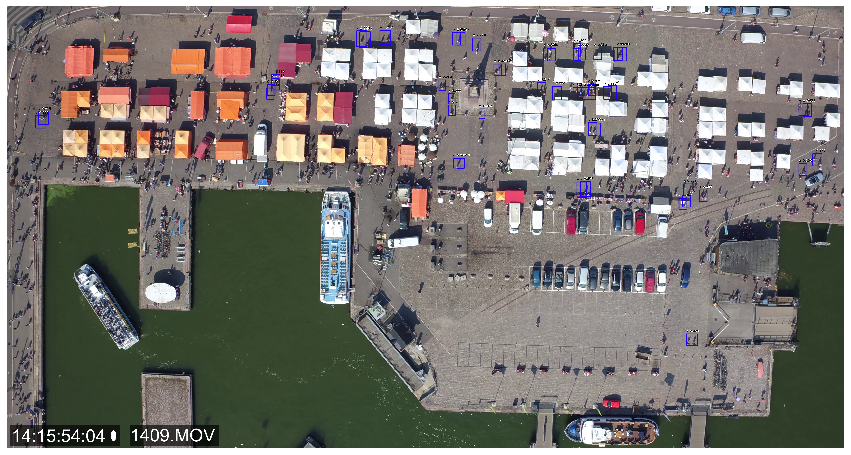

In [30]:
# load image
image = read_image_bgr('/home/bhuwan/Desktop/video/helsinkicity/kauppa102.jpg')


# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = infer_model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.2:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()


In [74]:
video_path = 'church.mp4'
output_path = 'helsinki.avi'
fps = 20
list_file = open('det.txt', 'w')
frame_index = -1 

vcapture = cv2.VideoCapture(video_path)

width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))  # uses given video width and height
height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
vwriter = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'MJPG'),fps, (width, height)) #

num_frames = int(vcapture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of Frames: ", num_frames)
print("Original Width, Height: ", width, height)

Number of Frames:  491
Original Width, Height:  4096 2160


In [75]:
os.system('mkdir predictions')

0

In [76]:

def run_detection_video(video_path):
    count = 0
    success = True
    start = time.time()
    while success:
        print("frame: ", count)
        count += 1  # see what frames you are at
        # Read next image
        success, image = vcapture.read()
        print(success)
        
        if success:
            
            # so we can keep orig image scale
            draw = image.copy()
            draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
            
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
             # preprocess image for network
            image = preprocess_image(image)
            image, scale = resize_image(image)
            
            # Do compute
            boxes, scores, labels = infer_model.predict_on_batch(np.expand_dims(image, axis=0))
            
            # correct for image scale
            boxes /= scale
           
            
             # visualize detections    
            
            with open('predictions/' + 'frame' + str(count) + '.txt', 'w') as f:
                for box, score, label in zip(boxes[0], scores[0], labels[0]):
                # scores are sorted so we can break
                    print(box.astype(int))
                    if score < 0.18:
                        break
                    f.write(f' {int((box[0]))} {int((box[1]))} {int((box[2]))} {int((box[3]))} \n')

                       # color = label_color(label)

                       # b = box.astype(int)
                      #  draw_box(draw, b, color=color)

                       # caption = "{} {:.3f}".format(labels_to_names[label], score)
                      #  draw_caption(draw, b, caption)
            
               # vwriter.write(draw) # overwrites video slice

    
    vcapture.release()
    #vwriter.release() # 
    end = time.time()
    
    print("Total Time: ", end - start)
   

    
    
   

In [77]:
run_detection_video(video_path)

frame:  0
True
[2731 2076 2796 2135]
[2321  680 2382  742]
[2933 1351 2994 1401]
[2062  836 2131  901]
[1544 1435 1602 1498]
[2231 1755 2281 1807]
[2069 1975 2132 2035]
[2855  766 2931  836]
[1782 1501 1839 1562]
[1635  893 1689  953]
[2988 1387 3047 1432]
[2050 1139 2112 1199]
[3054 1391 3115 1431]
[1712 1097 1768 1152]
[1880 1697 1941 1751]
[3055 2029 3120 2087]
[1702 1376 1760 1441]
[2339  444 2398  492]
[2646  681 2725  750]
[ 956 1563 1020 1619]
[2805 1664 2861 1714]
[2870 1685 2928 1734]
[1752  645 1805  701]
[1352  470 1405  525]
[1939 1068 2002 1130]
[2398  839 2468  895]
[1727 1566 1786 1626]
[1943  462 2007  532]
[2057  371 2127  429]
[2919  819 2988  883]
[2904 1287 2961 1339]
[2992  645 3067  718]
[2646 1253 2706 1302]
[1633 1479 1690 1546]
[1260 1531 1319 1587]
[1382  359 1433  412]
[2796  938 2861  991]
[2310 1600 2363 1657]
[1562  457 1612  503]
[2863 1540 2922 1587]
[2669 1318 2722 1368]
[2738 2058 2810 2124]
[1265 1131 1345 1187]
[2887  779 2963  842]
[1630  824 1682  

[2932 1347 2997 1400]
[2323  684 2385  745]
[2729 2077 2797 2138]
[2985 1387 3049 1436]
[2055  366 2128  432]
[2229 1757 2285 1807]
[2412  847 2481  898]
[2544  320 2614  390]
[2340  440 2403  494]
[1715 1096 1767 1149]
[2865 1534 2923 1585]
[1940  463 2007  536]
[1940 1065 2004 1130]
[2219  431 2281  479]
[3056 2027 3120 2083]
[1340  469 1397  534]
[2997  645 3068  714]
[2903 1289 2965 1344]
[2805 1674 2861 1726]
[1754  646 1804  698]
[1541 1441 1597 1500]
[1381  354 1432  413]
[2870 1686 2926 1734]
[2650 1253 2713 1303]
[1703 1378 1762 1441]
[2072 1978 2134 2031]
[1407  568 1467  637]
[3051 1389 3114 1436]
[2064  831 2128  886]
[2255  274 2322  335]
[2310 1606 2366 1658]
[2906 1429 2970 1480]
[2052 1138 2110 1196]
[1935 1080 1993 1145]
[2947 1354 3013 1406]
[1636  895 1692  958]
[1787 1505 1843 1561]
[2174  356 2239  414]
[ 958 1564 1020 1621]
[2925 1319 2990 1375]
[2340  860 2406  908]
[2246 1380 2299 1429]
[2664 1532 2716 1583]
[2090  372 2162  437]
[2850  771 2923  831]
[2804 1148

[2319  685 2385  751]
[2933 1347 2997 1400]
[2736 2078 2800 2143]
[1536 1445 1595 1511]
[2987 1390 3049 1434]
[2341  432 2407  492]
[2866 1532 2922 1579]
[1937  472 2000  539]
[1708 1372 1767 1440]
[2054  367 2125  437]
[1780 1499 1842 1559]
[2652 1246 2715 1301]
[2071 1973 2137 2033]
[2999  645 3075  713]
[2539  325 2608  393]
[1353  464 1407  532]
[2230 1758 2285 1807]
[2871 1685 2927 1735]
[1710 1101 1765 1154]
[2055  824 2123  883]
[3058 2025 3121 2083]
[2804 1661 2859 1713]
[1383  357 1433  416]
[2053 1139 2111 1196]
[1928 1067 1991 1132]
[1559  456 1608  506]
[2579 1969 2649 2034]
[2225 1198 2281 1242]
[2804 1145 2864 1197]
[2906 1291 2966 1346]
[3052 1393 3116 1436]
[2905 1435 2966 1480]
[2947 1357 3012 1406]
[3109 1666 3172 1710]
[2741 2054 2810 2132]
[1209 1360 1279 1419]
[2313 1605 2369 1658]
[2411  838 2481  892]
[1727 1580 1787 1641]
[2784 1378 2840 1430]
[2998 1788 3061 1836]
[1933  600 1996  662]
[2963  744 3041  808]
[2253  268 2326  341]
[1632 1499 1691 1565]
[2223  432

[1534 1448 1595 1514]
[2735 2075 2795 2138]
[2344  427 2408  489]
[2068 1966 2136 2034]
[2324  690 2390  749]
[2933 1347 2992 1396]
[1780 1496 1843 1558]
[1708 1369 1769 1440]
[2229 1755 2283 1806]
[2539  322 2605  391]
[1208 1362 1278 1421]
[2987 1392 3044 1432]
[1707 1100 1764 1150]
[2866 1528 2921 1577]
[2225 1197 2277 1236]
[2584 1970 2647 2034]
[ 946 1574 1009 1631]
[2871 1682 2929 1737]
[2803 1658 2858 1712]
[3005  640 3080  710]
[2055  369 2129  435]
[2654 1247 2714 1299]
[1353  463 1408  529]
[1281 1367 1342 1421]
[2255  271 2325  343]
[ 493 1879  567 1945]
[1382  354 1432  411]
[2123 1790 2182 1838]
[1938  473 2005  536]
[1886 1684 1946 1737]
[2382 1926 2450 1987]
[1727 1586 1786 1645]
[3058 2029 3119 2082]
[2996 1786 3057 1838]
[2414  840 2484  892]
[2053  820 2116  876]
[2911 1295 2967 1345]
[2221  432 2285  491]
[2858 1168 2920 1218]
[2174  356 2238  422]
[1631 1496 1693 1564]
[1556  456 1606  505]
[1927 1072 1983 1126]
[2100 1788 2159 1836]
[1641 1472 1703 1544]
[2055 1143

[2324  696 2387  759]
[2065 1963 2135 2035]
[1531 1454 1591 1521]
[2735 2079 2801 2143]
[2934 1348 2995 1393]
[2348  425 2413  484]
[1781 1495 1843 1559]
[2423  832 2492  893]
[ 948 1576 1011 1633]
[2231 1756 2287 1810]
[2655 1249 2716 1297]
[3013  636 3088  708]
[1207 1363 1275 1425]
[2986 1392 3046 1432]
[2804 1657 2858 1715]
[1356  465 1409  526]
[3058 2026 3119 2083]
[2534  329 2606  394]
[2579 1969 2650 2035]
[2054  368 2127  433]
[1729 1586 1792 1646]
[2871 1681 2928 1738]
[2258  270 2325  344]
[2120 1789 2180 1840]
[2866 1529 2921 1579]
[1643 1472 1704 1543]
[2227 1199 2278 1238]
[2862 1169 2924 1214]
[1711 1371 1771 1440]
[1701 1105 1760 1157]
[ 495 1881  565 1942]
[2811 1144 2870 1189]
[1936  475 2002  540]
[1559  455 1607  507]
[1634 1497 1694 1565]
[2671 1321 2725 1365]
[2218  444 2279  497]
[2051  822 2108  872]
[1382  356 1434  414]
[2396 1909 2469 1975]
[2596 1308 2652 1355]
[2909 1298 2967 1343]
[2056 1144 2108 1192]
[2381 1925 2452 1987]
[2997 1786 3060 1839]
[2177  358

[2934 1347 3001 1396]
[2068 1965 2135 2036]
[2327  696 2389  762]
[1527 1456 1589 1523]
[2735 2077 2804 2149]
[ 943 1573 1012 1639]
[2353  423 2420  486]
[2424  833 2490  896]
[3058 2025 3118 2083]
[2659 1250 2717 1297]
[2257  272 2326  347]
[2117 1788 2177 1839]
[2870 1681 2932 1739]
[2803 1658 2861 1717]
[2536  330 2603  399]
[2580 1967 2651 2038]
[1700 1110 1758 1160]
[1357  467 1409  532]
[2597 1303 2655 1353]
[2231 1757 2287 1811]
[1779 1497 1843 1558]
[1382  358 1435  416]
[2046  819 2110  872]
[2866 1525 2924 1580]
[1719 1371 1780 1437]
[1204 1363 1278 1426]
[2054  366 2125  430]
[2928 1316 2994 1370]
[2984 1390 3050 1437]
[2352  860 2415  917]
[2208 1070 2263 1121]
[2055 1141 2107 1194]
[1649 1472 1710 1540]
[1649  891 1710  952]
[2150  917 2208  969]
[2813 1148 2868 1192]
[ 768 1581  822 1641]
[2359  890 2423  948]
[2910 1293 2971 1346]
[1897 1701 1954 1752]
[2171  939 2226  990]
[2176  365 2237  426]
[1560  455 1607  508]
[2215 1019 2272 1070]
[2160 2095 2224 2156]
[2064 1214

[1519 1454 1588 1529]
[2359  414 2426  484]
[2323  697 2389  762]
[2068 1966 2134 2034]
[2930 1347 2999 1398]
[ 944 1574 1011 1643]
[2053  363 2125  434]
[1719 1366 1783 1438]
[2667 1250 2722 1292]
[2250  272 2326  354]
[1703 1111 1757 1161]
[2427  829 2497  892]
[2120 1785 2177 1834]
[3059 2025 3118 2084]
[1356  463 1410  530]
[2736 2084 2798 2152]
[2580 1970 2649 2038]
[1777 1497 1845 1562]
[2803 1657 2862 1716]
[1646 1470 1713 1545]
[1901 1701 1957 1752]
[2224  439 2291  505]
[1653  889 1708  951]
[2870 1683 2932 1739]
[1200 1363 1270 1425]
[2230 1758 2284 1812]
[2535  331 2600  399]
[1265  980 1330 1041]
[2041  813 2107  867]
[1384  357 1437  415]
[2168  426 2239  491]
[2173  363 2241  429]
[1924  473 1993  541]
[2601 1310 2654 1352]
[2056 1139 2110 1199]
[2601 1971 2671 2042]
[1536  816 1587  878]
[2864 1525 2926 1579]
[2393 1907 2469 1974]
[1733 1604 1799 1668]
[2651  687 2728  752]
[2088  368 2162  438]
[1638  821 1690  879]
[2175  938 2233  992]
[2227 1197 2280 1242]
[2145  913

[2360  413 2432  480]
[2068 1966 2136 2036]
[2328  707 2390  772]
[2671 1248 2728 1294]
[1523 1457 1584 1524]
[1727 1369 1791 1440]
[1780 1497 1847 1564]
[1697 1113 1759 1162]
[2805 1662 2861 1714]
[3058 2027 3117 2086]
[2252  275 2333  355]
[ 947 1578 1007 1640]
[1902 1068 1963 1125]
[1358  465 1413  528]
[2048  367 2126  434]
[2870 1686 2929 1737]
[2929 1349 2998 1397]
[2736 2087 2798 2152]
[2174  938 2232  987]
[2144  919 2204  968]
[2042  818 2103  863]
[2535  339 2602  403]
[2430  829 2498  891]
[1650 1470 1714 1543]
[1200 1362 1271 1425]
[1915  476 1986  542]
[2121 1785 2177 1836]
[2231 1759 2285 1812]
[2055 1143 2112 1196]
[2730 1249 2790 1294]
[1908 1705 1960 1754]
[2164  925 2224  976]
[2867 1529 2927 1576]
[1714 1358 1780 1425]
[2911 1433 2972 1477]
[1386  362 1436  415]
[3023  631 3090  696]
[1656  891 1710  947]
[1869 1341 1932 1401]
[2583 1974 2645 2038]
[2062 1214 2118 1263]
[2206 1070 2268 1118]
[ 516 1878  585 1942]
[2150  935 2209  983]
[1275 1136 1336 1182]
[1761 1476

[2070 1967 2136 2036]
[2330  708 2391  776]
[2669 1250 2726 1296]
[2363  410 2437  482]
[1699 1111 1759 1161]
[2928 1345 2999 1399]
[1783 1498 1848 1565]
[1912  482 1982  548]
[1515 1461 1573 1522]
[ 945 1580 1006 1641]
[2252  273 2331  357]
[3030  637 3093  702]
[2535  336 2602  403]
[2435  825 2508  892]
[2870 1686 2928 1737]
[1733 1377 1793 1442]
[2727 1250 2788 1297]
[2804 1663 2859 1715]
[1358  465 1412  529]
[1656  891 1710  950]
[2231 1758 2288 1813]
[1386  360 1437  417]
[2050  369 2125  434]
[1898 1062 1963 1120]
[2666 1533 2717 1581]
[2042  804 2100  851]
[2739 2091 2800 2154]
[1654 1470 1716 1542]
[1267  985 1335 1038]
[3059 2029 3116 2084]
[2669 1323 2722 1363]
[2119 1787 2178 1841]
[2651 1250 2709 1293]
[1732   22 1798   84]
[2224  446 2294  512]
[1766 1506 1831 1572]
[1285 1126 1345 1172]
[2907 1430 2972 1480]
[2377 1259 2427 1304]
[2867 1530 2927 1578]
[2604 1316 2654 1354]
[2896 1244 2963 1298]
[2921 1315 2991 1372]
[1868 1344 1929 1399]
[1204 1358 1274 1421]
[2141  920

[2325  714 2386  778]
[2668 1248 2728 1300]
[2070 1970 2134 2035]
[2930 1346 2998 1397]
[ 944 1584 1009 1642]
[2252  273 2328  359]
[2873 1688 2931 1738]
[3028  632 3097  703]
[1511 1466 1567 1519]
[1700 1112 1760 1165]
[1658  889 1714  948]
[2802 1672 2860 1726]
[2439  832 2509  892]
[2366  413 2436  478]
[1786 1501 1848 1563]
[2727 1246 2790 1296]
[1899 1057 1965 1119]
[2032  793 2097  851]
[1265  987 1332 1036]
[1907  480 1980  546]
[2536  343 2598  401]
[1386  360 1438  417]
[2048  367 2125  434]
[2667 1532 2720 1581]
[2174  940 2232  994]
[1913 1709 1961 1754]
[1277 1134 1336 1180]
[2232 1759 2288 1811]
[1358  466 1414  528]
[1381 1238 1441 1290]
[2427 1286 2479 1342]
[2645 1249 2707 1299]
[1205 1357 1274 1414]
[2868 1531 2925 1578]
[2670 1322 2727 1369]
[2302  718 2365  778]
[2142  918 2203  975]
[1162 1098 1223 1143]
[2741 2094 2800 2155]
[1735   28 1801   88]
[3060 2031 3116 2084]
[2599 1309 2658 1358]
[2587 1979 2643 2036]
[1538  824 1586  880]
[1275 1190 1337 1236]
[2920 1311

[2334  719 2396  781]
[2068 1968 2134 2033]
[2669 1244 2729 1298]
[2385  396 2450  468]
[2930 1346 3001 1399]
[2448  826 2511  887]
[2257  272 2327  356]
[3032  635 3100  702]
[1278 1125 1338 1172]
[2874 1690 2929 1737]
[2806 1675 2861 1725]
[2534  342 2595  406]
[1507 1469 1568 1521]
[1698 1113 1757 1163]
[1266  985 1331 1036]
[1359  467 1414  531]
[1158 1098 1217 1142]
[1383 1241 1441 1292]
[1388  357 1437  414]
[1660  890 1712  947]
[2668 1534 2720 1581]
[1908  480 1978  545]
[2232 1759 2289 1813]
[2724 1247 2788 1298]
[1786 1503 1843 1565]
[2054  369 2125  438]
[1274 1190 1335 1237]
[2971  745 3038  806]
[3059 2028 3116 2086]
[1915 1690 1961 1736]
[2740 2093 2800 2158]
[2423 1286 2477 1341]
[1897 1059 1961 1116]
[3004 1795 3058 1842]
[1275 1216 1335 1263]
[1915 1709 1961 1752]
[1868 1344 1928 1399]
[2586 1980 2644 2040]
[2644 1246 2706 1297]
[2706 1244 2767 1299]
[2868 1531 2926 1578]
[1207 1356 1274 1412]
[2912 1434 2976 1485]
[2664  692 2730  745]
[2919 1309 2991 1365]
[ 943 1583

[2332  720 2397  780]
[2663 1239 2728 1296]
[2069 1970 2133 2036]
[2453  824 2520  883]
[2807 1675 2862 1724]
[2928 1343 3004 1403]
[2874 1692 2930 1738]
[1502 1470 1563 1525]
[1264  983 1336 1040]
[1695 1112 1757 1167]
[2419 1286 2476 1342]
[2386  393 2453  469]
[2395  895 2453  951]
[2641 1241 2706 1295]
[1273 1130 1337 1179]
[2374  845 2434  902]
[2231 1758 2292 1812]
[2858 1166 2927 1224]
[1748 1357 1810 1423]
[2021  781 2084  837]
[1358  468 1412  528]
[2529  340 2595  412]
[2061  367 2129  431]
[1900  483 1968  547]
[1865 1341 1927 1401]
[ 945 1584 1002 1640]
[2388  868 2448  922]
[2596 1302 2660 1356]
[2117 1786 2176 1838]
[2667 1534 2720 1581]
[1662  889 1715  950]
[2875 1242 2953 1303]
[2257  273 2326  355]
[2698 1240 2767 1297]
[3035  638 3103  699]
[2583 1978 2645 2040]
[1381 1242 1441 1291]
[1921 1709 1974 1753]
[3060 2031 3119 2087]
[1899 1055 1958 1116]
[1967  576 2034  643]
[2867 1530 2926 1577]
[2912 1430 2976 1484]
[2371 1237 2425 1291]
[2172  429 2238  489]
[1392  357

[2454  822 2519  881]
[2809 1674 2863 1722]
[2336  722 2396  781]
[1497 1472 1560 1536]
[2875 1691 2931 1738]
[2926 1344 3005 1402]
[2663 1237 2727 1296]
[2073 1974 2135 2031]
[2392  396 2453  464]
[2015  776 2083  837]
[2687 1240 2751 1298]
[2326  734 2383  791]
[1695 1113 1756 1166]
[2520  347 2585  416]
[2667 1536 2717 1579]
[2233 1759 2292 1810]
[2597 1301 2660 1357]
[2412 1288 2466 1340]
[3060 2029 3120 2086]
[1903  484 1969  548]
[1380 1242 1438 1294]
[1971  573 2038  640]
[1277 1130 1339 1179]
[1869 1343 1926 1402]
[2056  368 2127  433]
[1151 1099 1219 1148]
[2121 1790 2179 1836]
[2636 1236 2698 1295]
[1754 1362 1809 1422]
[1661  891 1714  949]
[2877 1245 2951 1303]
[1362  467 1414  527]
[2255  273 2326  357]
[1263  983 1329 1038]
[3113 1711 3177 1758]
[1285 1370 1346 1420]
[2866 1530 2925 1576]
[1392  358 1441  413]
[1784 1503 1842 1563]
[2369 1241 2422 1291]
[2686 1534 2736 1578]
[3041  628 3117  693]
[2855 1167 2924 1222]
[2348 1590 2404 1646]
[3007 1794 3061 1841]
[1270 1453

[2458  824 2520  878]
[2809 1675 2863 1723]
[2335  726 2394  783]
[2072 1976 2132 2031]
[1487 1481 1548 1533]
[2875 1692 2930 1738]
[1278 1133 1338 1178]
[2395  397 2454  460]
[3059 2029 3119 2088]
[2690 1239 2752 1301]
[2596 1300 2658 1363]
[2928 1346 3001 1400]
[2662 1234 2726 1297]
[1287 1370 1345 1418]
[2518  355 2583  418]
[1382 1239 1437 1289]
[1895  492 1951  551]
[2015  768 2080  828]
[2232 1759 2292 1809]
[1755 1362 1812 1422]
[2122 1791 2179 1835]
[2413 1285 2469 1339]
[1869 1343 1927 1402]
[2663 1535 2716 1581]
[1692 1117 1751 1167]
[2639 1232 2699 1295]
[2062  365 2127  429]
[1154 1099 1217 1144]
[1362  468 1416  526]
[3115 1714 3173 1760]
[1274 1452 1333 1502]
[1206 1349 1271 1402]
[1154 1116 1217 1159]
[1392  354 1442  412]
[2259  277 2324  356]
[1284 1185 1343 1231]
[1979  569 2040  632]
[2879 1247 2945 1303]
[ 943 1584 1002 1639]
[2348 1585 2404 1641]
[1733   48 1799   98]
[1785 1504 1843 1564]
[1502 1469 1567 1530]
[1265  984 1328 1036]
[2877 1529 2938 1578]
[3008 1794

[2470  825 2526  880]
[1488 1481 1542 1532]
[2330  739 2386  793]
[1281 1130 1338 1183]
[1289 1370 1344 1418]
[2017  763 2077  817]
[2929 1347 3003 1400]
[2690 1238 2752 1295]
[1693 1119 1749 1169]
[1154 1114 1215 1166]
[2876 1691 2932 1741]
[1871 1347 1928 1402]
[2074 1975 2136 2029]
[1383 1238 1438 1289]
[2666 1234 2729 1291]
[2665 1536 2717 1585]
[3007 1790 3059 1841]
[ 947 1581 1003 1641]
[1394  356 1441  409]
[2233 1759 2291 1809]
[1362  466 1415  525]
[2812 1673 2869 1723]
[2400  399 2456  457]
[2122 1788 2177 1833]
[3568 1433 3634 1494]
[1207 1346 1269 1397]
[3060 2031 3120 2092]
[2519  355 2579  417]
[1273 1455 1329 1504]
[3045  623 3115  683]
[2879 1245 2948 1301]
[1665 1471 1730 1536]
[2860 1171 2925 1224]
[1787 1503 1846 1561]
[1758 1364 1817 1422]
[2065  368 2129  431]
[3177  909 3234  965]
[1660  820 1714  878]
[2398  842 2452  893]
[1156 1097 1216 1148]
[2641 1233 2704 1290]
[1286 1185 1341 1235]
[2406 1289 2465 1342]
[1882 1061 1947 1123]
[1893  494 1951  553]
[1674  890

[2475  822 2530  877]
[2326  737 2385  796]
[1482 1481 1539 1533]
[1279 1128 1338 1182]
[2015  761 2076  814]
[2074 1973 2137 2029]
[2696 1235 2755 1290]
[2402  396 2461  454]
[ 944 1583 1004 1642]
[1692 1118 1748 1172]
[2876 1691 2933 1742]
[1362  469 1415  525]
[2404 1285 2466 1344]
[1288 1372 1349 1420]
[1379 1241 1438 1293]
[2811 1672 2870 1724]
[2665 1533 2717 1584]
[1157 1117 1217 1166]
[3005 1791 3059 1850]
[3117 1721 3173 1777]
[2929 1348 3002 1395]
[1876 1056 1943 1126]
[1874 1348 1932 1401]
[2512  357 2575  414]
[1667 1471 1735 1536]
[1284 1184 1342 1235]
[3052  623 3118  684]
[2233 1755 2295 1810]
[2260  277 2325  352]
[2243  477 2304  534]
[2215 1070 2270 1116]
[2665 1233 2730 1286]
[2122 1787 2180 1836]
[3061 2032 3121 2091]
[2195 2078 2260 2126]
[1284 1215 1343 1265]
[2320  405 2377  464]
[1786 1503 1848 1560]
[1265  985 1326 1042]
[2067  368 2130  429]
[2221 1028 2275 1074]
[3176  911 3238  965]
[2217 1041 2270 1088]
[1543  818 1593  876]
[2813  949 2867 1000]
[2070 1212

[1278 1125 1338 1182]
[2325  740 2383  796]
[2475  821 2534  875]
[1473 1486 1533 1537]
[1160 1116 1220 1166]
[1363  466 1417  528]
[2073 1974 2139 2033]
[3572 1435 3640 1494]
[2064 1135 2115 1192]
[2513  354 2571  413]
[3117 1728 3172 1782]
[2689 1235 2755 1285]
[2876 1691 2932 1742]
[3059  621 3127  684]
[3009 1794 3060 1850]
[3062 2032 3120 2091]
[2233 1754 2296 1812]
[1267  981 1324 1042]
[2360 1574 2417 1640]
[2812 1674 2869 1724]
[2412  394 2466  451]
[2666 1533 2717 1583]
[1284 1373 1348 1426]
[2641 1233 2705 1279]
[2929 1344 3006 1398]
[1669 1472 1737 1536]
[1283 1183 1342 1234]
[1881  502 1936  557]
[2878  966 2936 1019]
[1282 1162 1342 1214]
[ 945 1583 1010 1644]
[1692 1118 1750 1170]
[2260  289 2321  356]
[1394  357 1443  414]
[2073 1209 2121 1262]
[2304 1501 2367 1565]
[1876 1346 1933 1399]
[2123 1784 2184 1836]
[2196 2073 2263 2124]
[1462  569 1514  626]
[2813 1019 2868 1067]
[1377 1239 1436 1291]
[2402 1289 2459 1340]
[2217 1038 2272 1090]
[1542  819 1595  875]
[1284 1217

[2323  740 2383  804]
[2475  812 2540  875]
[1280 1126 1336 1181]
[1157 1115 1216 1165]
[1470 1488 1532 1540]
[2691 1234 2756 1285]
[1364  467 1415  526]
[1267  982 1326 1042]
[2419  384 2472  445]
[2402 1282 2462 1338]
[3114 1727 3174 1788]
[2364 1573 2418 1634]
[2512  351 2570  411]
[3064  620 3132  682]
[2231 1754 2295 1811]
[3009 1793 3063 1852]
[1692 1117 1749 1165]
[2124 1786 2187 1836]
[3573 1432 3644 1491]
[2073 1977 2141 2033]
[ 946 1583 1010 1645]
[3060 2034 3120 2091]
[1542  820 1595  876]
[2637 1231 2701 1279]
[2875 1691 2932 1743]
[1394  353 1442  411]
[2667 1535 2717 1580]
[1788 1507 1848 1559]
[2811 1673 2868 1723]
[1669 1474 1738 1534]
[2064 1137 2117 1194]
[1285 1374 1344 1427]
[2305 1499 2366 1559]
[1875 1348 1933 1401]
[2936 1353 3003 1403]
[2258  288 2320  357]
[2662 1232 2725 1282]
[2880  969 2934 1020]
[1211  493 1266  551]
[1267 1452 1333 1506]
[1172  578 1231  642]
[1287 1186 1339 1234]
[2217 1037 2272 1091]
[1284 1160 1339 1210]
[1161 1133 1217 1182]
[2071 1211

[2483  815 2546  875]
[2325  743 2391  812]
[1690 1120 1746 1168]
[1283 1133 1341 1182]
[1368  472 1419  526]
[1465 1494 1522 1544]
[3071  618 3132  677]
[1685  892 1735  940]
[2420  386 2474  443]
[2230 1757 2294 1814]
[3006 1791 3067 1852]
[1395  362 1442  411]
[2300 1506 2355 1564]
[2936 1356 3000 1406]
[2369 1572 2424 1631]
[2391 1283 2453 1334]
[1786 1512 1847 1558]
[2126 1783 2187 1836]
[1267  987 1326 1044]
[3111 1749 3180 1814]
[2588 1975 2653 2035]
[2075 1981 2142 2036]
[1284 1187 1343 1233]
[ 951 1586 1014 1644]
[3589 1436 3654 1493]
[1155 1140 1216 1187]
[1542  455 1589  506]
[1756  597 1811  645]
[2008  746 2060  798]
[1154 1123 1217 1170]
[3061 2036 3121 2093]
[2194 2043 2261 2093]
[1863 1064 1923 1120]
[2810 1673 2866 1723]
[2209 2077 2273 2122]
[1284 1219 1342 1265]
[1283 1376 1345 1430]
[2258  298 2318  363]
[2398  875 2462  937]
[2250 1380 2308 1430]
[3072 1954 3134 2020]
[2411  821 2473  881]
[2882  968 2939 1018]
[2694 1240 2754 1285]
[2876 1692 2934 1744]
[1543  823

[2487  816 2547  874]
[1281 1130 1342 1183]
[2321  753 2387  819]
[1693 1120 1745 1171]
[1366  473 1418  527]
[3075  612 3139  676]
[2371 1575 2429 1630]
[1157 1140 1219 1191]
[2228 1756 2295 1816]
[2297 1505 2352 1560]
[1280 1218 1344 1269]
[1280 1185 1345 1236]
[3004 1795 3069 1854]
[1542  455 1590  506]
[1459 1496 1517 1547]
[1860 1065 1918 1123]
[2391 1284 2452 1333]
[1279 1377 1343 1430]
[1275  988 1334 1045]
[1755  594 1813  645]
[1283 1167 1343 1218]
[2816  955 2869 1004]
[2122 1785 2186 1842]
[1690  889 1739  941]
[1876 1351 1933 1400]
[2877  965 2936 1019]
[2423  384 2474  442]
[2073 1981 2143 2039]
[1159 1122 1218 1171]
[1869  517 1930  572]
[2936 1355 2999 1406]
[1543  825 1596  879]
[2417  821 2477  879]
[2810 1673 2870 1723]
[2685  703 2743  751]
[1367 1234 1431 1286]
[1787 1508 1848 1562]
[2412  838 2472  895]
[1276 1455 1337 1508]
[2198 2044 2267 2094]
[1395  361 1444  411]
[1214  498 1267  550]
[2667  698 2727  748]
[2880 1529 2938 1576]
[3112 1750 3180 1813]
[3058 2038

[2319  755 2383  825]
[2495  809 2554  874]
[3076  612 3139  675]
[1688 1117 1749 1170]
[1366  474 1417  528]
[2373 1575 2430 1632]
[3005 1797 3067 1855]
[1281 1132 1340 1181]
[1273 1455 1336 1510]
[1451 1497 1510 1551]
[1278 1379 1343 1431]
[2229 1756 2295 1814]
[2879  965 2935 1020]
[2703 1234 2764 1284]
[1854 1062 1918 1120]
[2933 1346 3002 1399]
[1269  989 1328 1043]
[1539  456 1589  507]
[2806 1672 2871 1724]
[2687  702 2744  749]
[1139 1148 1198 1194]
[1280 1188 1341 1235]
[1787 1514 1848 1561]
[1280 1219 1341 1267]
[1869  516 1929  573]
[1872 1351 1933 1401]
[1543  823 1597  880]
[2292 1508 2348 1561]
[2818  954 2868 1004]
[2392 1285 2449 1330]
[2219 1034 2277 1093]
[2409  833 2468  897]
[2422  379 2477  435]
[2253  307 2315  368]
[2930  827 2988  884]
[3173  907 3239  977]
[2074 1982 2142 2037]
[2809 1016 2864 1069]
[ 954 1586 1016 1642]
[2632 1712 2694 1765]
[1754  594 1813  645]
[2668  698 2727  747]
[2204 2049 2273 2096]
[3114 1756 3181 1817]
[2216 1064 2276 1125]
[2706 1214

[2320  758 2381  827]
[1688 1120 1749 1169]
[2500  810 2557  873]
[3080  614 3138  672]
[1364  471 1417  528]
[2373 1575 2430 1631]
[1539  454 1590  507]
[1283 1134 1339 1182]
[2814  954 2865 1003]
[2689  699 2748  747]
[2809  795 2865  844]
[2229 1757 2295 1813]
[1851 1070 1913 1120]
[1873 1350 1933 1399]
[3008 1801 3065 1851]
[2940 1354 3001 1401]
[2881  965 2934 1018]
[1275 1457 1334 1508]
[2933  825 2987  881]
[1278 1222 1338 1268]
[1282 1189 1339 1233]
[1269  989 1327 1044]
[2389 1285 2446 1331]
[1140 1150 1196 1193]
[1445 1509 1500 1559]
[2805 1674 2872 1725]
[2206 2045 2273 2092]
[1689  885 1745  940]
[1780 1315 1845 1363]
[2827  803 2883  850]
[1043 1642 1097 1694]
[2792  790 2847  839]
[2806 1015 2861 1067]
[2413  814 2469  876]
[ 960 1585 1013 1639]
[2666  698 2725  747]
[1781 1339 1845 1389]
[2290 1509 2346 1561]
[2590 1975 2658 2032]
[1787 1512 1847 1563]
[1542  821 1599  883]
[2427  380 2478  432]
[1866  525 1926  577]
[2337  431 2392  485]
[2702 1239 2761 1288]
[2878 1533

[2322  766 2378  827]
[1689 1118 1747 1169]
[2505  814 2562  869]
[1366  473 1421  526]
[2695  700 2751  743]
[3089  615 3147  671]
[1534  454 1588  507]
[1690  880 1745  938]
[2230 1755 2293 1811]
[1999  724 2048  774]
[1876 1352 1934 1397]
[1848 1066 1910 1119]
[2375 1577 2430 1631]
[1864  530 1921  578]
[2208 2040 2276 2089]
[2934  826 2990  879]
[2816  955 2869 1002]
[2811  797 2863  841]
[2666  698 2723  743]
[2353 1221 2410 1271]
[1542  825 1597  884]
[3005 1797 3071 1851]
[2881  966 2935 1015]
[2789  793 2843  839]
[1780 1314 1843 1361]
[2384 1282 2443 1333]
[2498  381 2552  432]
[2070 1217 2119 1260]
[1216  499 1267  549]
[1286 1136 1340 1182]
[2702 1238 2759 1286]
[2667 1539 2722 1579]
[2806 1674 2871 1724]
[2829  803 2884  847]
[1953 1688 2016 1737]
[2128 1786 2190 1838]
[1785 1512 1849 1562]
[2935 1345 2998 1397]
[1592 1163 1652 1213]
[ 955 1582 1013 1643]
[1782 1340 1844 1388]
[2879 1533 2939 1579]
[2295  361 2354  419]
[2072 1982 2142 2037]
[1276  990 1336 1044]
[1271 1457

[1692 1116 1747 1168]
[2324  780 2378  830]
[1443 1513 1498 1563]
[1879 1351 1934 1398]
[1995  721 2048  772]
[1533  456 1585  508]
[1370  473 1422  526]
[2513  816 2567  867]
[1848 1061 1907 1116]
[2214 2041 2279 2090]
[1285 1138 1340 1185]
[2696  699 2750  747]
[3093  617 3148  670]
[3010 1795 3067 1853]
[1276 1385 1336 1433]
[1861  532 1917  582]
[1280 1456 1335 1505]
[1286 1223 1344 1270]
[2832  801 2883  851]
[1370 1231 1426 1279]
[1287 1188 1344 1232]
[1689  879 1747  941]
[2065 1148 2119 1200]
[1787 1510 1849 1563]
[1281  990 1335 1040]
[2067 1218 2118 1268]
[1594 1163 1651 1214]
[2936 1343 2996 1395]
[2816  795 2867  846]
[2495  383 2549  430]
[2808 1674 2867 1724]
[2939  829 2990  882]
[2438  374 2490  424]
[1144 1164 1200 1210]
[1481  574 1531  623]
[2233 1761 2294 1816]
[2640 1713 2703 1767]
[2789  790 2840  842]
[1216  499 1266  549]
[2145  924 2202  968]
[3156 1418 3206 1457]
[2638 1676 2698 1726]
[1543  827 1596  886]
[2881  964 2937 1018]
[2882 1531 2936 1575]
[3118 1769

[1430 1507 1491 1563]
[1985  721 2043  769]
[1688 1121 1747 1172]
[1536  458 1584  505]
[2810  792 2865  850]
[2518  811 2578  867]
[1370  473 1422  527]
[1879 1354 1938 1399]
[2211 2030 2277 2077]
[2322  778 2384  832]
[3107  616 3159  671]
[3011 1795 3069 1853]
[1862  538 1915  586]
[2827  799 2884  854]
[2793  787 2847  845]
[2705  694 2759  750]
[2882  968 2942 1020]
[2936 1357 2998 1410]
[2813 1677 2872 1727]
[1696  880 1756  939]
[2884 1530 2940 1578]
[1849 1052 1911 1103]
[2145  923 2201  969]
[2292  361 2352  415]
[2256  306 2318  367]
[1284 1131 1341 1183]
[1276 1456 1341 1507]
[2644 1711 2708 1770]
[2223 1071 2276 1123]
[2239 1763 2296 1818]
[2940  829 2995  883]
[1845 1068 1908 1118]
[1794 1318 1857 1365]
[2812  959 2870 1014]
[2985  755 3043  806]
[1800 1343 1860 1389]
[2077 1983 2143 2036]
[2063 1143 2117 1195]
[1355 1585 1418 1639]
[1786 1517 1849 1564]
[1487  574 1535  620]
[1595 1162 1654 1212]
[2493  382 2546  427]
[2223 1041 2277 1092]
[1543  826 1595  885]
[2698  503

[1434 1513 1495 1566]
[2325  784 2385  844]
[2521  798 2581  860]
[2215 2029 2281 2076]
[2882  963 2946 1024]
[2940 1352 3005 1411]
[2807  792 2866  848]
[1537  456 1584  507]
[2957  954 3021 1013]
[2725 1122 2807 1190]
[2883 1532 2939 1578]
[1881 1349 1940 1400]
[2936  834 2996  890]
[2789  787 2845  843]
[2814 1680 2873 1728]
[2146  923 2207  970]
[3011 1793 3074 1854]
[2392 1578 2445 1628]
[2707  693 2767  751]
[1372  472 1425  529]
[1696  879 1763  943]
[2841 1265 2919 1328]
[2812  951 2874 1012]
[2294  359 2353  411]
[1856  539 1910  585]
[2824  799 2885  855]
[1848 1067 1906 1119]
[2238 2075 2301 2120]
[2826 1096 2901 1167]
[2912 1439 2976 1494]
[2071 1222 2120 1267]
[2741 1152 2821 1225]
[1697 1121 1755 1170]
[2223 1069 2281 1117]
[3110  616 3164  670]
[2651 1714 2713 1770]
[2998 1402 3057 1450]
[2248 1212 2302 1256]
[1797 1310 1858 1362]
[2078 1987 2143 2037]
[2232 2052 2300 2099]
[2081  378 2145  424]
[2060 1148 2116 1199]
[2907 1037 2974 1100]
[3122 1770 3188 1838]
[1968 1687

[1432 1510 1496 1565]
[2532  793 2593  857]
[2326  793 2382  847]
[1697 1119 1755 1175]
[1847 1064 1907 1124]
[1881 1350 1940 1402]
[1539  455 1585  508]
[2062 1139 2124 1196]
[2147  924 2205  971]
[3105  939 3176 1012]
[2712  690 2772  747]
[2940 1357 3004 1408]
[3117  611 3174  674]
[1702  875 1764  942]
[2220 1035 2283 1090]
[2070 1220 2124 1271]
[2940  835 2998  890]
[2658 1713 2719 1769]
[2446  788 2502  847]
[2885 1532 2937 1576]
[2220 1061 2283 1117]
[2364  444 2419  499]
[2297  360 2355  413]
[3177  908 3242  979]
[2242 2073 2306 2119]
[2221 2027 2290 2075]
[3106  911 3174  985]
[2962  949 3023 1006]
[3126  920 3197  995]
[2237 2057 2304 2103]
[1599 1163 1657 1215]
[2883  967 2948 1020]
[2492  401 2549  457]
[1371  469 1426  528]
[2923 1442 2982 1489]
[1266 1388 1339 1437]
[1803 1310 1864 1363]
[1540  830 1597  899]
[3012 1797 3074 1854]
[2399 1578 2452 1625]
[3002 1406 3057 1450]
[2656 1678 2715 1733]
[2989  750 3049  805]
[2816 1680 2873 1728]
[2253 1384 2311 1436]
[1284  985

[2536  796 2599  860]
[1431 1514 1493 1564]
[2325  794 2387  849]
[1539  458 1584  508]
[1698 1116 1755 1171]
[2367  447 2424  503]
[2230 2023 2299 2070]
[2659 1707 2727 1768]
[1840 1064 1904 1127]
[2149  920 2211  966]
[1286  982 1347 1045]
[2939  830 3002  889]
[3014 1791 3074 1854]
[2936 1348 3003 1396]
[2171 2089 2232 2137]
[1747  117 1814  176]
[2250 2071 2312 2115]
[2299  356 2355  407]
[2884 1534 2937 1577]
[2655 1676 2721 1735]
[2242 1763 2300 1818]
[3122 1774 3187 1844]
[2217 1062 2285 1114]
[2218 1044 2286 1095]
[2988  750 3052  811]
[1761  580 1813  623]
[1284 1130 1350 1184]
[3007 1407 3062 1448]
[3116  602 3175  666]
[2608 1949 2681 2017]
[3112 1637 3161 1679]
[2076 1223 2128 1265]
[2088 1983 2155 2032]
[2859 1261 2928 1314]
[2244 2058 2308 2102]
[2403 1576 2458 1627]
[1600 1160 1658 1213]
[2069 1145 2129 1195]
[2806 1374 2873 1421]
[2716  684 2779  741]
[1854  546 1906  590]
[2099 2046 2163 2094]
[2927 1448 2986 1492]
[1842 1045 1908 1107]
[2960  946 3025 1003]
[2808  790

[2943 1347 3005 1401]
[1701 1117 1758 1173]
[1431 1518 1489 1566]
[2888 1531 2938 1575]
[2315  796 2387  859]
[2538  791 2609  860]
[2930 1446 2983 1494]
[2232 2021 2302 2066]
[2666 1710 2729 1767]
[2240 1757 2299 1812]
[1287  981 1347 1046]
[2367  449 2429  514]
[2174 2087 2238 2131]
[2151  919 2214  968]
[2270 1511 2324 1563]
[1539  460 1583  508]
[2402 1565 2456 1618]
[3014 1794 3072 1853]
[2743 1237 2803 1295]
[2262 1380 2315 1434]
[2861 1242 2925 1298]
[3006 1403 3059 1449]
[3122 1780 3185 1847]
[2859 1259 2922 1317]
[2301  350 2362  407]
[2831 1294 2893 1351]
[2609 1944 2680 2012]
[2809 1367 2866 1417]
[3107 1642 3157 1681]
[2072 1143 2129 1193]
[1261 1395 1333 1440]
[1801 1515 1853 1556]
[2097 2046 2165 2091]
[1974  706 2037  756]
[1837 1065 1896 1129]
[2660 1659 2719 1711]
[3119  597 3173  658]
[2715  677 2782  732]
[2842 1269 2908 1328]
[2816 1679 2876 1724]
[2086 1983 2153 2031]
[1710  871 1771  941]
[2787 1366 2844 1416]
[1761  579 1815  625]
[2939  830 3001  884]
[1821 1310

[1701 1115 1756 1163]
[2372  451 2428  509]
[2324  796 2388  859]
[2942 1344 3003 1396]
[1428 1517 1485 1568]
[2152  917 2209  965]
[2070 1145 2126 1200]
[2087 1981 2157 2034]
[2243 1754 2297 1812]
[2542  789 2611  857]
[2889 1534 2938 1576]
[3014 1788 3076 1853]
[2079 1214 2133 1265]
[2308  345 2360  407]
[2296  330 2355  395]
[2175 2083 2240 2129]
[3103 1640 3154 1680]
[1605 1158 1662 1209]
[1290  976 1349 1041]
[1836 1070 1895 1131]
[2719  673 2782  728]
[2411 1568 2465 1617]
[2265  302 2324  368]
[2854 1261 2922 1317]
[2231 2015 2301 2061]
[2834 1294 2902 1350]
[1538  457 1583  508]
[1834 1040 1897 1100]
[2676 1705 2737 1761]
[1822 1305 1878 1364]
[3119 1783 3184 1854]
[2841 1270 2909 1329]
[ 968 1588 1017 1636]
[1971  704 2033  753]
[1804 1512 1858 1558]
[2940  826 3005  884]
[1850  547 1904  595]
[2809 1366 2870 1417]
[2706  494 2763  546]
[2857 1243 2926 1301]
[2812  789 2876  843]
[2928 1443 2981 1488]
[2099 2043 2166 2090]
[1980 1677 2036 1726]
[2161  906 2218  953]
[1292 1129

[1702 1114 1754 1166]
[2243 1755 2300 1812]
[2177 2082 2240 2129]
[2154  917 2211  969]
[1834 1064 1891 1129]
[2307  344 2364  407]
[2681 1705 2739 1759]
[2942 1341 2999 1394]
[1607 1160 1663 1210]
[2219 1058 2282 1121]
[1290  976 1351 1044]
[1262 1393 1329 1444]
[1832 1043 1891 1106]
[2326  798 2393  860]
[2477  400 2530  458]
[2163  903 2221  956]
[2414 1569 2467 1617]
[2070 1145 2124 1203]
[2888 1531 2940 1575]
[1419 1521 1480 1573]
[2374  449 2436  513]
[2237 2014 2306 2060]
[2090 1982 2157 2036]
[2774  769 2841  830]
[2078 1213 2131 1267]
[1291 1131 1351 1185]
[1537  460 1580  507]
[2546  793 2615  856]
[2809  788 2875  847]
[2099 2043 2167 2092]
[2368 1256 2429 1305]
[1351 1520 1413 1572]
[2220 1037 2284 1101]
[2261  300 2324  366]
[2264 2057 2328 2104]
[1806 1512 1857 1557]
[2719  671 2782  729]
[3013 1792 3080 1854]
[2183  431 2245  484]
[1832 1310 1885 1365]
[1846  549 1904  598]
[ 970 1587 1017 1638]
[1899 1341 1952 1397]
[3007 1400 3059 1446]
[2142 1783 2202 1834]
[2484  345

[1704 1113 1756 1165]
[1829 1066 1884 1130]
[1256 1393 1324 1446]
[1415 1518 1479 1571]
[2956 1343 3014 1391]
[1829 1042 1886 1105]
[1291  976 1350 1042]
[2292  327 2361  399]
[2152  912 2213  969]
[1608 1157 1662 1208]
[2325  795 2393  865]
[2069 1145 2125 1202]
[2088 1982 2158 2034]
[2683 1706 2740 1757]
[2244 1756 2300 1811]
[2219 1060 2285 1120]
[1291 1130 1352 1186]
[2886 1529 2940 1574]
[2363 1243 2428 1294]
[1351 1517 1415 1570]
[2258  294 2323  368]
[2178 2081 2241 2127]
[2419 1565 2469 1612]
[2784  783 2849  840]
[1283 1451 1350 1502]
[2165  901 2224  959]
[2484  339 2545  407]
[1804 1510 1855 1555]
[1717  868 1776  932]
[3009 1401 3060 1444]
[1626 1099 1679 1155]
[2681 1654 2735 1701]
[2099 2044 2167 2092]
[2474  397 2533  465]
[2265 2058 2328 2104]
[2079 1212 2132 1266]
[2609 1935 2689 2002]
[1084 1622 1137 1674]
[2243 2009 2309 2055]
[1845  545 1904  599]
[3013 1792 3081 1853]
[2741 1240 2804 1298]
[1236 1567 1298 1612]
[2553  795 2618  856]
[1535  457 1580  506]
[ 971 1585

[1705 1114 1756 1163]
[2956 1344 3017 1394]
[1607 1157 1662 1208]
[1291  977 1351 1042]
[2295  327 2358  399]
[2685 1705 2743 1758]
[2152  911 2212  969]
[1352 1518 1415 1570]
[2785  782 2853  841]
[1293 1131 1356 1186]
[2885 1530 2939 1573]
[1254 1397 1322 1449]
[1413 1525 1474 1575]
[2065 1144 2120 1201]
[2164  901 2222  958]
[2685 1652 2739 1701]
[1828 1072 1882 1124]
[2722  669 2790  730]
[1805 1510 1860 1558]
[2243 1760 2302 1813]
[2555  798 2621  860]
[2331  797 2395  861]
[2267  309 2330  381]
[1285 1448 1350 1499]
[2270 2055 2334 2102]
[2090 1981 2161 2036]
[1722 1590 1776 1633]
[2384  460 2448  528]
[ 971 1585 1020 1638]
[2803  788 2869  849]
[2260 1380 2317 1433]
[1831 1045 1885 1100]
[1239 1566 1298 1613]
[2186 2075 2248 2123]
[1088 1616 1142 1670]
[2183  428 2248  486]
[2363 1245 2427 1297]
[1627 1100 1679 1154]
[2244 2003 2312 2052]
[2489  341 2545  405]
[1844  546 1902  602]
[2745 1243 2807 1297]
[2472  398 2526  461]
[3005  751 3068  808]
[2683 1537 2742 1583]
[2220 1059

[1705 1115 1757 1167]
[2687 1704 2745 1756]
[1605 1157 1661 1210]
[2953 1339 3017 1393]
[1290  977 1351 1043]
[1413 1527 1470 1575]
[1360 1517 1418 1569]
[2732  675 2791  725]
[1804 1511 1862 1560]
[2242 1761 2302 1816]
[2271 2051 2335 2101]
[2157  908 2216  971]
[2688 1653 2744 1702]
[1724 1583 1777 1627]
[1292 1134 1356 1187]
[2885 1529 2939 1575]
[1252 1401 1317 1453]
[2327  811 2389  874]
[2745 1244 2807 1299]
[2186 2076 2247 2124]
[2505 1870 2581 1933]
[2089 1980 2158 2037]
[2492  342 2550  399]
[1627 1102 1681 1157]
[3118 1801 3186 1871]
[2563  799 2621  856]
[1379 1517 1438 1571]
[2256 2002 2324 2051]
[2065 1147 2120 1202]
[3015 1795 3081 1854]
[2294  329 2356  390]
[2182  432 2246  485]
[2258 1383 2316 1433]
[2096 2043 2168 2094]
[2575 1932 2656 2000]
[1828 1050 1879 1100]
[1825 1071 1876 1122]
[2999  753 3060  807]
[2812 1365 2872 1419]
[1299 1218 1362 1269]
[ 968 1584 1023 1640]
[2798  795 2860  843]
[1146 1193 1203 1241]
[2606 1935 2684 2002]
[2289 1286 2347 1333]
[2361 1243

[1705 1117 1758 1170]
[2741 1241 2809 1299]
[1802 1512 1861 1564]
[2690 1705 2747 1753]
[1727 1579 1782 1626]
[1365 1512 1422 1567]
[1288  979 1348 1046]
[2950 1342 3016 1396]
[1410 1528 1465 1577]
[2362 1237 2428 1291]
[1604 1159 1661 1213]
[2885 1528 2940 1574]
[1293 1131 1354 1186]
[2259 1998 2324 2046]
[2160  913 2215  967]
[2688 1656 2744 1702]
[2274 2049 2338 2097]
[1385 1522 1442 1572]
[2064 1147 2118 1200]
[2809 1366 2871 1419]
[1837 1286 1899 1351]
[2286 1284 2346 1335]
[2243 1763 2302 1818]
[1878 1334 1937 1396]
[3015 1793 3079 1855]
[2493  340 2552  402]
[3122 1810 3187 1882]
[2325  824 2387  878]
[2256 1382 2320 1435]
[2188 2074 2250 2122]
[1143 1195 1203 1243]
[2087 1983 2158 2035]
[2930 1442 2989 1495]
[2078 1211 2132 1265]
[2736  675 2793  727]
[2563  797 2627  854]
[1295 1185 1360 1236]
[2819 1682 2877 1726]
[2382  468 2452  527]
[2736 1216 2803 1271]
[2611 1306 2679 1355]
[1760  553 1818  601]
[1249 1400 1315 1453]
[1290 1451 1348 1503]
[1812 1073 1863 1126]
[ 967 1584

[1704 1118 1758 1170]
[2743 1243 2808 1301]
[1804 1512 1863 1565]
[1723 1574 1779 1624]
[2694 1703 2753 1754]
[2263 1993 2331 2042]
[1289  979 1348 1044]
[2887 1528 2941 1573]
[2508  340 2566  400]
[1604 1159 1660 1213]
[2275 2044 2342 2094]
[2691 1654 2746 1703]
[1295 1133 1353 1185]
[2157  911 2217  967]
[1843 1288 1905 1348]
[1880 1336 1939 1396]
[2330  821 2389  879]
[2948 1345 3016 1397]
[2088 1982 2156 2034]
[2240 1764 2301 1815]
[2189 2059 2259 2106]
[2081 1215 2132 1266]
[2743  670 2803  722]
[2285 1283 2344 1337]
[2360 1232 2424 1286]
[1810 1076 1864 1126]
[2810 1363 2871 1417]
[3120 1812 3185 1884]
[1377 1518 1436 1571]
[3015 1795 3078 1854]
[1408 1530 1464 1578]
[2817 1681 2876 1727]
[3087 1654 3146 1703]
[2428 1564 2481 1612]
[2066 1151 2119 1201]
[2887 1695 2945 1740]
[2095 2043 2168 2092]
[2257 1381 2320 1435]
[1152 1194 1210 1243]
[2929 1442 2987 1492]
[1556  821 1610  891]
[2567  800 2630  855]
[2082  366 2154  426]
[2459  404 2514  460]
[2681 1534 2742 1581]
[1293 1186

[1704 1118 1763 1171]
[2744 1244 2813 1300]
[2885 1529 2938 1573]
[2513  335 2569  402]
[2700 1705 2754 1750]
[2938 1341 3015 1401]
[3121 1813 3185 1890]
[2159  909 2219  966]
[1804 1514 1862 1566]
[2696 1658 2749 1701]
[2811 1367 2876 1418]
[1296 1137 1353 1186]
[2276 2043 2341 2095]
[3016 1790 3079 1855]
[2818 1685 2874 1726]
[2266 1991 2334 2043]
[1721 1571 1777 1624]
[2286 1283 2346 1334]
[2925 1443 2986 1494]
[2744  667 2809  721]
[1288  983 1347 1041]
[2238 1764 2302 1818]
[2817 1267 2890 1324]
[3076 1954 3139 2020]
[2812 1295 2882 1353]
[1604 1162 1660 1212]
[2193 2062 2260 2110]
[2429 1564 2485 1614]
[ 967 1584 1028 1644]
[2065 1330 2121 1382]
[2260 1380 2322 1433]
[3079 1654 3141 1713]
[2925 1308 3003 1370]
[2348 1242 2418 1292]
[2086 1980 2158 2035]
[2298  326 2361  391]
[2683 1538 2740 1582]
[2888 1697 2944 1740]
[1804 1074 1862 1125]
[1846 1291 1906 1348]
[2790 1369 2852 1420]
[2048 1150 2107 1201]
[1378 1523 1436 1567]
[1882 1350 1941 1407]
[1558  821 1610  894]
[2612 1309

[1702 1115 1762 1173]
[2885 1527 2939 1575]
[2754 1244 2822 1295]
[2703 1706 2759 1752]
[2288 1283 2346 1331]
[2156  910 2218  967]
[2942 1340 3012 1397]
[2269 1991 2336 2042]
[1923  640 1992  708]
[2346 1240 2412 1286]
[1804 1515 1865 1565]
[2515  332 2572  396]
[2707 1657 2759 1700]
[1726 1569 1787 1622]
[2819 1685 2873 1727]
[2813 1366 2876 1418]
[2580  804 2642  855]
[2747  664 2812  723]
[ 969 1585 1029 1646]
[2048 1147 2107 1202]
[3015 1794 3077 1854]
[1604 1160 1661 1214]
[2238 1763 2300 1816]
[1297 1137 1355 1186]
[2887 1699 2941 1743]
[1800 1069 1860 1127]
[2612 1311 2676 1359]
[3078 1655 3138 1710]
[2929 1307 3001 1366]
[1158 1198 1217 1244]
[2432 1563 2485 1611]
[2998  746 3065  805]
[2709  497 2764  554]
[3118 1823 3179 1893]
[1290  982 1346 1042]
[2080 1213 2133 1266]
[2278 2044 2341 2093]
[2141 1783 2202 1832]
[2817 1290 2886 1348]
[1556  823 1611  896]
[2928 1443 2984 1494]
[2714 1458 2772 1507]
[2819 1271 2888 1324]
[2089 1982 2160 2034]
[2194 2072 2257 2119]
[2243 1515

[2887 1527 2942 1574]
[2705 1703 2763 1752]
[2160  909 2219  965]
[1723 1561 1782 1618]
[2515  324 2577  396]
[2752 1246 2822 1299]
[2819 1683 2876 1729]
[2705 1656 2759 1703]
[2811 1367 2874 1419]
[2764  789 2823  843]
[1700 1118 1762 1177]
[1804 1515 1864 1568]
[3014 1798 3077 1857]
[2586  806 2648  860]
[2752  660 2818  723]
[2887 1699 2944 1746]
[2326  842 2389  894]
[1924  647 1986  700]
[1295 1138 1354 1184]
[2947 1342 3018 1396]
[ 966 1591 1028 1643]
[3072 1660 3134 1716]
[2780  793 2841  849]
[1289  983 1349 1040]
[2237 1763 2299 1818]
[2398  488 2469  555]
[1555  821 1613  896]
[2810 1292 2882 1350]
[1110 1616 1170 1667]
[2434 1561 2487 1611]
[1383 1534 1437 1572]
[3001  745 3070  811]
[2928 1443 2984 1493]
[2137 1782 2201 1833]
[1381 1522 1435 1561]
[2825 1270 2901 1332]
[2294  320 2361  389]
[2281 1287 2346 1334]
[2149 1807 2213 1858]
[2187  429 2255  491]
[2711 1458 2772 1507]
[2277 2044 2344 2093]
[3118 1824 3179 1895]
[2263  312 2331  380]
[2941  836 3005  894]
[2343 1240

[2152  907 2213  967]
[1725 1556 1782 1609]
[1808 1514 1864 1565]
[2708 1703 2767 1751]
[2590  804 2647  858]
[2748 1243 2819 1300]
[1915  637 1989  701]
[1703 1119 1763 1174]
[2517  327 2573  389]
[2817 1683 2873 1728]
[2810 1285 2879 1350]
[2815 1361 2878 1422]
[2888 1532 2941 1578]
[2940 1338 3014 1403]
[3013 1798 3076 1854]
[2710 1655 2764 1702]
[2327  838 2386  895]
[2883 1700 2939 1745]
[1295 1140 1350 1186]
[1286  984 1346 1043]
[2281 1287 2345 1331]
[2079  370 2152  436]
[2044 1151 2102 1201]
[2926 1438 2985 1493]
[2258 1386 2320 1435]
[2400  492 2468  559]
[2237 1765 2299 1817]
[2292  319 2360  389]
[2345 1246 2416 1289]
[2823 1271 2898 1337]
[2184  430 2255  495]
[2260  310 2329  379]
[2764  795 2823  848]
[2276 1982 2343 2030]
[2759  652 2818  710]
[2876 1162 2950 1227]
[ 970 1589 1025 1641]
[1383 1535 1436 1573]
[2279 2034 2343 2083]
[2081 1217 2135 1266]
[2450  414 2506  478]
[1555  821 1611  897]
[2063 1336 2120 1386]
[1159 1216 1218 1257]
[1111 1619 1165 1668]
[2151 1810

[2749 1241 2818 1301]
[1910  632 1978  698]
[2152  916 2211  966]
[2706 1704 2765 1753]
[2328  848 2383  896]
[2811 1360 2875 1419]
[2806 1287 2874 1352]
[2817 1680 2873 1727]
[1726 1554 1785 1606]
[3012 1795 3073 1851]
[2882 1529 2937 1578]
[2073  368 2149  434]
[2884 1699 2939 1746]
[2762  650 2826  709]
[1703 1117 1763 1174]
[2939 1341 3010 1403]
[2804 1263 2877 1327]
[2258 1386 2318 1434]
[2515  330 2577  394]
[2159  901 2219  949]
[1287  983 1347 1045]
[1804 1517 1864 1568]
[2925 1437 2985 1492]
[2710 1654 2764 1701]
[1292 1138 1353 1186]
[2762  796 2823  850]
[2241 1762 2300 1816]
[2347 1243 2410 1285]
[2590  806 2652  858]
[2285 1288 2345 1328]
[2278 2034 2346 2087]
[1733  843 1786  910]
[2089 1981 2158 2034]
[2938  834 3006  898]
[2039 1146 2097 1202]
[2150 1806 2209 1859]
[1554  822 1612  898]
[2928 1308 3000 1373]
[2877 1162 2953 1228]
[2021 1677 2076 1731]
[2804 1342 2875 1399]
[2747 1266 2819 1330]
[2438 1560 2489 1607]
[1858  802 1915  861]
[ 967 1586 1023 1646]
[2182  431

[2148  915 2207  964]
[2753 1241 2817 1299]
[2707 1703 2767 1752]
[2327  849 2382  897]
[2817 1681 2873 1728]
[ 964 1583 1025 1647]
[2073  370 2147  437]
[2804 1285 2869 1347]
[2768  648 2831  707]
[2288 1286 2348 1329]
[2531  330 2591  390]
[1699 1116 1760 1175]
[2813 1362 2876 1419]
[2258 1385 2317 1433]
[1753 1829 1808 1876]
[1733  839 1789  905]
[2346 1239 2408 1282]
[2713 1652 2765 1699]
[3010 1799 3076 1852]
[2881 1532 2938 1580]
[1919  627 1980  691]
[2402  500 2463  556]
[2936 1340 3007 1402]
[1557  820 1611  895]
[2592  804 2656  857]
[1287  979 1349 1045]
[2883 1699 2939 1744]
[1725 1550 1787 1603]
[2923 1435 2985 1491]
[2236 1761 2301 1817]
[2183  432 2250  496]
[2020 1670 2080 1729]
[1106 1613 1175 1677]
[2612 1311 2673 1359]
[2036 1144 2093 1197]
[2803 1267 2873 1327]
[1804 1517 1863 1568]
[1291 1133 1354 1187]
[2147 1807 2214 1861]
[2155  898 2214  947]
[1627  821 1685  890]
[1782 1069 1840 1126]
[2925 1305 3000 1370]
[1599 1163 1659 1222]
[2443  420 2498  479]
[2267  561

[2798 1285 2860 1348]
[2711 1701 2771 1752]
[2147  914 2206  963]
[1729  832 1790  906]
[2756 1242 2821 1301]
[2326  856 2388  900]
[2533  330 2596  392]
[2816 1357 2876 1415]
[1699 1120 1759 1174]
[2770  648 2833  701]
[1554  820 1611  897]
[2817 1681 2875 1728]
[1804 1514 1863 1570]
[2884 1532 2939 1579]
[2938 1341 3004 1402]
[1629  821 1687  897]
[2615 1311 2679 1357]
[2256 1388 2318 1435]
[3010 1794 3078 1855]
[2075  370 2148  433]
[1602 1163 1661 1217]
[1711  828 1770  903]
[1284  980 1346 1046]
[2409  516 2467  570]
[ 962 1585 1026 1641]
[2270  565 2333  618]
[2286  574 2348  622]
[2219 1065 2281 1111]
[2881 1698 2941 1745]
[2146 1807 2212 1866]
[1729 1539 1791 1593]
[2320  869 2381  913]
[1905  612 1978  678]
[2749 1158 2821 1228]
[2713 1652 2767 1699]
[2797 1266 2865 1329]
[2927 1311 2998 1372]
[1750 1834 1808 1882]
[2155  900 2217  947]
[2220 1041 2281 1088]
[2670 1544 2723 1585]
[1776 1068 1832 1120]
[1107 1611 1179 1665]
[2602  803 2664  856]
[2342 1240 2408 1280]
[2288  301

[2760 1232 2824 1297]
[2772  637 2844  701]
[2617 1297 2678 1357]
[2797 1281 2862 1352]
[2536  325 2599  388]
[2149  903 2209  946]
[2712 1698 2776 1752]
[1804 1512 1868 1572]
[2327  856 2387  900]
[2814 1350 2874 1412]
[2937 1331 3003 1397]
[2149  915 2206  963]
[1284  979 1348 1048]
[1553  820 1608  894]
[2287 1286 2342 1326]
[2075  367 2149  428]
[2322  869 2381  914]
[2928 1305 2998 1374]
[2785 1261 2855 1327]
[2262 1387 2318 1429]
[1727 1530 1792 1589]
[2599  800 2667  855]
[2143 1802 2211 1867]
[2266  299 2334  370]
[2237 1749 2306 1816]
[2713 1641 2772 1692]
[2883 1527 2940 1577]
[2278 1195 2333 1232]
[2034 1139 2085 1191]
[1700 1120 1758 1172]
[2343 1239 2404 1278]
[2026 1663 2086 1731]
[2129 1773 2195 1837]
[2710 1460 2769 1513]
[2815 1680 2875 1728]
[1603 1162 1661 1213]
[1539 1041 1601 1101]
[ 961 1585 1022 1640]
[1890  620 1966  685]
[2630 1308 2692 1364]
[2708 1287 2771 1353]
[3010 1793 3078 1854]
[2644 1282 2707 1349]
[1756 1523 1830 1583]
[2714 1239 2775 1303]
[2661 1301

[2761 1234 2825 1293]
[2146  893 2206  944]
[2075  367 2145  428]
[2323  865 2380  914]
[2145  910 2206  963]
[2780  636 2840  692]
[2538  324 2605  386]
[2797 1264 2862 1332]
[2263 1387 2315 1432]
[2935 1333 3001 1399]
[2286 1286 2342 1325]
[3007 1789 3076 1852]
[1741 1842 1808 1894]
[2143 1800 2211 1865]
[1284  978 1347 1048]
[2836 1081 2909 1146]
[2606  803 2664  855]
[1805 1512 1864 1569]
[2930 1305 2995 1371]
[2347 1237 2408 1276]
[2714 1696 2781 1753]
[2332  853 2387  898]
[2268  301 2342  372]
[2130 1771 2198 1837]
[2013 1651 2086 1726]
[2276 1194 2330 1230]
[2882 1524 2940 1579]
[1551  821 1607  891]
[2028 1140 2077 1190]
[2413  517 2473  571]
[1699 1117 1757 1170]
[2793 1244 2862 1306]
[2752 1112 2824 1176]
[1893  610 1969  673]
[1730 1526 1790 1582]
[ 963 1586 1021 1639]
[2739  797 2798  846]
[2814 1676 2875 1728]
[2772 1221 2843 1282]
[2842 1101 2912 1164]
[2749 1133 2821 1201]
[2749 1159 2821 1229]
[1602 1160 1661 1216]
[2074 1981 2146 2033]
[2296 1952 2360 2007]
[2816 1349

[2765 1232 2826 1295]
[2075  364 2141  425]
[2322  867 2384  917]
[2145  896 2206  944]
[2784  635 2842  692]
[2259 1385 2314 1432]
[2542  325 2609  385]
[2146  913 2207  962]
[2788 1254 2850 1323]
[1285  978 1346 1047]
[2747 1156 2819 1228]
[1806 1514 1859 1564]
[2791 1280 2853 1345]
[3009 1792 3076 1851]
[2840 1080 2907 1147]
[2633 1302 2692 1359]
[2421  524 2478  575]
[1158 1230 1223 1273]
[1553  818 1609  893]
[2936 1333 3003 1395]
[2289 1286 2346 1327]
[2263  564 2321  617]
[2608  804 2667  858]
[1727 1846 1797 1901]
[2752 1091 2821 1156]
[2742 1212 2810 1276]
[2143 1802 2212 1866]
[1733 1526 1790 1574]
[2774 1217 2841 1286]
[2075 1981 2145 2034]
[2275  302 2338  369]
[1565  816 1638  894]
[2933 1307 2997 1373]
[2749 1111 2817 1177]
[2129 1771 2196 1834]
[2300 1949 2362 2006]
[2446 1555 2499 1609]
[2838 1101 2904 1168]
[2746  798 2805  850]
[2718 1694 2781 1754]
[2813 1677 2874 1728]
[2178  361 2240  426]
[2794 1240 2861 1305]
[2885 1158 2953 1224]
[2738 1175 2807 1239]
[1114 1605

[2769 1229 2828 1293]
[2141  890 2202  942]
[2326  872 2384  921]
[2794  631 2846  687]
[2074  364 2141  425]
[2143  911 2202  963]
[2786 1279 2846 1351]
[2939 1333 3003 1399]
[2784 1254 2844 1327]
[2423  528 2479  582]
[2934 1307 2996 1377]
[2612  804 2670  852]
[2921 1431 2983 1498]
[2620 1299 2681 1357]
[2257  566 2320  622]
[2811 1343 2869 1408]
[2543  327 2606  384]
[3005 1793 3076 1854]
[1554  819 1608  891]
[2812 1674 2877 1727]
[2716 1697 2783 1756]
[1286  979 1346 1046]
[2747  800 2801  846]
[ 961 1587 1021 1638]
[2665 1538 2725 1595]
[2876 1693 2943 1743]
[1879  592 1959  667]
[2878 1524 2938 1581]
[2075 1983 2142 2034]
[1287 1126 1349 1184]
[2019 1138 2074 1189]
[2784 1304 2842 1365]
[2272  302 2335  370]
[1568  820 1637  893]
[1736 1852 1801 1900]
[2932 1421 2999 1486]
[2888  967 2950 1021]
[2836 1080 2904 1149]
[2033 1663 2095 1729]
[2793 1316 2852 1386]
[2940  838 2995  885]
[2933 1350 2997 1417]
[1159 1236 1225 1279]
[2177  358 2241  424]
[2727 1636 2788 1692]
[1852  799

[2326  879 2375  922]
[2771 1232 2838 1304]
[2939 1335 3001 1402]
[2555  325 2618  384]
[2782 1277 2844 1352]
[2616  806 2676  853]
[2616 1299 2672 1360]
[2813 1341 2871 1411]
[2078  368 2144  423]
[2883  967 2948 1024]
[2932 1304 2994 1373]
[2794  627 2850  684]
[2020 1654 2095 1731]
[2142  898 2199  941]
[2143  918 2198  962]
[2663 1537 2722 1598]
[2917 1431 2975 1499]
[2738  799 2796  848]
[2835 1079 2905 1150]
[1283  979 1346 1047]
[1730 1857 1795 1913]
[ 963 1585 1020 1639]
[3001 1792 3081 1863]
[2717 1695 2786 1758]
[2257 1386 2317 1434]
[2449 1554 2502 1610]
[2878 1520 2939 1579]
[1554  821 1609  893]
[2749 1084 2815 1154]
[2934  836 2996  888]
[2744 1106 2817 1175]
[1488  450 1536  500]
[2749 1154 2816 1231]
[1894 1266 1958 1329]
[2726 1631 2789 1694]
[2776 1257 2845 1327]
[2680  721 2737  765]
[1696 1116 1753 1168]
[2815  961 2876 1016]
[2809 1672 2877 1731]
[2272  303 2340  370]
[2794 1314 2854 1387]
[2427  534 2480  584]
[2893 1128 2964 1200]
[3063 2034 3124 2100]
[2262  575

[2773 1236 2829 1300]
[2616 1299 2675 1359]
[2326  881 2379  925]
[2617  810 2675  853]
[2777 1256 2836 1327]
[2558  322 2621  381]
[2781 1281 2839 1349]
[2075  370 2139  429]
[2932 1336 2995 1402]
[2815 1340 2872 1406]
[3001 1793 3076 1861]
[2937  833 2999  889]
[2145  895 2199  938]
[ 961 1580 1019 1638]
[2728 1631 2790 1689]
[2661 1539 2720 1595]
[2448 1554 2501 1607]
[2723 1698 2792 1757]
[2731  800 2792  850]
[2795  623 2852  682]
[1731 1513 1789 1562]
[2259 1390 2316 1434]
[2812 1675 2875 1731]
[1900 1258 1962 1315]
[1728 1867 1796 1915]
[1695 1119 1753 1172]
[1285  983 1342 1044]
[2667 1380 2722 1439]
[1555  821 1607  891]
[2146  918 2198  963]
[2924 1305 2987 1372]
[2880 1522 2939 1581]
[1486  455 1534  503]
[2878 1693 2944 1749]
[2702 1281 2757 1346]
[2620 1323 2677 1388]
[2794 1317 2852 1385]
[2074 1990 2142 2033]
[1287 1139 1351 1191]
[2286 2008 2345 2054]
[2710 1464 2765 1521]
[2685 1356 2741 1419]
[1157 1240 1225 1284]
[2211 2043 2267 2091]
[1878  593 1942  655]
[2885  968

[2774 1242 2832 1300]
[2146  893 2197  938]
[2325  883 2379  925]
[2940  830 3005  890]
[2076  370 2140  429]
[2560  326 2621  376]
[2259 1388 2314 1433]
[2730 1696 2794 1753]
[2620 1306 2678 1361]
[2145  920 2196  964]
[2780 1261 2835 1319]
[2936 1340 2996 1400]
[2809 1680 2872 1732]
[2735 1636 2794 1687]
[2884  966 2947 1024]
[2784 1287 2839 1344]
[3002 1797 3068 1857]
[2728  805 2793  858]
[2818 1340 2873 1396]
[2450 1539 2499 1589]
[2619  812 2683  858]
[1730 1509 1790 1557]
[2879 1528 2938 1580]
[2291 2009 2346 2053]
[1286  983 1343 1045]
[1869  588 1935  656]
[2662 1544 2719 1596]
[1356 1587 1413 1630]
[1735 1870 1799 1918]
[2877 1699 2943 1751]
[2043 1668 2107 1732]
[2451 1556 2501 1607]
[2963  949 3028 1008]
[ 961 1583 1020 1638]
[2703 1479 2760 1529]
[2072 1988 2142 2034]
[2215 2041 2269 2088]
[2677  720 2740  765]
[1553  820 1607  891]
[2478  726 2531  769]
[3061 2038 3122 2098]
[2304  620 2361  667]
[1137 1592 1191 1638]
[2913 1441 2974 1499]
[2803  620 2864  677]
[1564  824

[2776 1242 2829 1294]
[2567  323 2630  376]
[2076  371 2141  434]
[2620 1304 2680 1359]
[2940  834 3004  891]
[3001 1797 3066 1859]
[2327  880 2382  930]
[1285  979 1345 1049]
[2818 1337 2870 1389]
[2889  972 2948 1021]
[2144  894 2198  938]
[2258 1389 2314 1434]
[2937 1339 2997 1394]
[2735 1699 2799 1753]
[1733 1878 1798 1929]
[2179  362 2246  426]
[2440  549 2496  600]
[1874  578 1940  652]
[2986  764 3053  830]
[2144  920 2197  965]
[2289 2003 2345 2049]
[2460 1539 2509 1590]
[2779 1259 2832 1315]
[2300  623 2358  672]
[1156 1247 1217 1298]
[2216 2037 2272 2082]
[2045 1672 2110 1730]
[2812 1682 2876 1732]
[2619  810 2683  861]
[2740 1638 2801 1687]
[ 964 1586 1018 1641]
[1290 1133 1349 1191]
[2880 1524 2940 1578]
[2458 1555 2510 1607]
[2724  804 2787  856]
[2930 1315 2987 1369]
[2878 1698 2944 1750]
[2074 1989 2142 2032]
[2182  432 2247  493]
[1564  825 1633  895]
[1482  455 1532  501]
[1551  821 1608  893]
[2963  959 3026 1012]
[1142 1593 1195 1638]
[1696 1119 1752 1169]
[2680  717

[2780 1235 2833 1289]
[2938 1341 2998 1398]
[2620 1301 2677 1359]
[2817 1335 2869 1390]
[1730 1885 1792 1930]
[2569  322 2634  376]
[2049 1666 2113 1730]
[2324  886 2380  939]
[2146  895 2201  940]
[2738 1698 2804 1752]
[2999 1798 3067 1856]
[2258 1389 2315 1435]
[2465 1536 2515 1592]
[2940  839 3005  894]
[2931 1311 2989 1371]
[2075  372 2144  433]
[2812 1680 2878 1731]
[2739 1634 2804 1683]
[2781 1256 2832 1313]
[2146  919 2201  964]
[2882 1525 2942 1577]
[2889  973 2948 1020]
[1867  573 1940  641]
[2711 1264 2764 1320]
[ 963 1587 1019 1642]
[2510 1839 2568 1884]
[2703 1478 2761 1530]
[2877 1698 2946 1750]
[2155 1554 2215 1617]
[2767 1224 2821 1279]
[2809  605 2875  672]
[2714  801 2774  852]
[1141 1595 1196 1640]
[1285  978 1347 1045]
[2914 1443 2974 1501]
[2749 1170 2807 1225]
[2444  554 2502  602]
[2634  818 2694  865]
[2742 1242 2797 1298]
[1877 1351 1934 1407]
[1553  821 1607  891]
[2175  366 2246  428]
[2743 1091 2805 1144]
[1697 1118 1752 1169]
[2053 1340 2117 1393]
[2681  721

[2784 1232 2839 1293]
[2938 1336 2998 1398]
[2321  885 2379  944]
[2257 1385 2314 1436]
[2817 1333 2869 1391]
[2465 1538 2518 1593]
[2623 1299 2683 1359]
[2999 1798 3067 1858]
[2930 1308 2990 1372]
[2735 1697 2802 1751]
[2880 1523 2941 1577]
[1729 1887 1792 1933]
[1284  979 1347 1047]
[2076  370 2146  429]
[2145  893 2202  940]
[2581  319 2641  372]
[2812 1681 2880 1733]
[2939  839 3001  895]
[2052 1662 2118 1731]
[2782 1255 2836 1317]
[2890  970 2949 1021]
[2152 1553 2212 1621]
[1692 1117 1746 1168]
[2702 1479 2760 1529]
[2068 1220 2131 1271]
[2658 1543 2718 1596]
[2915 1440 2974 1500]
[1143 1591 1201 1636]
[1878 1351 1934 1404]
[2055 1338 2116 1394]
[2176  366 2247  427]
[2304  626 2362  681]
[1860  569 1930  636]
[2095 1416 2155 1474]
[2741 1631 2807 1681]
[2814  601 2876  665]
[2880 1693 2949 1743]
[2146  914 2201  965]
[2708 1266 2764 1327]
[1550  819 1608  889]
[2913 1301 2971 1363]
[2964  949 3024 1002]
[2176  436 2246  497]
[2686 1336 2743 1392]
[1604 1163 1659 1217]
[2450  558

[3000 1797 3070 1859]
[2786 1238 2838 1290]
[2258 1385 2315 1440]
[1859  567 1931  632]
[2298  625 2361  687]
[2464 1539 2519 1594]
[1288  976 1347 1046]
[2320  892 2375  945]
[2581  313 2647  373]
[2144  891 2202  939]
[2937 1338 2994 1398]
[1694 1114 1748 1167]
[2446  554 2507  614]
[2705 1477 2758 1529]
[2736 1696 2804 1753]
[2659 1541 2717 1597]
[2881 1519 2940 1577]
[2077  369 2148  427]
[2093 1415 2156 1472]
[2936  843 2996  893]
[1142 1589 1198 1636]
[2266  593 2334  657]
[2055 1337 2122 1392]
[1604 1161 1660 1216]
[2931 1313 2987 1373]
[1730 1891 1791 1942]
[2177  366 2247  428]
[2056 1665 2121 1732]
[2815 1333 2866 1388]
[2812 1679 2880 1733]
[1761  504 1825  562]
[2741 1625 2806 1678]
[2892  972 2948 1020]
[1553  818 1608  888]
[2150 1554 2211 1621]
[1190 1431 1246 1478]
[2143  916 2201  964]
[2922 1436 2981 1499]
[2179  433 2250  499]
[2284  601 2352  666]
[2489  703 2544  755]
[1750  584 1816  650]
[2875 1696 2947 1751]
[2069 1214 2136 1267]
[2623 1304 2678 1356]
[1290 1132

[3000 1799 3072 1861]
[2583  310 2651  368]
[2055 1337 2120 1392]
[2296  622 2363  688]
[2259 1386 2315 1437]
[2145  894 2201  942]
[2465 1543 2520 1593]
[2318  894 2374  949]
[2067 1215 2132 1269]
[2093 1416 2155 1472]
[2267  589 2335  655]
[2661 1541 2716 1593]
[1287  978 1346 1046]
[1694 1114 1747 1168]
[2448  550 2511  619]
[2083  370 2147  429]
[2186  431 2250  496]
[2704 1481 2755 1528]
[2145  917 2202  965]
[2183  367 2246  428]
[1881 1348 1938 1396]
[2477 1775 2548 1831]
[2738 1694 2803 1753]
[2395  443 2460  508]
[2940 1338 2994 1388]
[1606 1161 1660 1217]
[2883 1521 2939 1575]
[2759 1620 2817 1670]
[2570 1491 2623 1539]
[2814 1680 2879 1733]
[1144 1589 1201 1638]
[2818 1332 2868 1381]
[1553  818 1609  889]
[3062 2034 3123 2103]
[2931  847 2998  893]
[1733 1042 1790 1102]
[2789 1246 2838 1291]
[1859  569 1928  630]
[2933 1318 2986 1369]
[2270  292 2337  362]
[2220 1070 2279 1116]
[2626 1308 2678 1353]
[2504 1823 2576 1880]
[2274  614 2344  679]
[1727 1483 1787 1526]
[2875 1697

[2315  892 2378  950]
[3001 1801 3070 1861]
[1724 1906 1790 1955]
[2587  311 2653  366]
[2879 1521 2942 1575]
[2055 1337 2121 1392]
[2259 1387 2315 1436]
[2066 1217 2132 1269]
[2143  889 2203  941]
[1847  566 1922  633]
[2296  617 2364  686]
[2938 1338 2998 1395]
[2620 1303 2677 1350]
[2816 1327 2872 1381]
[1281  978 1345 1046]
[2477 1769 2546 1829]
[2270  589 2339  659]
[2504 1820 2573 1880]
[1699 1116 1754 1170]
[2094 1415 2156 1471]
[2746 1689 2810 1743]
[2267  289 2335  364]
[2144  913 2205  966]
[2813 1681 2878 1734]
[2082  368 2151  433]
[2180  360 2247  427]
[2931  849 3000  894]
[2262  314 2330  387]
[3065 2036 3123 2102]
[1183 1436 1240 1481]
[3072 1702 3139 1756]
[2220 1067 2284 1114]
[2661 1543 2718 1593]
[2185  430 2252  499]
[3003 1705 3069 1754]
[1605 1160 1660 1217]
[2472 1546 2525 1591]
[2790 1247 2846 1294]
[2911 1439 2973 1501]
[2050 1658 2124 1725]
[2703 1488 2758 1535]
[2759 1619 2818 1668]
[2568 1495 2623 1541]
[1879 1350 1939 1397]
[2459  555 2516  618]
[2876 1699

[2315  896 2375  952]
[2053 1335 2122 1397]
[2065 1213 2133 1270]
[1726 1912 1785 1960]
[2938 1336 3001 1394]
[2093 1411 2157 1471]
[3004 1800 3070 1857]
[2813 1324 2872 1384]
[2144  891 2203  942]
[2882 1521 2946 1575]
[1281  977 1346 1044]
[2613 1300 2672 1355]
[2589  308 2656  367]
[2258 1387 2317 1440]
[2227 2030 2284 2078]
[2135  479 2201  545]
[2145  914 2206  966]
[2181  359 2248  428]
[2081  368 2151  433]
[2479 1767 2552 1826]
[2933  851 3001  896]
[2929 1315 2991 1376]
[1700 1115 1753 1170]
[2757 1615 2821 1667]
[2263  316 2330  390]
[2268  289 2335  365]
[2189  430 2253  499]
[2887  971 2951 1020]
[2296  617 2362  683]
[1288 1137 1355 1195]
[1606 1160 1660 1216]
[2746 1687 2813 1740]
[1731 1470 1791 1514]
[2570 1491 2621 1540]
[2272  591 2339  658]
[2171 1802 2234 1855]
[2662 1541 2718 1593]
[1881 1351 1940 1398]
[2790 1246 2848 1299]
[2473 1541 2525 1593]
[2459  564 2515  624]
[2504 1819 2577 1877]
[1855  553 1916  608]
[2832 1315 2898 1380]
[2061 1667 2126 1734]
[1726  593

[2813 1323 2871 1384]
[2317  896 2372  953]
[2937 1337 3001 1395]
[2062 1212 2132 1273]
[2612 1302 2669 1360]
[2052 1334 2122 1396]
[2796 1246 2855 1307]
[2146  890 2201  942]
[3000 1802 3068 1860]
[2092 1409 2157 1472]
[2593  306 2660  365]
[2147  915 2203  968]
[2886 1527 2946 1575]
[2082  369 2147  432]
[2462  568 2518  625]
[2062 1662 2132 1736]
[2265  322 2328  394]
[1724 1920 1781 1968]
[2180  362 2244  429]
[1284  979 1345 1042]
[2927 1313 2992 1376]
[2136  480 2199  542]
[1958 1123 2030 1184]
[2762 1615 2822 1664]
[1732 1467 1795 1511]
[2255 1386 2315 1441]
[2832  579 2894  633]
[2276  271 2343  343]
[2294  618 2356  680]
[2279  598 2340  660]
[2937  847 2998  896]
[2269  295 2334  367]
[2310  639 2369  698]
[1878 1352 1941 1402]
[1288 1142 1351 1190]
[1700 1116 1754 1171]
[2234 1759 2297 1816]
[1553  817 1607  890]
[2225 2028 2287 2076]
[2835 1316 2898 1380]
[2663 1545 2718 1595]
[1467  452 1522  501]
[2704 1486 2758 1535]
[2566 1490 2618 1540]
[3062 1710 3128 1760]
[1942 1265

[2816 1323 2872 1382]
[2934 1338 2995 1400]
[2796 1245 2854 1305]
[2312  895 2371  957]
[2601  307 2668  363]
[3001 1804 3066 1859]
[2767 1615 2822 1663]
[2054 1337 2121 1393]
[2146  890 2201  946]
[1284  979 1345 1043]
[2609 1304 2666 1358]
[2890 1528 2948 1576]
[2093 1412 2157 1474]
[2466  566 2523  630]
[1700 1116 1755 1174]
[2927 1313 2988 1377]
[2064 1214 2133 1273]
[2562 1492 2612 1542]
[2147  913 2204  969]
[2292  613 2355  682]
[2083  374 2145  430]
[2182  365 2244  425]
[2064 1663 2132 1734]
[2756 1684 2815 1735]
[1730 1926 1785 1973]
[1290 1141 1353 1193]
[2911 1303 2970 1367]
[2274  273 2341  334]
[2262  327 2328  388]
[2226 2027 2287 2077]
[2306  638 2366  702]
[2915 1335 2975 1398]
[2663 1544 2715 1594]
[2255 1387 2314 1441]
[2485 1754 2546 1813]
[2759 1434 2813 1481]
[1360 1585 1411 1632]
[1716  596 1773  648]
[2235 1763 2296 1818]
[2877 1703 2941 1752]
[2705 1486 2756 1535]
[2813 1683 2874 1731]
[2391  459 2449  524]
[2937  848 2993  897]
[3057 1714 3124 1761]
[3147 1402

[2813 1318 2868 1383]
[2312  895 2374  957]
[2999 1804 3067 1856]
[2092 1414 2157 1472]
[1700 1116 1755 1171]
[2895 1524 2952 1572]
[2937 1340 2997 1401]
[2603  306 2667  362]
[3052 1715 3120 1763]
[1282  977 1346 1044]
[1714  594 1777  657]
[2066 1214 2130 1267]
[2054 1336 2120 1392]
[2145  891 2203  947]
[1734  848 1790  908]
[2795 1244 2853 1306]
[2608 1299 2666 1357]
[2181  362 2248  424]
[1730 1930 1781 1974]
[2292  612 2353  679]
[2928 1309 2987 1375]
[1604 1160 1659 1214]
[2226 2024 2286 2073]
[2769 1613 2825 1661]
[2813 1683 2876 1731]
[2756 1680 2815 1732]
[2147  912 2204  968]
[1552  819 1607  890]
[2272  268 2343  332]
[2257 1387 2315 1437]
[2259  327 2330  391]
[1734 1444 1797 1497]
[2069 1987 2139 2037]
[2561 1490 2613 1541]
[2877 1701 2945 1750]
[2983 1713 3048 1760]
[1369 1520 1421 1564]
[2068 1664 2135 1732]
[2836  572 2895  629]
[3149 1404 3210 1457]
[2080  372 2147  429]
[2474  577 2525  632]
[2491  677 2541  731]
[1761  480 1820  538]
[2912 1302 2970 1367]
[2512 1805

[2814 1318 2871 1375]
[2935 1343 2996 1399]
[2313  898 2373  956]
[2607  300 2673  363]
[2289  608 2353  681]
[2797 1248 2856 1303]
[3052 1714 3112 1763]
[1715  597 1773  656]
[2919 1441 2981 1496]
[1733  848 1785  906]
[1699 1119 1755 1171]
[2052 1334 2119 1392]
[2180  363 2245  423]
[1287  979 1344 1041]
[2598 1301 2658 1352]
[2487  671 2539  730]
[1728 1934 1779 1977]
[2303  637 2365  706]
[3000 1805 3062 1858]
[1736 1442 1797 1489]
[2084  369 2150  427]
[2143  893 2201  945]
[2256 1383 2316 1439]
[1760  482 1818  537]
[2091 1413 2156 1473]
[2896 1527 2954 1574]
[2772 1611 2828 1659]
[2473  572 2526  635]
[1602 1161 1659 1214]
[2926 1314 2988 1375]
[1842  526 1903  581]
[1875 1351 1936 1400]
[2145  915 2202  967]
[2558 1491 2610 1546]
[2071 1988 2140 2035]
[2067 1213 2134 1266]
[2228 2026 2285 2071]
[2980 1715 3038 1762]
[2913 1337 2975 1397]
[2833  562 2906  626]
[3000 1402 3059 1455]
[1968 1289 2032 1344]
[2487 1527 2538 1587]
[ 963 1581 1018 1646]
[1464  449 1517  498]
[2713 1244

[2811 1313 2869 1371]
[2597 1306 2652 1357]
[2799 1243 2857 1298]
[2610  298 2677  362]
[2938 1340 2996 1396]
[1693 1113 1756 1173]
[2715 1243 2773 1295]
[2290  613 2351  679]
[2482 1523 2541 1591]
[1708  594 1773  658]
[1730  843 1790  908]
[2313  899 2368  954]
[2551 1490 2609 1552]
[1737 1439 1796 1486]
[2919 1436 2982 1491]
[2841  546 2908  615]
[2302  645 2361  706]
[1761  477 1822  536]
[2139  896 2196  946]
[1945 1128 2010 1175]
[2892 1525 2956 1573]
[2769 1609 2835 1661]
[2811  956 2874 1005]
[1725 1938 1783 1991]
[1600 1159 1658 1213]
[2713  692 2770  751]
[2715 1213 2772 1265]
[2487  673 2536  728]
[2140  918 2195  969]
[2754 1677 2819 1730]
[1288  980 1344 1038]
[2888  967 2946 1015]
[ 962 1579 1018 1643]
[2082  369 2150  428]
[2999 1805 3062 1857]
[2049 1334 2120 1390]
[1874 1350 1936 1398]
[1777  769 1838  830]
[3047 1717 3109 1765]
[2812 1681 2877 1730]
[1823  520 1886  579]
[2485 1746 2548 1800]
[2775 1678 2844 1730]
[1285 1141 1349 1191]
[2655 1542 2717 1599]
[3002 1402

[2812 1316 2871 1371]
[2798 1243 2858 1296]
[2550 1493 2607 1548]
[2314  902 2370  956]
[2937 1340 2996 1393]
[2597 1306 2655 1352]
[2614  297 2681  359]
[1732  843 1788  904]
[2716 1241 2778 1291]
[1736 1437 1798 1485]
[2138  895 2198  946]
[2844  544 2908  608]
[2999 1804 3065 1860]
[1948 1128 2002 1172]
[1696 1116 1754 1170]
[2301  645 2361  704]
[2287  617 2348  681]
[2141  915 2198  967]
[2713  690 2771  750]
[2811  953 2875 1004]
[1875 1350 1934 1399]
[2484 1530 2539 1587]
[2922 1434 2984 1487]
[2052 1334 2115 1390]
[2485  671 2536  726]
[1760  475 1820  535]
[2890  965 2949 1014]
[2772 1606 2837 1656]
[2894 1528 2957 1576]
[ 962 1577 1019 1645]
[2929 1316 2990 1372]
[2639 1296 2697 1342]
[1289  980 1343 1038]
[1708  596 1775  656]
[2668  829 2726  876]
[1601 1160 1657 1212]
[2712 1214 2774 1266]
[1819  513 1886  576]
[3510 1093 3578 1158]
[2620 1460 2683 1513]
[2485 1736 2547 1791]
[2808 1294 2868 1350]
[2663  764 2717  816]
[1773  770 1837  829]
[2705 1484 2767 1537]
[2271 1968

[2810 1311 2869 1373]
[2799 1237 2861 1299]
[2933 1341 2997 1398]
[2143  893 2199  945]
[1945 1123 2002 1172]
[2144  913 2198  968]
[2313  902 2367  957]
[2711  688 2772  748]
[2612  296 2682  359]
[2916 1430 2980 1489]
[2995 1804 3063 1860]
[2592 1302 2651 1355]
[1873 1349 1937 1399]
[1734  844 1789  901]
[1695 1117 1752 1170]
[2843  543 2908  605]
[2923  761 2987  822]
[2546 1491 2606 1549]
[2288  615 2346  679]
[2665  828 2726  879]
[2758 1673 2824 1730]
[2487  669 2537  724]
[1739 1432 1802 1483]
[2611 1300 2671 1351]
[2771 1604 2836 1659]
[2654  764 2714  818]
[2798 1274 2867 1342]
[2051 1336 2118 1393]
[2251 1382 2314 1438]
[2925 1314 2989 1374]
[2066 1214 2128 1264]
[2715 1239 2776 1295]
[ 963 1585 1016 1638]
[1758  475 1821  530]
[2081  371 2153  429]
[2913 1336 2974 1396]
[1361 1522 1418 1563]
[2704 1482 2766 1540]
[2301  640 2360  702]
[3035 1722 3098 1774]
[2071 1983 2143 2038]
[2240 1756 2304 1820]
[2653 1539 2717 1598]
[1287  981 1342 1039]
[2831 1314 2899 1377]
[2811 1681

[2809 1310 2869 1372]
[2802 1244 2864 1305]
[2938 1340 2997 1395]
[2716  689 2776  746]
[2920 1435 2983 1490]
[2143  895 2199  944]
[1942 1124 2000 1171]
[2592 1300 2651 1359]
[2315  908 2369  962]
[2996 1808 3062 1864]
[2620  298 2692  358]
[2488  668 2539  725]
[2771 1675 2840 1731]
[2088 1411 2159 1477]
[2146  917 2198  969]
[2773 1604 2838 1658]
[1736  845 1787  901]
[2547 1488 2603 1547]
[1873 1348 1937 1400]
[2955 1716 3023 1765]
[2050 1334 2118 1396]
[1693 1120 1754 1173]
[2704 1481 2766 1541]
[2894 1523 2960 1574]
[2844  541 2912  601]
[2800 1274 2869 1342]
[2614 1300 2674 1358]
[1355 1582 1411 1635]
[2999 1402 3064 1453]
[2876 1703 2950 1756]
[3028 1726 3096 1777]
[2659 1544 2719 1601]
[1734 1423 1801 1475]
[2067 1216 2125 1265]
[2620 1455 2680 1521]
[2929 1316 2990 1373]
[2763 1373 2825 1432]
[1723 1960 1785 2014]
[2668  832 2727  876]
[2252 1383 2313 1441]
[1599 1163 1657 1214]
[2321  666 2377  721]
[2799 1682 2872 1736]
[2488  595 2541  652]
[2656  769 2714  819]
[1555  823

[2801 1238 2866 1305]
[2806 1305 2869 1373]
[2585 1298 2648 1362]
[2623  290 2696  357]
[2144  895 2197  944]
[2718  688 2776  744]
[1736  846 1790  903]
[2937 1344 2996 1402]
[2316  915 2366  966]
[2995 1807 3063 1863]
[2146  917 2199  969]
[2915 1430 2981 1490]
[2669  833 2724  876]
[1281  981 1344 1043]
[2486  667 2538  719]
[2319  669 2371  723]
[1929 1123 1984 1172]
[2848  538 2915  602]
[2897 1517 2964 1573]
[2777 1601 2842 1657]
[1287 1137 1351 1193]
[2602 1288 2666 1354]
[2658  775 2714  822]
[2090 1413 2157 1474]
[2921  770 2978  824]
[2772 1673 2841 1731]
[1874 1349 1937 1402]
[2766 1373 2826 1433]
[2802 1268 2870 1341]
[3024 1730 3094 1782]
[1735 1417 1802 1472]
[2705 1478 2764 1539]
[2823 1267 2893 1338]
[2084  375 2146  430]
[2660 1541 2719 1599]
[2490  603 2542  655]
[1556  825 1605  889]
[2953 1718 3023 1771]
[2544 1486 2598 1544]
[2050 1337 2115 1393]
[2995 1401 3062 1453]
[2763 1414 2825 1475]
[2887 1221 2951 1281]
[2687 1331 2745 1393]
[1694 1119 1755 1174]
[2792 1291

[2806 1238 2871 1307]
[2810 1307 2871 1376]
[2937 1346 2997 1406]
[2141  917 2197  969]
[2141  898 2196  948]
[2922  772 2980  824]
[2081  373 2148  436]
[1735  845 1789  901]
[2720  691 2775  738]
[2313  917 2364  969]
[2625  288 2701  356]
[2996 1808 3064 1864]
[2852  533 2917  593]
[2668  830 2724  873]
[1930 1122 1984 1170]
[1874 1346 1935 1399]
[2297  641 2353  697]
[2825 1266 2895 1339]
[2783 1601 2846 1657]
[1280  980 1341 1042]
[2915 1428 2979 1487]
[1289 1137 1349 1191]
[2658  776 2713  821]
[2767 1374 2826 1435]
[3008  765 3065  826]
[2886 1222 2951 1285]
[2898 1517 2964 1572]
[1739 1413 1803 1464]
[2053 1338 2115 1390]
[2677 1527 2739 1586]
[2772 1671 2841 1731]
[2997 1401 3062 1453]
[2764 1412 2825 1474]
[2091 1417 2155 1474]
[2831 1306 2899 1375]
[2314  674 2369  725]
[2663  795 2719  839]
[2074 1981 2142 2035]
[2910 1340 2973 1402]
[2253 1387 2310 1436]
[2667  844 2723  886]
[2802 1264 2871 1337]
[2656  755 2712  799]
[2905 1302 2967 1367]
[2924 1313 2989 1376]
[3020 1730

[2805 1240 2870 1306]
[2810 1306 2873 1372]
[2935 1344 3001 1406]
[2921  773 2976  823]
[2632  286 2704  352]
[2145  896 2199  948]
[2147  914 2198  967]
[2851  528 2918  592]
[1928 1120 1979 1173]
[2667  829 2721  872]
[1733  842 1788  904]
[1699 1116 1752 1170]
[1281  978 1343 1042]
[2293  641 2350  697]
[1876 1345 1933 1399]
[2888 1220 2953 1280]
[2312  918 2363  970]
[2646  773 2703  818]
[3000 1805 3064 1859]
[3007  765 3061  826]
[2724  679 2783  731]
[2995 1398 3062 1454]
[2824 1266 2896 1336]
[2319  677 2372  728]
[1631  823 1684  889]
[1553  823 1607  892]
[1740 1408 1803 1464]
[2645  756 2700  801]
[2924 1310 2992 1374]
[3022 1731 3089 1782]
[2084  373 2145  427]
[2939  833 2998  888]
[1288 1138 1352 1194]
[2917 1429 2981 1491]
[2482 1728 2551 1782]
[2732 1291 2796 1349]
[2952 1720 3017 1773]
[2767 1376 2829 1434]
[2830 1309 2899 1374]
[2053 1334 2114 1388]
[2775 1671 2843 1729]
[1603 1164 1655 1214]
[2785 1600 2849 1656]
[2878 1702 2948 1757]
[2582 1297 2650 1357]
[2495  800

[2805 1240 2872 1307]
[2810 1304 2874 1371]
[2916  775 2974  826]
[2727  683 2786  731]
[2853  519 2920  581]
[2929 1344 2994 1404]
[1734  841 1785  899]
[2665  828 2724  871]
[2141  897 2199  946]
[1922 1113 1977 1173]
[1553  820 1607  887]
[2892 1219 2958 1278]
[1699 1118 1752 1169]
[3003  756 3064  815]
[2639  752 2697  795]
[2290  640 2346  698]
[2143  916 2197  967]
[2640  286 2706  339]
[1631  823 1682  886]
[2317  680 2372  732]
[2655 1377 2721 1450]
[2936  837 2997  888]
[2314  919 2363  968]
[2989  769 3049  825]
[2765 1373 2825 1435]
[1877 1341 1936 1393]
[2825 1268 2894 1337]
[2732 1293 2796 1354]
[2803 1270 2869 1341]
[1699  589 1766  649]
[2755 1420 2820 1483]
[1603 1163 1654 1214]
[2570 1299 2631 1363]
[2706 1420 2768 1486]
[2217 1063 2272 1115]
[2051 1333 2111 1387]
[2913 1431 2974 1491]
[3004 1808 3063 1855]
[2907 1302 2972 1366]
[2218 1033 2275 1085]
[2729 1420 2793 1485]
[2275  255 2336  314]
[1730 1985 1784 2030]
[2622 1449 2680 1524]
[2666 1532 2726 1594]
[2304  671

[2806 1238 2874 1307]
[2815 1302 2876 1369]
[2913  774 2973  826]
[1733  840 1788  901]
[2731  677 2789  726]
[1553  820 1605  888]
[2801 1266 2868 1339]
[2296  640 2348  697]
[2137  894 2196  949]
[1630  823 1684  889]
[3005  756 3064  813]
[2928 1342 2992 1404]
[2856  519 2923  581]
[1700 1118 1753 1167]
[2822 1266 2892 1336]
[2890 1217 2957 1279]
[2668  827 2726  871]
[2641  281 2708  334]
[2733 1291 2799 1353]
[2138  912 2197  967]
[1734 1984 1786 2036]
[2762 1361 2826 1426]
[2487 1702 2558 1771]
[1602 1161 1655 1212]
[2908 1507 2975 1566]
[2913 1430 2976 1493]
[2759 1268 2826 1341]
[2308  676 2359  730]
[2315  919 2364  971]
[2909  756 2974  811]
[3001 1805 3066 1857]
[2909 1336 2974 1401]
[2991  767 3049  824]
[2636  753 2695  795]
[2905 1305 2971 1370]
[1919 1115 1973 1168]
[2514 1767 2585 1833]
[2934  838 2998  890]
[1282  974 1343 1036]
[2637  774 2697  819]
[1876 1340 1936 1393]
[2708 1420 2770 1487]
[2791 1590 2856 1649]
[2760 1412 2824 1476]
[2793 1309 2860 1372]
[2666 1528

[2809 1235 2874 1302]
[2289  635 2346  702]
[2909  770 2969  828]
[2736  670 2796  723]
[2138  897 2201  951]
[2812 1293 2877 1360]
[2650  280 2713  335]
[2299  665 2362  730]
[1748  842 1804  895]
[2864  512 2926  576]
[1699 1117 1754 1166]
[2936  835 2998  890]
[1550  817 1606  884]
[2669  823 2731  870]
[2314  683 2372  743]
[3003  757 3064  819]
[1734 1383 1806 1441]
[1627  824 1685  884]
[1600 1162 1653 1213]
[2310  921 2367  973]
[1278  966 1344 1036]
[2140  912 2198  968]
[1872 1338 1932 1395]
[2999 1803 3066 1856]
[2890 1217 2956 1277]
[2302  643 2364  709]
[2220 1025 2279 1084]
[2931 1340 2999 1406]
[1579  620 1642  681]
[1693  594 1763  650]
[1371  468 1430  529]
[3073  965 3142 1024]
[2911 1503 2978 1565]
[2272  246 2338  311]
[1728 1987 1782 2038]
[2911 1425 2976 1493]
[2633  756 2694  801]
[1917 1118 1970 1166]
[2485 1702 2555 1762]
[2516 1771 2586 1829]
[2633  775 2695  823]
[2732 1233 2796 1290]
[2802 1270 2867 1338]
[3014 1735 3079 1784]
[2829 1269 2895 1336]
[2222 1061

[2813 1240 2876 1304]
[2814 1295 2877 1356]
[1749  834 1808  892]
[2910  770 2970  825]
[2740  665 2798  717]
[2291  643 2348  701]
[3003  755 3064  818]
[2865  509 2929  572]
[1698 1116 1754 1165]
[2653  273 2718  329]
[1626  825 1683  886]
[1551  815 1605  882]
[2669  821 2730  872]
[2314  917 2367  972]
[2935  833 2998  887]
[1275  968 1341 1035]
[2999 1799 3065 1859]
[2141  896 2201  949]
[2890 1215 2958 1274]
[1596 1161 1652 1211]
[2318  677 2372  733]
[2218 1024 2279 1085]
[2925 1340 2992 1403]
[2735 1235 2802 1293]
[1905 1114 1961 1168]
[2630  752 2692  800]
[1737 1379 1804 1436]
[2303  666 2358  724]
[2802 1270 2868 1336]
[1874 1337 1931 1394]
[2882  964 2947 1017]
[2911 1424 2976 1491]
[2517 1773 2583 1824]
[1582  623 1641  684]
[1692  591 1759  648]
[2491 1697 2556 1754]
[1299  890 1362  959]
[2827 1269 2893 1334]
[2308  651 2364  708]
[2140  912 2200  967]
[2729 1213 2798 1274]
[2929 1727 2993 1780]
[3002 1733 3066 1787]
[ 960 1586 1016 1638]
[2811  949 2876 1001]
[2095 1659

[2907  770 2968  823]
[2814 1291 2879 1358]
[1693 1113 1753 1166]
[1275  966 1340 1035]
[2868  509 2932  567]
[2815 1239 2882 1306]
[2997  758 3057  814]
[2939  829 3000  883]
[2652  269 2717  323]
[1748  835 1809  888]
[2742  665 2800  716]
[2668  820 2728  870]
[1627  824 1684  880]
[1901 1113 1958 1168]
[1873 1338 1932 1394]
[2928 1335 2995 1400]
[2140  896 2199  947]
[3001 1799 3068 1855]
[1591 1158 1652 1212]
[1549  815 1604  877]
[1298  888 1362  957]
[2215 1028 2274 1089]
[1751  440 1811  495]
[1736 1378 1803 1431]
[2893 1214 2961 1274]
[2139  913 2199  967]
[2913 1423 2975 1489]
[2813  949 2878 1001]
[2316  921 2365  971]
[2920 1306 2991 1376]
[2092 1657 2170 1733]
[1686  593 1752  647]
[1609 1095 1670 1152]
[2828 1273 2897 1338]
[1177  581 1245  648]
[1726 1985 1785 2046]
[1579  625 1638  681]
[2632  749 2692  797]
[2068 1211 2125 1263]
[2882  962 2947 1015]
[1769  444 1835  501]
[2934 1412 2998 1476]
[2916 1498 2982 1560]
[1801  452 1867  507]
[2810 1019 2872 1073]
[2491 1696

[2908  771 2967  825]
[1693 1114 1754 1169]
[2817 1291 2878 1353]
[2655  263 2719  318]
[1750  830 1815  886]
[2941  831 2998  883]
[1275  966 1340 1032]
[2989  757 3051  812]
[2868  506 2936  563]
[1629  822 1688  884]
[2667  821 2730  872]
[2816 1240 2879 1301]
[1876 1341 1931 1393]
[1897 1113 1957 1165]
[2139  895 2199  949]
[2311  919 2364  975]
[2743  658 2802  709]
[2213 1026 2274 1092]
[1547  812 1604  878]
[2998 1800 3069 1859]
[1591 1158 1652 1212]
[1359 1515 1415 1559]
[1299  889 1362  957]
[2955  957 3017 1010]
[1682  594 1753  651]
[1177  580 1245  647]
[1740 1370 1804 1422]
[1726 1990 1782 2049]
[2076  374 2138  432]
[2798 1580 2860 1641]
[2930 1334 2995 1396]
[2815  950 2879 1001]
[2214 1062 2279 1123]
[2290  646 2345  705]
[1610 1093 1672 1152]
[2791 1646 2855 1707]
[1571  622 1635  682]
[2068 1978 2138 2033]
[1755  435 1816  490]
[2323  678 2377  734]
[2097 1659 2171 1729]
[3172  904 3244  965]
[2894 1217 2960 1276]
[3054 2032 3119 2091]
[3000 1054 3062 1108]
[1216  489

[2818 1290 2874 1352]
[2910  769 2967  825]
[2820 1239 2875 1302]
[1724 1995 1781 2057]
[2942  829 2999  885]
[1690 1117 1751 1167]
[1631  825 1687  881]
[2739 1221 2798 1279]
[1896 1114 1958 1162]
[1748  827 1811  882]
[2989  759 3047  816]
[2140  894 2199  950]
[2875  496 2940  560]
[2671  822 2730  873]
[2810  947 2869  999]
[2885  962 2941 1016]
[2812 1012 2870 1069]
[2660  260 2721  313]
[3501 1131 3577 1195]
[2072  375 2137  435]
[1874 1344 1935 1395]
[1688  593 1752  646]
[2996 1799 3067 1861]
[2287  645 2344  709]
[1549  815 1602  876]
[1736 1363 1802 1416]
[2756  650 2814  705]
[1593 1160 1649 1210]
[2933 1338 2994 1398]
[2490 1689 2555 1742]
[2905 1114 2964 1172]
[2312  921 2361  974]
[2764 1410 2822 1471]
[2894 1217 2953 1278]
[2719 1289 2773 1343]
[2761 1356 2820 1414]
[2666 1380 2724 1445]
[2101 1658 2175 1726]
[2958  951 3014 1005]
[2911 1420 2973 1484]
[2908 1131 2969 1190]
[2295  662 2352  723]
[2911 1046 2967 1100]
[2799 1580 2861 1640]
[2925  897 2983  954]
[2663 1531

[2818 1287 2875 1352]
[1724 1998 1781 2059]
[2819 1252 2877 1320]
[2912  767 2969  825]
[1690 1115 1746 1167]
[2742 1217 2799 1277]
[2942  828 2999  886]
[2988  757 3047  818]
[2662  254 2723  308]
[2823 1234 2884 1301]
[2880  495 2945  557]
[2141  896 2199  951]
[2891 1212 2950 1276]
[2909 1113 2966 1175]
[2763  643 2820  701]
[2959 1170 3019 1231]
[2931 1336 2994 1396]
[1872 1339 1935 1393]
[1595 1161 1648 1211]
[2955  948 3013 1005]
[2672  821 2732  874]
[2799 1577 2861 1638]
[2882  963 2938 1017]
[2996 1799 3068 1861]
[2069  375 2132  433]
[3003 1047 3060 1106]
[1882 1113 1944 1168]
[2913 1048 2970 1106]
[2912 1132 2971 1196]
[2664 1377 2723 1446]
[2761 1406 2822 1472]
[1745  828 1810  885]
[2762 1353 2823 1415]
[2892 1106 2949 1170]
[2663 1530 2723 1592]
[2906 1089 2963 1151]
[2812  949 2870 1001]
[2857 1088 2914 1150]
[2812 1014 2867 1072]
[2492 1684 2559 1742]
[2700 1448 2762 1518]
[2839 1088 2894 1146]
[2830 1270 2893 1339]
[2910 1421 2974 1485]
[1544  816 1596  874]
[1636  826

[2814 1286 2872 1348]
[2816 1257 2877 1322]
[2742 1215 2802 1276]
[1690 1113 1746 1165]
[1725 2001 1782 2061]
[2822 1238 2880 1302]
[2912  763 2968  823]
[2142  897 2198  950]
[2763 1354 2823 1416]
[2989  756 3048  817]
[2943  827 2999  885]
[2664  253 2728  308]
[1747  827 1810  884]
[2761 1406 2821 1470]
[2761 1372 2822 1437]
[2666 1380 2725 1450]
[2928 1333 2994 1394]
[2880  490 2944  553]
[1878 1112 1943 1173]
[1874 1338 1935 1393]
[1593 1160 1644 1209]
[2997 1798 3068 1857]
[2799 1576 2862 1637]
[2787 1643 2851 1706]
[2764  644 2821  700]
[3499 1136 3577 1198]
[2906 1113 2968 1174]
[2710 1285 2765 1344]
[2697 1448 2759 1518]
[1104 1468 1164 1525]
[2716 1209 2772 1271]
[2066  379 2127  431]
[2071 1977 2134 2031]
[1635  825 1692  881]
[2672  822 2730  873]
[1738 1357 1804 1409]
[2263  241 2330  293]
[2664 1530 2724 1592]
[2736 1407 2795 1472]
[2829 1274 2893 1342]
[1614 1095 1667 1150]
[2735 1188 2797 1252]
[2494 1684 2560 1739]
[2684 1395 2744 1463]
[1681  588 1747  643]
[1543  816

[2810 1285 2868 1348]
[1691 1113 1742 1165]
[2815 1259 2872 1325]
[2944  827 2999  881]
[2745 1211 2802 1276]
[2064  378 2124  434]
[2141  896 2197  950]
[2913  768 2968  820]
[1725 2009 1782 2065]
[2264  239 2326  292]
[3000  755 3055  814]
[2670  252 2732  303]
[1751  826 1809  879]
[2931 1331 2994 1391]
[2669  818 2729  873]
[2764 1353 2822 1414]
[2070 1973 2136 2032]
[3000 1797 3066 1854]
[1593 1158 1642 1208]
[2827 1239 2887 1302]
[2110 1649 2176 1720]
[1783  724 1841  769]
[1876 1112 1941 1173]
[2666 1381 2728 1449]
[1106 1472 1166 1525]
[2884  491 2945  544]
[2492 1681 2560 1735]
[2584 1283 2640 1348]
[1361 1517 1410 1558]
[1683  592 1743  641]
[2701 1453 2762 1519]
[1272  964 1339 1030]
[2901 1088 2964 1148]
[1545  815 1601  878]
[1614 1094 1664 1148]
[1520 1193 1566 1244]
[2744 1234 2801 1296]
[2880  959 2939 1017]
[2568 1289 2623 1356]
[2548 1301 2607 1367]
[2906 1109 2967 1170]
[2925 1490 2991 1549]
[3503 1145 3580 1203]
[2807 1575 2868 1631]
[2963 1171 3026 1227]
[2764 1402

[2813 1287 2870 1348]
[1689 1113 1743 1163]
[2816 1260 2874 1325]
[2671  817 2727  872]
[2221 1064 2277 1112]
[2884  489 2950  539]
[2758 1216 2815 1274]
[2930 1331 2996 1395]
[1720 2016 1778 2071]
[2326  691 2388  752]
[2260  229 2328  291]
[2943  826 2997  883]
[2493 1659 2561 1719]
[2138  898 2198  952]
[2315  670 2380  734]
[2218 1042 2274 1091]
[2996  751 3050  811]
[2703 1456 2759 1519]
[1748  824 1809  876]
[2924 1308 2991 1375]
[2118 1650 2177 1715]
[2070 1971 2133 2030]
[1594 1158 1647 1210]
[2292  660 2358  722]
[2299  923 2354  979]
[2916  767 2968  821]
[2812  949 2870 1002]
[1269  965 1334 1034]
[1878 1114 1937 1168]
[2761 1353 2817 1413]
[2300  990 2356 1043]
[2616 1455 2676 1519]
[2530 1756 2585 1810]
[1612 1094 1664 1147]
[2497 1507 2567 1571]
[2717 1282 2768 1341]
[2217 1022 2273 1072]
[2929 1487 2994 1546]
[2252 1379 2307 1433]
[2667  252 2733  303]
[2791 1643 2853 1704]
[1175  575 1245  642]
[2275 1284 2327 1329]
[2810 1571 2870 1628]
[2663 1528 2722 1588]
[1683  587

[1719 2017 1778 2078]
[2888  486 2952  532]
[2814 1287 2873 1348]
[2942  828 3000  883]
[2926 1330 2996 1398]
[2220 1066 2277 1115]
[2996  752 3054  807]
[1691 1114 1744 1165]
[2818 1258 2878 1323]
[2492 1657 2561 1715]
[2673  816 2729  873]
[2676  245 2742  304]
[2140  898 2197  952]
[1272  966 1336 1029]
[2920 1303 2992 1377]
[2531 1754 2590 1810]
[2323  693 2384  754]
[2811  949 2870 1001]
[2699 1454 2760 1518]
[2779  641 2832  685]
[2261  231 2325  290]
[2298  927 2352  981]
[2917  767 2974  818]
[2616 1456 2680 1520]
[2658 1530 2721 1593]
[2811 1570 2874 1630]
[2058  381 2115  432]
[1871 1116 1930 1170]
[2312  672 2377  736]
[1598 1158 1648 1210]
[2292  663 2355  725]
[2216 1043 2274 1093]
[2789 1641 2853 1705]
[2765 1406 2822 1468]
[2493 1678 2564 1735]
[1539  813 1600  878]
[2068 1975 2133 2032]
[1874 1340 1933 1394]
[1747 1339 1807 1393]
[2928 1486 2999 1551]
[1745  820 1810  877]
[2759 1354 2818 1411]
[2761 1217 2818 1272]
[ 968 1590 1016 1637]
[2516 1512 2585 1576]
[1520 1193

[1720 2022 1780 2087]
[2785  634 2838  679]
[2996  750 3052  805]
[2490 1654 2560 1714]
[2810  948 2870 1000]
[2942  828 2999  883]
[1692 1112 1743 1165]
[2144  893 2200  949]
[2679  241 2745  300]
[2262  229 2326  283]
[2894  475 2956  523]
[2324  690 2388  754]
[2810 1292 2870 1347]
[2055  380 2115  433]
[1747  817 1812  876]
[2222 1066 2276 1120]
[2531 1753 2592 1808]
[2920  767 2974  819]
[2672  818 2728  871]
[2314  669 2382  735]
[2303  929 2353  981]
[1538  813 1600  878]
[1273  965 1332 1029]
[2924 1334 2995 1394]
[2123 1658 2180 1716]
[2289  664 2354  728]
[1672  585 1736  638]
[2217 1040 2272 1094]
[2068 1972 2131 2031]
[2931 1486 3003 1549]
[1598 1158 1648 1210]
[1874 1346 1931 1394]
[1521 1192 1568 1246]
[1866 1114 1926 1168]
[2825 1262 2889 1317]
[2472 1480 2535 1550]
[2996 1799 3064 1853]
[2615 1458 2678 1525]
[2821 1572 2887 1632]
[2759 1354 2819 1409]
[2927  753 2981  805]
[1095 1481 1149 1521]
[ 967 1590 1015 1638]
[2299  993 2354 1047]
[2919 1311 2992 1374]
[2535 1510

[1723 2029 1781 2098]
[2792  628 2851  674]
[2683  234 2748  296]
[2491 1652 2563 1709]
[2938  828 2996  885]
[2994  749 3049  804]
[2805  945 2871 1003]
[2262  226 2327  285]
[2937 1484 3008 1547]
[2918  767 2976  822]
[2671  818 2728  873]
[2052  378 2113  432]
[2809 1290 2873 1345]
[1690 1113 1742 1163]
[1271  965 1332 1028]
[2468 1480 2533 1548]
[2144  893 2199  949]
[2897  476 2958  520]
[2924 1334 2992 1393]
[2535 1508 2597 1577]
[2927  751 2983  805]
[2068 1972 2133 2031]
[2221 1067 2276 1118]
[2953  949 3016 1006]
[2127 1658 2184 1713]
[ 969 1588 1015 1637]
[2825 1261 2892 1316]
[2531 1751 2594 1804]
[2994 1797 3062 1852]
[2877  956 2942 1014]
[ 750 1629  796 1669]
[1737 2022 1798 2089]
[1749  815 1813  874]
[2301  935 2354  989]
[1093 1483 1144 1524]
[2826 1569 2886 1625]
[2700 1459 2760 1519]
[2613 1459 2676 1522]
[1874 1344 1931 1397]
[1594 1159 1643 1208]
[2607  752 2664  802]
[2892 1754 2959 1811]
[2215 1039 2272 1092]
[2660 1533 2721 1593]
[1540  815 1601  878]
[2692  502

[2490 1646 2563 1703]
[2899  458 2961  507]
[1720 2029 1780 2101]
[2669  819 2727  875]
[2682  230 2745  287]
[2937  826 2994  889]
[2808  942 2870 1003]
[2993  751 3048  812]
[2465 1482 2529 1549]
[1268  967 1329 1028]
[2918  761 2976  824]
[2218 1068 2276 1124]
[2261  226 2327  285]
[2535 1510 2597 1574]
[2048  377 2109  433]
[2143  890 2197  947]
[2529 1738 2596 1795]
[2923 1332 2993 1392]
[2794  622 2850  674]
[2302  929 2354  983]
[2066 1973 2130 2031]
[2213 1038 2271 1097]
[2605  750 2661  805]
[1691 1113 1742 1161]
[2982 1797 3053 1853]
[2952  949 3014 1011]
[1595 1161 1641 1206]
[ 965 1585 1017 1636]
[2888 1758 2958 1813]
[2126 1659 2183 1714]
[1175  573 1242  645]
[1752  811 1816  870]
[1853 1115 1919 1169]
[2937 1483 3006 1543]
[2941  766 3003  831]
[1084 1485 1138 1526]
[1539  812 1601  879]
[1874 1344 1931 1395]
[2692  497 2750  545]
[2323  696 2383  755]
[2247 1374 2305 1425]
[2825 1571 2885 1623]
[2788 1634 2844 1690]
[2828 1256 2895 1316]
[ 745 1626  796 1670]
[1285 1120

[2803  940 2869 1001]
[2897  450 2964  502]
[2492 1649 2564 1706]
[2665  816 2731  877]
[2261  219 2328  280]
[2934  828 2992  887]
[1724 2037 1780 2101]
[2536 1510 2598 1573]
[2045  371 2103  432]
[2142  891 2196  947]
[2462 1483 2528 1549]
[2323  695 2384  759]
[1267  965 1325 1025]
[2216 1069 2273 1126]
[2953  945 3012 1004]
[2916  765 2977  825]
[2530 1737 2594 1791]
[2689  228 2753  280]
[2301  934 2355  991]
[2811 1010 2873 1071]
[2826 1566 2888 1620]
[2884 1760 2956 1815]
[2978 1798 3054 1854]
[2211 1035 2269 1095]
[2990  751 3048  808]
[2489  580 2547  648]
[1691 1113 1743 1161]
[2923 1332 2992 1398]
[1851 1118 1910 1169]
[2759  941 2824 1000]
[2806 1036 2870 1098]
[1597 1160 1646 1209]
[2759  964 2821 1024]
[2809  614 2867  667]
[1756  810 1818  869]
[2789  989 2851 1050]
[2908  892 2970  955]
[2789  957 2852 1019]
[2064 1973 2130 2032]
[ 962 1587 1015 1634]
[1084 1491 1137 1528]
[1176  573 1241  640]
[2879  945 2939 1007]
[2125 1657 2183 1714]
[2882 1209 2945 1268]
[2740  940

[2804  941 2871  997]
[2821 1560 2886 1619]
[2934  825 2993  886]
[2489 1643 2561 1699]
[2298  932 2354  994]
[2455 1478 2526 1544]
[1718 2042 1779 2112]
[2040  374 2100  428]
[2214 1067 2274 1126]
[2906  443 2966  496]
[2139  890 2197  954]
[2263  224 2327  274]
[2210 1038 2270 1102]
[2532 1508 2600 1572]
[2789 1628 2850 1689]
[2813  606 2869  667]
[2530 1737 2592 1786]
[2990  749 3047  808]
[2667  817 2732  876]
[2942 1474 3013 1538]
[2691  222 2752  273]
[1266  965 1324 1024]
[1849 1117 1903 1167]
[2982 1798 3056 1850]
[2881 1764 2953 1819]
[2697 1449 2758 1514]
[2922 1333 2994 1400]
[2929  750 2986  810]
[2948  944 3010 1002]
[2325  691 2387  754]
[2063 1975 2130 2035]
[1691 1112 1741 1162]
[1077 1484 1130 1530]
[2290  994 2347 1055]
[2941 1414 3006 1478]
[1875 1346 1931 1390]
[1538  809 1596  878]
[2562 1857 2619 1909]
[2917  762 2977  824]
[2495  581 2547  638]
[1746 1315 1801 1359]
[2596  747 2659  807]
[2805 1016 2872 1069]
[2801 1649 2867 1711]
[2865 1687 2931 1741]
[1598 1158

[2488 1634 2563 1694]
[2300  935 2355  992]
[2449 1479 2518 1544]
[2932  827 2992  884]
[2701 1442 2760 1508]
[2708 1254 2770 1313]
[2202 1032 2262 1093]
[2905  439 2968  491]
[1259  960 1320 1025]
[2201 1062 2262 1122]
[2486  571 2548  643]
[2807  941 2873  997]
[2816  603 2875  663]
[2821 1558 2886 1613]
[2993  749 3051  808]
[2030  376 2084  431]
[1710 2053 1762 2111]
[2664  818 2728  874]
[2936 1409 3004 1474]
[2127  892 2183  950]
[2916 1332 2989 1400]
[2198 1012 2259 1072]
[2664 1384 2723 1448]
[2950  939 3012  997]
[2943 1471 3017 1532]
[2690  220 2754  271]
[2380 1090 2451 1150]
[1688 1111 1737 1164]
[2530 1506 2597 1566]
[2284  995 2343 1051]
[2637 1293 2694 1348]
[2514 1311 2573 1364]
[1594 1158 1639 1208]
[2529 1737 2592 1786]
[2260  220 2323  271]
[2908 1417 2978 1482]
[2139  907 2195  967]
[2126 1650 2188 1707]
[2926  749 2984  810]
[2906 1301 2976 1369]
[2656 1531 2717 1593]
[2318  690 2384  751]
[1519 1189 1561 1241]
[2936 1378 3007 1443]
[2292  967 2352 1025]
[2066 1972

[2296  933 2356  995]
[2702 1246 2767 1304]
[2805  940 2872  998]
[2938 1458 3012 1524]
[2447 1474 2517 1540]
[2907  431 2972  485]
[2977 1392 3048 1461]
[2958 1047 3018 1108]
[2488 1629 2565 1689]
[2985 1042 3046 1107]
[2639 1288 2695 1349]
[2928  827 2990  887]
[2821 1554 2890 1611]
[2660 1383 2725 1451]
[2808 1274 2874 1342]
[2198 1026 2261 1094]
[3007 1038 3068 1102]
[2920 1332 2992 1400]
[2699 1444 2762 1512]
[2946  942 3010 1004]
[2380 1085 2448 1151]
[2827 1086 2889 1148]
[2937 1418 3006 1483]
[2662 1307 2726 1370]
[2024  376 2080  431]
[2959 1169 3023 1232]
[2826 1254 2891 1324]
[2136  893 2198  952]
[2283  994 2343 1056]
[2200 1063 2262 1125]
[2934  979 2997 1042]
[2987  747 3049  809]
[2291  963 2352 1027]
[2824  601 2887  658]
[2259  212 2322  265]
[2195 1007 2258 1072]
[2697  209 2760  262]
[2661  817 2726  874]
[2656 1287 2720 1354]
[2515 1308 2576 1366]
[2667 1330 2728 1391]
[2482  572 2549  640]
[2314 1091 2374 1156]
[2902 1307 2976 1377]
[2663 1361 2725 1430]
[2898  977

[2290  940 2348  997]
[2821 1550 2891 1611]
[2486 1628 2562 1691]
[2705 1246 2769 1310]
[2920 1332 2988 1399]
[2937 1459 3011 1526]
[2806  938 2872  996]
[2700 1443 2763 1511]
[2027  373 2085  429]
[2381 1087 2447 1151]
[2909  433 2975  481]
[2925  829 2987  881]
[2828  599 2886  649]
[2448 1476 2516 1541]
[2810 1271 2874 1341]
[2531 1728 2597 1784]
[2979 1391 3050 1456]
[2260  213 2325  267]
[2635 1280 2695 1346]
[2700  208 2761  259]
[2937 1417 3006 1484]
[2826 1256 2889 1326]
[2660 1382 2725 1452]
[2658  818 2723  873]
[2905 1309 2974 1377]
[2905 1420 2973 1487]
[2284  994 2342 1050]
[2484  569 2550  635]
[2320 1095 2378 1156]
[2124 1643 2182 1703]
[2373 1104 2436 1166]
[2663 1304 2724 1374]
[2958 1048 3016 1107]
[2536 1501 2604 1561]
[2982 1043 3042 1105]
[2201 1035 2257 1090]
[2988  751 3047  805]
[2288  966 2346 1024]
[2949  943 3010 1002]
[2756 1399 2822 1461]
[2388 1072 2453 1132]
[2373 1132 2436 1192]
[2139  898 2199  949]
[2198 1014 2257 1070]
[2344 1092 2405 1155]
[2872 1204

[2488 1620 2560 1686]
[2288  944 2345  993]
[2825 1548 2891 1607]
[2531 1724 2596 1785]
[2698 1440 2763 1512]
[2705 1245 2775 1317]
[2445 1477 2515 1545]
[2911  429 2977  478]
[2922 1332 2985 1398]
[2809 1270 2877 1344]
[2027  370 2084  427]
[2831  596 2887  647]
[2805  935 2868  990]
[2204 1065 2256 1116]
[2929  827 2987  881]
[2487  566 2551  632]
[2946 1464 3011 1528]
[2903 1308 2971 1378]
[2659 1381 2727 1454]
[2259  211 2325  265]
[2947  939 3008  999]
[2205 1040 2256 1092]
[2698  207 2761  260]
[2538 1497 2607 1562]
[2636 1279 2703 1348]
[2956 1041 3017 1103]
[2658 1311 2725 1380]
[2906 1418 2968 1483]
[2661  821 2721  870]
[2825 1257 2891 1331]
[2758 1399 2823 1462]
[3012 1033 3074 1097]
[2984 1036 3046 1100]
[2924  891 2986  948]
[2899 1279 2965 1345]
[2281 1001 2339 1050]
[2238 1365 2297 1423]
[2204 1017 2257 1069]
[3037 1109 3095 1172]
[2829 1083 2891 1148]
[2127 1644 2184 1699]
[2746 1270 2821 1345]
[2786 1276 2856 1349]
[2874 1204 2938 1274]
[2778 1188 2845 1255]
[2758 1358

[2488 1615 2559 1685]
[2287  943 2345  994]
[2534 1719 2597 1783]
[2827 1547 2892 1605]
[2441 1478 2511 1544]
[2027  371 2083  428]
[2487  564 2553  633]
[2699 1445 2761 1514]
[2810 1269 2873 1343]
[2709 1246 2776 1313]
[2948 1465 3012 1528]
[2834  591 2890  639]
[2203 1035 2261 1093]
[2922 1335 2986 1401]
[2928  828 2986  880]
[2913  427 2981  476]
[2806  934 2868  990]
[2204 1063 2260 1118]
[2257  207 2324  261]
[2204 1013 2259 1068]
[2281 1000 2339 1052]
[2908 1417 2970 1481]
[2661  819 2721  870]
[2542 1496 2609 1559]
[2702  205 2765  258]
[2128 1643 2184 1699]
[2124  902 2182  952]
[2905 1305 2971 1376]
[2555 1856 2619 1919]
[1250  963 1316 1027]
[2925  889 2986  945]
[2309  942 2369  994]
[1535  619 1598  683]
[2284  966 2344 1019]
[2432 1785 2498 1840]
[2825 1258 2888 1330]
[2989  752 3045  805]
[2239 1366 2295 1422]
[2760 1400 2822 1460]
[2311  691 2378  749]
[2292  689 2357  745]
[2948  938 3008  999]
[2748 1269 2820 1341]
[2875 1205 2938 1273]
[2982 1391 3047 1455]
[2661 1317

[2287  948 2346 1001]
[2531 1718 2597 1782]
[2925  826 2988  878]
[2486 1613 2561 1682]
[2830 1548 2893 1603]
[2203 1010 2259 1066]
[2661  817 2716  871]
[2841  588 2893  633]
[2205 1035 2259 1091]
[2027  373 2082  429]
[2952 1468 3016 1525]
[2695 1445 2760 1514]
[2488  560 2551  624]
[2698  200 2767  257]
[2438 1474 2512 1543]
[2204 1061 2259 1116]
[2802  933 2864  990]
[1248  966 1316 1034]
[2913  423 2981  472]
[2258  206 2318  257]
[2859 1773 2926 1824]
[2905 1421 2968 1480]
[2126  900 2185  954]
[2918 1337 2987 1396]
[2988  755 3046  805]
[1534  618 1594  687]
[2806 1271 2873 1341]
[2541 1493 2612 1558]
[2267 1273 2320 1320]
[2437 1781 2506 1837]
[2548 1853 2623 1920]
[2279  999 2337 1054]
[2714 1244 2785 1314]
[2922  756 2981  806]
[1526  590 1586  653]
[2921  890 2984  945]
[1265 1583 1327 1641]
[2139  911 2195  966]
[2238 1367 2296 1425]
[2940  942 3004 1002]
[2306  948 2367 1004]
[2130 1639 2189 1699]
[2745 1268 2818 1340]
[2980 1797 3053 1853]
[2583  755 2644  817]
[1653  581

[2285  943 2340  997]
[2657  815 2717  874]
[2701  200 2771  256]
[2841  575 2901  629]
[2952 1466 3019 1523]
[2921 1335 2989 1399]
[2802  926 2864  989]
[2925  825 2986  878]
[2205 1011 2258 1067]
[2025  372 2081  430]
[2697 1446 2760 1514]
[2487  557 2550  631]
[2525 1716 2594 1783]
[2205 1036 2256 1091]
[2488 1605 2557 1672]
[2548 1850 2624 1921]
[2720 1241 2787 1311]
[2202 1061 2255 1116]
[2914  409 2987  461]
[2259  203 2319  256]
[2835 1545 2898 1601]
[2808 1269 2873 1343]
[1247  967 1318 1037]
[2944  940 3009 1003]
[2438 1478 2508 1541]
[2128  902 2184  952]
[2573  748 2640  816]
[2871 1202 2935 1274]
[2278 1005 2335 1062]
[2787 1185 2853 1254]
[1533  619 1595  686]
[2904 1307 2974 1376]
[2826 1081 2890 1147]
[2952 1170 3014 1236]
[2981 1389 3052 1448]
[2439 1776 2512 1836]
[2991  755 3047  807]
[2825 1257 2889 1331]
[2884 1089 2948 1153]
[2243 1367 2297 1424]
[3007 1035 3070 1095]
[2283  960 2341 1017]
[2837 1271 2905 1343]
[2383 1087 2451 1150]
[1739  109 1808  169]
[1526  593

[2286  947 2342 1000]
[2801  929 2865  992]
[2487 1603 2554 1667]
[2704  199 2769  253]
[2837 1544 2898 1602]
[2955 1471 3022 1525]
[2655  814 2715  873]
[2923  825 2983  879]
[2201 1010 2257 1066]
[2531 1716 2596 1777]
[1739  108 1808  170]
[2917  403 2992  456]
[2023  370 2078  427]
[2918 1337 2988 1393]
[2201 1033 2259 1089]
[2549 1852 2623 1919]
[2128  897 2184  951]
[2258  202 2318  250]
[2848  569 2909  621]
[3012 1037 3071 1096]
[1753  789 1816  860]
[2433 1480 2495 1540]
[2493  557 2553  623]
[2202 1060 2258 1114]
[2991  753 3045  808]
[1246  966 1318 1042]
[1335 1197 1389 1252]
[2279 1010 2337 1064]
[2269 1276 2321 1320]
[1047 1486 1101 1540]
[2826 1085 2887 1150]
[2140  912 2194  965]
[2980 1797 3051 1853]
[1534  623 1591  685]
[2694 1453 2756 1515]
[2905 1310 2976 1371]
[2883 1097 2945 1156]
[3048 1117 3104 1172]
[2852 1775 2919 1830]
[2946  942 3009 1002]
[2446 1779 2513 1831]
[1527  594 1584  652]
[1264 1585 1322 1638]
[2242 1372 2296 1424]
[2902 1285 2969 1344]
[2951 1170

[2288  949 2344 1002]
[2707  197 2775  259]
[2958 1469 3025 1524]
[2919 1341 2988 1397]
[2013  370 2075  429]
[2836 1544 2898 1602]
[2486 1601 2557 1662]
[2201 1013 2255 1068]
[2278 1011 2333 1063]
[2925  824 2987  878]
[2204 1033 2255 1086]
[2127  899 2183  951]
[2855  562 2918  616]
[2917  397 2997  453]
[2528 1711 2596 1772]
[2658  819 2716  871]
[3008 1035 3067 1098]
[2548 1860 2622 1925]
[2202 1062 2256 1115]
[2803 1277 2869 1340]
[2698 1451 2756 1512]
[2729 1242 2791 1300]
[2856 1207 2924 1270]
[2983 1394 3050 1446]
[2258  203 2316  250]
[2950 1172 3014 1234]
[2825 1263 2891 1328]
[2904 1309 2974 1371]
[3047 1115 3108 1173]
[2822 1083 2891 1146]
[1740  115 1809  179]
[2802  936 2867  995]
[2788 1186 2859 1245]
[2426 1486 2485 1542]
[2495  560 2552  621]
[2848 1776 2914 1834]
[2140  913 2194  965]
[2274 1273 2320 1321]
[2899 1286 2967 1345]
[2989  754 3044  806]
[2836 1277 2905 1341]
[1532  624 1590  686]
[1249  970 1317 1038]
[2915 1783 2980 1842]
[2945  942 3010 1005]
[2932 1128

[2015  370 2077  433]
[2286  952 2345 1006]
[2709  190 2784  259]
[3006 1035 3063 1095]
[2860  549 2919  604]
[3049 1116 3109 1176]
[2917 1341 2987 1398]
[2953 1173 3018 1233]
[2923  825 2986  881]
[2659  821 2718  876]
[2533 1715 2598 1767]
[3005 1168 3066 1226]
[2839 1542 2903 1599]
[2805 1281 2871 1341]
[2858 1208 2925 1267]
[2987 1391 3055 1444]
[2827 1089 2895 1149]
[2980 1167 3046 1231]
[2798 1185 2869 1243]
[2965 1465 3032 1519]
[2697 1450 2756 1510]
[2846 1776 2910 1837]
[2827 1265 2895 1326]
[2802  938 2868  996]
[2201 1062 2257 1117]
[2944  944 3008 1004]
[1238  972 1303 1039]
[2203 1034 2256 1087]
[2932 1041 2993 1101]
[1744  121 1809  187]
[2904 1308 2976 1370]
[2929 1134 2993 1194]
[2275 1014 2334 1066]
[2128  897 2186  949]
[2988  752 3045  806]
[2938 1161 3007 1222]
[2258  199 2317  249]
[2953 1044 3014 1105]
[2547 1864 2623 1926]
[2201 1017 2258 1070]
[2883 1105 2949 1169]
[2272 1272 2324 1321]
[2929  395 3000  446]
[2487 1603 2558 1660]
[2851 1093 2919 1153]
[2837 1280

[2288  950 2346 1008]
[2532 1706 2598 1764]
[2660  818 2718  876]
[3053 1115 3108 1173]
[2710  189 2785  260]
[2850 1541 2906 1595]
[2014  374 2074  432]
[2921 1342 2985 1400]
[2841 1778 2907 1843]
[2199 1015 2257 1071]
[2907 1789 2971 1856]
[2863  540 2922  599]
[2490 1596 2560 1657]
[2548 1859 2625 1923]
[2924  827 2985  879]
[2803  938 2868  996]
[3006 1037 3063 1096]
[2200 1062 2257 1117]
[2219 1183 2269 1237]
[2985 1391 3048 1444]
[2456 1773 2524 1830]
[2932 1040 2993 1102]
[2130  895 2187  950]
[2970 1460 3031 1515]
[2699 1454 2754 1510]
[2942  942 3008 1004]
[2957 1173 3017 1233]
[2934  386 3001  437]
[2272 1012 2331 1068]
[2273 1271 2325 1324]
[2984 1788 3047 1852]
[2828 1089 2894 1153]
[3006 1171 3064 1228]
[2905 1433 2965 1488]
[2803 1183 2873 1245]
[1237  976 1301 1041]
[2301  695 2356  751]
[2807 1278 2872 1339]
[2857 1209 2923 1270]
[2279 1194 2334 1251]
[2243 1373 2297 1432]
[2881 1105 2947 1171]
[2931  979 2997 1039]
[2989  750 3048  805]
[2892  975 2965 1038]
[2853 1093

[2534 1705 2598 1766]
[2288  953 2345 1005]
[2658  817 2719  874]
[2986 1388 3048 1445]
[2549 1857 2625 1926]
[2723  183 2796  257]
[2008  372 2074  431]
[2922 1339 2983 1398]
[2864  531 2926  586]
[2220 1183 2270 1232]
[2833 1777 2899 1845]
[2923  827 2986  881]
[2199 1017 2255 1068]
[2200 1065 2256 1115]
[2853 1541 2908 1592]
[2937  383 3003  432]
[2814 1182 2877 1236]
[2465 1764 2530 1824]
[3054 1120 3112 1177]
[2798  938 2867  995]
[2810 1278 2868 1339]
[2984 1787 3048 1854]
[2270  542 2324  593]
[2201 1032 2257 1086]
[2489 1591 2558 1656]
[3004 1169 3065 1229]
[2699 1452 2756 1510]
[2954 1173 3021 1235]
[2988  747 3051  804]
[2902 1793 2968 1862]
[2272 1016 2330 1066]
[2924  746 2987  803]
[1740  129 1807  194]
[3001 1042 3061 1102]
[2226 1756 2282 1803]
[2969 1454 3030 1510]
[2243 1372 2297 1428]
[1238  979 1300 1041]
[2907 1311 2970 1374]
[2879 1109 2946 1172]
[2130  898 2186  948]
[2501  556 2552  611]
[2141 1651 2196 1698]
[2177  428 2235  480]
[2273 1273 2323 1324]
[2301  698

[2548 1856 2626 1928]
[2287  956 2346 1006]
[2534 1699 2598 1761]
[2987 1392 3045 1445]
[2725  187 2800  259]
[2866  521 2932  575]
[1847  787 1907  849]
[2199 1017 2256 1067]
[2001  373 2063  437]
[2656  816 2719  873]
[2469 1760 2531 1823]
[2925  825 2985  880]
[2201 1066 2255 1115]
[2922 1344 2981 1399]
[2948  378 3011  427]
[2301  698 2356  746]
[2830 1776 2903 1846]
[2854 1540 2908 1589]
[2984 1789 3054 1856]
[2202 1037 2258 1089]
[2270  543 2322  593]
[2208 1181 2256 1228]
[2142 1650 2197 1700]
[2814 1171 2878 1232]
[2699 1453 2756 1511]
[2270  403 2324  457]
[1745 1242 1808 1300]
[1743  134 1804  194]
[2503  555 2555  607]
[2908 1435 2966 1488]
[2494 1588 2556 1649]
[2249  187 2313  240]
[2975 1455 3030 1509]
[2230 1752 2283 1802]
[2798  934 2866  993]
[1869 1341 1925 1386]
[2986  750 3048  802]
[2902 1796 2972 1863]
[2245 1375 2296 1423]
[1789 1096 1852 1155]
[2812 1277 2870 1334]
[2124  900 2182  949]
[2999 1044 3061 1098]
[2125  917 2182  965]
[2178  422 2231  479]
[2923  748

[2551 1857 2627 1926]
[2732  183 2798  246]
[2286  953 2344 1008]
[2535 1696 2599 1755]
[2987 1389 3043 1444]
[2208 1174 2256 1223]
[2475 1756 2538 1815]
[2202 1064 2255 1116]
[2948  371 3016  425]
[2999 1034 3057 1096]
[2201 1015 2257 1069]
[2922  824 2986  881]
[2864  512 2936  574]
[2924 1341 2981 1397]
[1783 1106 1840 1160]
[2202 1032 2256 1091]
[2858 1541 2911 1589]
[2957 1173 3018 1235]
[1770  280 1836  348]
[2819 1164 2882 1233]
[2656  817 2721  872]
[2502  548 2557  607]
[3058 1120 3113 1178]
[2984 1792 3049 1851]
[2946  938 3012 1007]
[2804  931 2869  997]
[2829 1779 2898 1842]
[2301  694 2359  749]
[2123  897 2186  952]
[2262  541 2320  593]
[1680 1107 1734 1158]
[1759  783 1818  849]
[3004 1170 3062 1230]
[2248  182 2313  235]
[2144 1651 2200 1699]
[2937 1090 2998 1154]
[2005  376 2067  433]
[2860 1092 2925 1158]
[2877 1108 2939 1173]
[2494 1584 2558 1643]
[1236  988 1293 1044]
[2977 1454 3033 1508]
[2274 1017 2332 1069]
[2244 1373 2296 1422]
[2827 1088 2893 1151]
[2899 1798

[2551 1858 2629 1931]
[2537 1686 2602 1753]
[2200 1011 2255 1067]
[2473 1747 2539 1814]
[2204 1171 2250 1224]
[2282  954 2343 1010]
[2652  815 2723  872]
[2735  180 2799  239]
[2203 1032 2255 1089]
[2983 1787 3050 1853]
[2921  821 2987  881]
[2823 1778 2889 1843]
[2924 1337 2983 1398]
[2868  505 2937  560]
[2247  181 2311  234]
[2815 1161 2884 1228]
[1781 1096 1838 1151]
[2858 1538 2915 1588]
[2203 1062 2255 1116]
[1768  274 1831  345]
[2985 1386 3044 1446]
[2955  365 3016  416]
[2001  374 2064  437]
[2507  542 2566  602]
[1678 1106 1733 1160]
[2889 1795 2955 1861]
[2802  929 2868  998]
[2999 1034 3057 1096]
[2497 1581 2557 1640]
[2149 1650 2203 1703]
[2275 1014 2334 1069]
[2127  898 2184  950]
[1234  993 1296 1050]
[1741  146 1800  204]
[3006 1172 3061 1232]
[2941  937 3011 1006]
[2956 1170 3014 1234]
[2254  549 2308  595]
[2955 1090 3010 1156]
[2301  696 2359  747]
[2413 1494 2470 1547]
[1739 1236 1802 1291]
[2925  879 2997  942]
[2285  971 2349 1029]
[2978 1449 3036 1508]
[2832  977

[2550 1858 2627 1928]
[2535 1689 2600 1752]
[2478 1745 2542 1810]
[2654  817 2722  873]
[2280  960 2339 1014]
[2736  179 2802  235]
[2202 1168 2249 1223]
[2822 1784 2891 1858]
[2246  177 2311  235]
[2923 1338 2983 1401]
[1778 1095 1837 1151]
[2985 1786 3051 1853]
[2201 1014 2256 1068]
[2922  824 2986  880]
[2960  359 3022  411]
[2203 1031 2256 1089]
[2985 1383 3045 1445]
[2800  934 2868  995]
[2500 1577 2563 1640]
[2508  540 2567  599]
[1229  994 1294 1056]
[2002  373 2063  438]
[2884 1799 2954 1869]
[2253  551 2305  596]
[2848 1533 2913 1593]
[2815 1164 2885 1226]
[2868  500 2936  553]
[2203 1064 2255 1119]
[3005 1169 3055 1231]
[2150 1656 2206 1703]
[2978 1439 3042 1501]
[2297  698 2355  744]
[2231 1751 2284 1803]
[1676 1102 1733 1161]
[2960 1169 3014 1229]
[2126  897 2186  950]
[2806 1277 2869 1342]
[2276 1016 2331 1069]
[2406 1494 2468 1552]
[2828 1257 2892 1320]
[2939 1157 2995 1219]
[2910 1303 2971 1366]
[2275  405 2334  461]
[2825 1088 2893 1149]
[2999 1038 3055 1093]
[2915 1426

[2284  963 2341 1019]
[2552 1859 2626 1927]
[2485 1743 2543 1803]
[2204 1031 2258 1089]
[2197 1168 2249 1223]
[2202 1014 2256 1069]
[2747  173 2815  236]
[1995  374 2063  444]
[2537 1693 2599 1750]
[2981 1777 3054 1854]
[2922  825 2984  879]
[2251  175 2312  231]
[2927 1340 2985 1401]
[2252  549 2306  602]
[2879 1803 2954 1877]
[2199 1062 2254 1120]
[2654  821 2723  873]
[2501 1573 2563 1638]
[2991 1164 3045 1229]
[1774 1096 1837 1153]
[2127  897 2185  950]
[2808 1782 2885 1859]
[2849 1530 2913 1589]
[2275  401 2334  460]
[2154 1656 2208 1702]
[2874  488 2937  540]
[2232 1753 2284 1804]
[2904 1133 2961 1198]
[2809 1274 2868 1345]
[2985 1386 3041 1443]
[2963  352 3026  408]
[2510  537 2571  599]
[2962 1163 3017 1228]
[2800  935 2868  997]
[2301  696 2358  749]
[2825 1257 2889 1326]
[2838 1786 2917 1859]
[2980 1438 3040 1496]
[2938 1153 2995 1218]
[2139  911 2194  965]
[2051 1320 2108 1369]
[2833 1272 2901 1343]
[3002 1034 3055 1098]
[3050  925 3115  994]
[2404 1494 2463 1553]
[2940  937

[1996  373 2061  445]
[2281  970 2340 1018]
[2486 1743 2544 1801]
[2981 1784 3055 1857]
[2193 1166 2246 1223]
[2541 1691 2597 1749]
[2249  175 2314  235]
[2804 1788 2880 1858]
[2199 1019 2253 1071]
[2871  474 2936  529]
[2551 1863 2624 1930]
[2746  174 2816  232]
[2152 1652 2208 1703]
[2919  826 2987  884]
[2872 1805 2948 1876]
[2228 1749 2283 1807]
[2957 1163 3015 1230]
[2979 1438 3041 1499]
[2509  537 2574  598]
[2851 1530 2919 1589]
[2839 1794 2917 1862]
[2902 1133 2962 1201]
[2987 1163 3045 1227]
[2279  397 2338  457]
[2929 1340 2990 1405]
[2505 1574 2565 1637]
[2998 1037 3055 1100]
[2938 1155 2999 1222]
[2983 1382 3045 1441]
[1770 1095 1829 1151]
[2650  824 2722  877]
[2800  936 2869 1000]
[2942  936 3009 1003]
[2807 1159 2882 1226]
[2793 1273 2869 1346]
[2126  901 2186  949]
[2200 1063 2253 1116]
[2299  695 2363  751]
[2832 1271 2904 1339]
[2696 1452 2758 1516]
[2983  750 3050  807]
[2471 1303 2529 1364]
[2963  348 3030  406]
[3047  921 3116  989]
[1779  624 1835  678]
[2881 1112

[2980 1780 3051 1856]
[2249  174 2313  235]
[2282  972 2339 1020]
[2490 1737 2550 1801]
[2544 1683 2601 1746]
[2800 1787 2875 1859]
[2954 1163 3015 1228]
[1995  374 2059  444]
[2983 1164 3044 1226]
[2550 1862 2623 1934]
[2153 1650 2210 1704]
[2800  934 2868  996]
[2513 1556 2569 1622]
[2875  460 2939  513]
[2751  175 2816  229]
[2228 1748 2283 1808]
[2901 1132 2961 1197]
[2809 1153 2878 1218]
[2981 1437 3044 1496]
[2882 1111 2944 1174]
[2838 1791 2918 1861]
[2853 1530 2918 1587]
[2978 1381 3043 1440]
[2126  902 2185  949]
[2869 1804 2945 1875]
[2281  398 2341  456]
[2943  939 3009 1002]
[2926 1342 2991 1406]
[2921  828 2987  886]
[2647  826 2722  877]
[2516  528 2582  589]
[2997 1039 3055 1099]
[2753 1216 2817 1280]
[2802 1007 2871 1072]
[2297  693 2360  753]
[2882 1150 2947 1218]
[2795 1270 2866 1341]
[2826 1092 2893 1156]
[2939 1152 3001 1220]
[2982 1403 3046 1464]
[1780  620 1835  674]
[2200 1020 2255 1071]
[2926  929 2996  992]
[2698 1449 2760 1515]
[2195 1167 2246 1215]
[2828 1257

[2792 1790 2870 1863]
[2544 1679 2605 1745]
[2251  170 2312  230]
[2548 1862 2624 1934]
[2279  967 2337 1020]
[2987 1165 3046 1223]
[2958 1167 3018 1226]
[2487 1736 2549 1799]
[2799  935 2868  998]
[1992  374 2057  442]
[2981 1784 3055 1853]
[2507 1549 2569 1618]
[2877  451 2941  504]
[2647  820 2718  875]
[2918  826 2986  885]
[2938 1161 2999 1221]
[2154 1650 2213 1705]
[2979 1386 3039 1442]
[2860 1814 2940 1885]
[2752  170 2820  226]
[2123  901 2185  950]
[2283  398 2343  457]
[2839 1799 2920 1868]
[2758 1216 2821 1275]
[2901 1133 2961 1194]
[2927  930 2998  992]
[2883 1112 2945 1173]
[1781  620 1831  670]
[2989 1042 3048 1103]
[2226 1749 2284 1809]
[2904 1154 2965 1215]
[3043  928 3110  991]
[2925 1345 2985 1406]
[2920  890 2990  956]
[2879  946 2947 1008]
[2516  527 2581  588]
[2983 1403 3044 1461]
[2983 1434 3044 1491]
[2803  956 2872 1021]
[1758 1091 1820 1151]
[2971  331 3038  389]
[2293  695 2356  757]
[2900  943 2970 1008]
[2800  994 2871 1058]
[2829 1158 2895 1220]
[2795 1271

[2250  169 2309  229]
[2279  969 2336 1023]
[2549 1858 2626 1934]
[2999 1162 3061 1215]
[2952 1168 3018 1224]
[2876  442 2943  498]
[2790 1792 2865 1865]
[2489 1734 2550 1801]
[2545 1679 2603 1742]
[1994  377 2053  440]
[2287  397 2345  454]
[2973  328 3039  387]
[2918  827 2985  884]
[2223 1747 2284 1811]
[2982 1786 3052 1854]
[2834 1156 2900 1215]
[2762 1211 2824 1269]
[2154 1646 2213 1705]
[2648  822 2717  876]
[1749 1086 1817 1155]
[2802  940 2869  999]
[2512 1550 2570 1613]
[2752  169 2820  222]
[2516  528 2580  591]
[2292  694 2357  760]
[2698 1455 2755 1517]
[2122  901 2180  950]
[2857 1815 2934 1886]
[1977  380 2036  445]
[2905 1158 2971 1214]
[2172  423 2226  479]
[2917  889 2987  951]
[2808 1155 2877 1210]
[2875 1155 2942 1214]
[2901 1135 2965 1192]
[2981 1391 3039 1441]
[2982 1048 3047 1106]
[3042  928 3110  992]
[2802  993 2870 1052]
[2874 1114 2941 1170]
[3054 1183 3121 1236]
[1214 1384 1274 1435]
[2803  962 2870 1022]
[2982  750 3050  806]
[2925 1349 2986 1403]
[2853 1514

[2274  971 2334 1023]
[2245  163 2310  230]
[2551 1858 2625 1932]
[2756  163 2822  215]
[2218 1745 2280 1811]
[2878  432 2942  489]
[2983 1787 3048 1852]
[2153 1643 2214 1705]
[1972  374 2039  444]
[2759 1205 2827 1269]
[2791 1795 2864 1865]
[2972  323 3042  382]
[2543 1679 2601 1739]
[2509 1548 2566 1607]
[2862 1818 2931 1884]
[2694 1453 2750 1512]
[2494 1728 2556 1791]
[2926 1344 2990 1401]
[3007 1160 3067 1214]
[2830 1154 2902 1219]
[2652  820 2720  871]
[2290  397 2346  452]
[2119  901 2179  952]
[2793 1272 2859 1339]
[2806 1151 2881 1214]
[2987 1160 3049 1217]
[2853 1512 2918 1569]
[2800 1007 2868 1070]
[2852 1158 2923 1223]
[1745 1081 1813 1152]
[2520  524 2580  582]
[2200 1020 2256 1070]
[2292  695 2356  752]
[2660 1314 2721 1376]
[2822 1258 2892 1321]
[2202 1036 2256 1086]
[3057 1182 3122 1239]
[2982 1388 3044 1441]
[2637 1306 2695 1370]
[2954 1166 3020 1222]
[1740 1184 1809 1253]
[2879 1112 2946 1168]
[3103 1310 3162 1370]
[2633 1287 2692 1351]
[2919  825 2982  886]
[3082 1137

[2274  972 2332 1027]
[2244  161 2311  232]
[2882  427 2946  476]
[2761  157 2825  210]
[2550 1855 2623 1931]
[2218 1741 2281 1811]
[2541 1668 2602 1734]
[1969  374 2039  449]
[2984 1787 3046 1848]
[2152 1646 2214 1710]
[2790 1796 2856 1864]
[2976  320 3043  373]
[2121  898 2181  951]
[2506 1725 2567 1795]
[2511 1536 2568 1597]
[2655  818 2712  867]
[2696 1451 2749 1512]
[2856 1507 2915 1564]
[2858 1818 2923 1880]
[2981 1389 3038 1440]
[1514  638 1571  704]
[2522  518 2584  579]
[1063 1468 1128 1539]
[1742 1182 1809 1256]
[2294  693 2352  749]
[2292  393 2348  448]
[1744 1081 1810 1154]
[1783  609 1834  658]
[2263 1932 2336 2008]
[2307 1776 2371 1844]
[2655 1520 2710 1581]
[1763  783 1817  844]
[2988 1411 3044 1464]
[2928 1344 2989 1401]
[1776 1502 1841 1554]
[1835  790 1888  846]
[2518  766 2579  823]
[2089   98 2156  160]
[3104 1625 3168 1680]
[2982  749 3050  809]
[1215 1017 1276 1073]
[2287 1923 2353 1998]
[3109 1285 3167 1346]
[2917  825 2983  888]
[2200 1036 2255 1087]
[2198 1017

[2549 1852 2623 1925]
[2244  159 2309  228]
[2540 1656 2606 1728]
[2277  976 2329 1026]
[2882  419 2947  469]
[2760  154 2824  207]
[2787 1794 2855 1864]
[2504 1725 2571 1796]
[2217 1744 2280 1807]
[2981 1789 3040 1847]
[1972  377 2037  444]
[2515 1531 2574 1596]
[2853 1500 2915 1564]
[2153 1648 2213 1704]
[2978  314 3041  363]
[2122  902 2176  945]
[2854 1818 2921 1882]
[2290  700 2350  750]
[1831  791 1886  851]
[1210 1014 1273 1077]
[2789 1267 2865 1340]
[2927 1341 2990 1406]
[2652  821 2711  870]
[3137 1426 3203 1488]
[2766 1187 2838 1258]
[2693 1452 2749 1515]
[2917  824 2982  884]
[1780  604 1832  655]
[1739 1084 1806 1150]
[2123  916 2176  959]
[1515  640 1572  703]
[2981  748 3046  806]
[1778 1506 1838 1552]
[2496 1533 2555 1600]
[2170  418 2228  475]
[1739 1186 1806 1251]
[2838 1264 2912 1335]
[2306 1774 2371 1838]
[1761  779 1814  845]
[2521  517 2587  578]
[2806 1257 2881 1329]
[2218  568 2282  622]
[3105 1280 3165 1349]
[2239  339 2298  391]
[2979 1382 3041 1440]
[3130 1447

[2242  154 2309  227]
[2549 1851 2620 1923]
[2880  408 2944  457]
[2534 1654 2605 1731]
[2980 1786 3042 1847]
[2275  976 2330 1026]
[2783 1796 2854 1866]
[2762  151 2824  200]
[1970  371 2038  439]
[2851 1498 2919 1565]
[2503 1721 2573 1793]
[2978  309 3045  359]
[3104 1634 3165 1695]
[1208 1017 1271 1079]
[2113  899 2177  946]
[2511 1525 2572 1589]
[2215 1744 2276 1806]
[2241  334 2303  391]
[2492 1531 2556 1592]
[2765 1185 2836 1251]
[1512  639 1567  699]
[2151 1648 2214 1703]
[2689 1455 2748 1517]
[2290  697 2349  745]
[1288  884 1349  953]
[2788 1268 2863 1338]
[1776  601 1828  650]
[2217  572 2278  620]
[3137 1430 3197 1493]
[2982  747 3053  805]
[2914  827 2981  886]
[1207 1366 1270 1414]
[1776 1505 1836 1551]
[1831  796 1889  851]
[2653  817 2712  866]
[3495 1236 3546 1280]
[2925 1338 2987 1404]
[2846 1823 2917 1883]
[3224 1416 3285 1468]
[1164  571 1228  642]
[2828 1138 2898 1199]
[2817 1254 2889 1323]
[2858 1109 2920 1171]
[2296  383 2357  439]
[2176  337 2234  400]
[1530  809

[2240  150 2306  223]
[2973 1783 3041 1848]
[2546 1848 2618 1922]
[1967  372 2036  444]
[2538 1657 2600 1720]
[2885  396 2951  453]
[2242  331 2303  393]
[2276  977 2330 1027]
[2855 1496 2923 1562]
[2987  298 3054  359]
[2778 1801 2843 1867]
[2510 1529 2567 1585]
[2300  378 2361  440]
[2114  899 2174  945]
[2512 1716 2576 1781]
[2762  147 2828  201]
[2215 1742 2277 1809]
[2173  337 2233  401]
[1665 1612 1730 1657]
[2172  410 2232  474]
[2208  573 2272  625]
[1775  593 1828  645]
[1208 1022 1272 1081]
[3136 1423 3200 1486]
[2227  401 2292  463]
[2312 1772 2375 1840]
[1206 1361 1276 1423]
[2689 1451 2746 1512]
[2771 1188 2832 1239]
[1775 1505 1834 1551]
[3105 1640 3172 1697]
[2654  812 2715  859]
[2153 1649 2212 1707]
[2993 1412 3060 1476]
[2835 1821 2905 1885]
[2208  331 2272  398]
[1287  890 1347  950]
[3224 1411 3286 1465]
[2916  827 2983  886]
[1756  782 1816  843]
[2118  912 2176  958]
[2291  697 2350  743]
[2112  885 2174  929]
[2978  744 3048  807]
[ 731 1609  808 1682]
[2295  358

[2240  146 2305  224]
[2539 1656 2595 1716]
[2972 1784 3039 1847]
[2543 1848 2616 1922]
[2858 1494 2923 1562]
[1966  377 2031  443]
[2243  326 2305  392]
[2507 1527 2567 1581]
[2113  897 2170  948]
[2885  390 2955  451]
[2309 1767 2376 1843]
[2276  976 2331 1025]
[2215 1738 2278 1811]
[2774 1806 2837 1867]
[1661 1614 1727 1656]
[1774  595 1827  646]
[2516 1712 2577 1776]
[2774  141 2839  192]
[2203  574 2270  629]
[2167  414 2232  478]
[2915  827 2982  886]
[2647  805 2714  863]
[2918 1337 2978 1403]
[1207 1031 1275 1089]
[2163 1645 2223 1708]
[2172  337 2235  405]
[2994 1407 3059 1473]
[1756  776 1814  845]
[2992  294 3055  354]
[3138 1424 3203 1488]
[2982 1056 3044 1111]
[2979  743 3048  806]
[ 730 1609  805 1687]
[2209  326 2275  395]
[2900 1274 2960 1341]
[2834 1823 2899 1883]
[2286  693 2350  746]
[1164  566 1233  641]
[2299  372 2365  436]
[2794 1805 2867 1869]
[1483  596 1539  650]
[1774 1499 1833 1543]
[1827  783 1889  844]
[2919  890 2985  949]
[2934  940 3001  998]
[2981 1379

[2240  147 2303  216]
[2971 1779 3042 1847]
[2114  897 2174  951]
[2888  382 2954  444]
[2859 1490 2922 1553]
[2543 1847 2617 1921]
[2538 1649 2595 1713]
[2275  976 2326 1027]
[2247  324 2308  387]
[1964  380 2028  444]
[2777  133 2840  189]
[2212 1738 2277 1807]
[2773 1811 2842 1880]
[2514 1529 2570 1578]
[2523 1704 2583 1770]
[2983  740 3044  798]
[2993  293 3052  354]
[2915  827 2979  883]
[2792 1804 2866 1873]
[2111  881 2172  933]
[2202  574 2271  629]
[2532 1667 2594 1733]
[1660 1611 1727 1655]
[2310 1767 2376 1838]
[1775 1495 1833 1545]
[1165  569 1230  639]
[2055 1948 2128 2017]
[1483  600 1539  646]
[2829 1823 2900 1890]
[ 939 1573 1004 1653]
[1209 1039 1266 1092]
[2642  812 2707  872]
[2168  415 2231  478]
[2934  940 3001  996]
[1781  593 1832  638]
[2909  888 2977  947]
[2285  697 2355  748]
[1755  782 1815  844]
[2916  742 2980  800]
[3043 1941 3115 2003]
[2523  502 2597  567]
[2689 1457 2743 1509]
[2731 2093 2797 2155]
[2161 1645 2225 1709]
[2253 1937 2326 2015]
[2173  338

[2896  370 2955  428]
[2968 1777 3041 1849]
[2243  144 2304  211]
[2772  129 2845  188]
[2543 1648 2598 1706]
[2861 1488 2921 1551]
[2994  282 3051  339]
[2249  324 2308  386]
[2541 1850 2604 1918]
[2116  894 2174  949]
[1951  377 2024  445]
[2272  975 2327 1031]
[2527 1702 2584 1763]
[1162  563 1229  637]
[2773 1630 2830 1687]
[2916  822 2981  884]
[2509 1516 2570 1568]
[2980  743 3043  802]
[2238 1936 2312 2015]
[1658 1611 1723 1655]
[2771 1816 2840 1882]
[2210 1737 2275 1808]
[3133 1436 3195 1484]
[2823 1828 2896 1894]
[2536 1681 2595 1740]
[2256 1925 2330 2004]
[1750  778 1818  843]
[1475  597 1537  654]
[2194  575 2269  629]
[2314 1769 2377 1838]
[2167  411 2231  477]
[1486  619 1550  679]
[2914  742 2980  802]
[2289 1913 2359 1989]
[1207 1038 1268 1093]
[2774 1177 2842 1232]
[1767  584 1828  638]
[2729 2092 2795 2154]
[2304  365 2367  433]
[2688 1455 2743 1508]
[1771 1494 1832 1545]
[2642  805 2706  867]
[1502  637 1563  695]
[2910  890 2974  947]
[1283  890 1348  950]
[2938  938

[2969 1776 3042 1850]
[2541 1642 2600 1706]
[2540 1847 2605 1918]
[2237  141 2300  207]
[2907  368 2965  419]
[2524 1696 2585 1763]
[2778  131 2845  182]
[3002  279 3057  331]
[2861 1491 2918 1549]
[2111  895 2171  947]
[2211 1734 2276 1808]
[2270  981 2327 1036]
[2774 1627 2829 1683]
[2495 1507 2555 1564]
[1164  563 1229  636]
[2916  820 2980  881]
[2754 1813 2823 1878]
[2976  742 3040  804]
[2249  323 2314  385]
[2311  355 2376  419]
[2688 1452 2742 1503]
[2532 1678 2596 1741]
[2165 1642 2229 1710]
[2194  576 2261  631]
[1657 1609 1721 1655]
[2913  743 2979  804]
[2171  409 2233  474]
[ 937 1570 1007 1652]
[ 719 1611  804 1691]
[1774  582 1827  631]
[1951  380 2018  448]
[2241 1941 2310 2011]
[2316 1766 2381 1838]
[2729 2093 2794 2154]
[2813 1558 2870 1613]
[1208 1043 1262 1098]
[2345 1500 2403 1558]
[3040 1950 3106 2018]
[1477  601 1537  656]
[1487  624 1549  680]
[2603  716 2665  781]
[2774 1175 2841 1229]
[2644 1517 2701 1567]
[1503  638 1560  691]
[2810 1824 2885 1891]
[1772 1493

[2910  366 2968  413]
[2234  139 2301  208]
[2968 1779 3037 1842]
[2781  131 2850  176]
[2539 1849 2606 1921]
[3008  275 3060  327]
[2529 1694 2595 1758]
[2496 1507 2557 1563]
[2538 1645 2601 1708]
[1162  563 1229  639]
[2312  365 2376  434]
[2114  898 2172  946]
[2863 1491 2920 1548]
[2251  322 2317  387]
[2270  982 2325 1036]
[2914  822 2976  883]
[2755 1814 2821 1877]
[2975  741 3041  803]
[1775  584 1826  627]
[2773 1626 2832 1680]
[2784 1177 2850 1227]
[2938  932 3001  990]
[1768 1491 1833 1549]
[2173  410 2235  474]
[2899 1283 2954 1335]
[2238 1942 2311 2013]
[2913  741 2979  803]
[2344 1500 2402 1560]
[2208 1739 2273 1808]
[1654 1607 1724 1655]
[3100 1665 3162 1721]
[2731 2092 2793 2152]
[ 939 1572 1008 1655]
[1948  380 2017  448]
[2191  576 2262  637]
[3134 1432 3198 1484]
[2916 1337 2969 1388]
[2644  812 2701  870]
[2117  912 2173  961]
[1726  510 1778  554]
[2865  948 2926 1003]
[2910  887 2974  948]
[2689 1451 2743 1503]
[1494  639 1552  695]
[2110  882 2170  930]
[1727 1137

[2917  359 2976  409]
[2537 1845 2608 1920]
[2115  898 2167  946]
[2234  140 2298  205]
[2783 1175 2849 1229]
[2783  124 2853  179]
[2532 1692 2598 1757]
[1162  564 1223  636]
[2273  988 2324 1032]
[2773 1626 2830 1682]
[2970 1785 3036 1842]
[2310  355 2377  423]
[2864 1493 2921 1550]
[2252  322 2319  387]
[2538 1645 2599 1708]
[3009  272 3064  326]
[2752 1815 2815 1883]
[2494 1508 2555 1561]
[1948  385 2014  448]
[2170  412 2232  476]
[2242 1945 2311 2017]
[3102 1663 3161 1722]
[1656 1605 1725 1662]
[2193  600 2258  652]
[2939  931 3001  991]
[2643  813 2702  873]
[2911  826 2971  883]
[2114  883 2169  929]
[2210 1738 2275 1809]
[1043 1491 1111 1563]
[2974  744 3037  799]
[1772  581 1824  627]
[3137 1436 3194 1487]
[2912  742 2976  800]
[1772 1490 1834 1551]
[2120  913 2170  960]
[ 944 1575 1008 1650]
[2295 1900 2356 1970]
[2191  405 2253  468]
[2904 1196 2968 1249]
[2218  401 2281  463]
[2730 2091 2794 2153]
[2811 1841 2875 1903]
[2912 1335 2973 1394]
[2863  948 2926 1003]
[2896 1276

[2238  140 2300  201]
[2537 1847 2607 1922]
[2787 1174 2849 1218]
[2540 1678 2606 1750]
[1655 1605 1721 1664]
[2866 1489 2921 1546]
[2253  322 2319  384]
[2970 1783 3036 1848]
[2919  351 2978  402]
[2272  991 2322 1033]
[2540 1641 2604 1709]
[1772 1489 1834 1552]
[2247 1944 2310 2014]
[1946  382 2014  444]
[2771 1631 2825 1686]
[3008  265 3070  323]
[2495 1502 2559 1557]
[2786  124 2850  175]
[2169  413 2233  475]
[2117  899 2166  944]
[2315  353 2382  417]
[2183  596 2252  655]
[1163  567 1223  637]
[2645  814 2698  872]
[2296 1896 2353 1964]
[2937  935 3002  990]
[2290  694 2347  744]
[2927  337 2983  389]
[3135 1435 3196 1484]
[2814 1554 2869 1608]
[2742 1821 2806 1891]
[1195 1060 1250 1111]
[2213 1739 2274 1810]
[2913 1338 2972 1390]
[2803 1850 2868 1915]
[2908  826 2972  880]
[2333 1507 2393 1566]
[2105  882 2158  925]
[3099 1669 3166 1728]
[2197 1019 2247 1063]
[ 944 1573 1005 1648]
[2746 1410 2803 1460]
[1491  646 1541  700]
[2168 1650 2232 1713]
[2219  402 2282  463]
[2174 1160

[2239  141 2301  205]
[2536 1849 2605 1922]
[2253  319 2318  382]
[2270  991 2320 1035]
[2868 1489 2921 1542]
[2966 1783 3036 1847]
[2282  691 2342  749]
[2246 1943 2309 2013]
[2107  894 2160  948]
[2543 1679 2607 1747]
[1750  782 1810  850]
[2771 1632 2827 1685]
[2543 1643 2604 1707]
[2911  820 2973  879]
[2170  413 2230  474]
[3009  260 3068  317]
[1487  641 1540  700]
[1769 1493 1830 1551]
[2320  355 2385  420]
[2176  597 2249  660]
[2195 1017 2245 1062]
[2103  874 2156  929]
[2351  947 2401  992]
[2643  811 2698  872]
[3136 1433 3197 1487]
[2740 1825 2807 1894]
[2920  337 2976  388]
[2801 1851 2870 1918]
[1657 1608 1722 1660]
[2784 1174 2853 1226]
[2296 1897 2354 1964]
[1163  570 1218  637]
[2907  744 2971  803]
[2792  125 2850  172]
[2503 1495 2565 1547]
[2120  915 2171  964]
[1697  735 1755  800]
[2192 1038 2242 1084]
[2813 1553 2870 1606]
[2325 1500 2390 1563]
[3092 1678 3164 1736]
[2746 1409 2800 1458]
[2911 1337 2972 1393]
[2220  401 2280  463]
[2968  746 3037  800]
[1945  381

[2925  320 2984  383]
[2250  313 2321  380]
[2868 1489 2920 1540]
[1480  645 1533  700]
[2787 1168 2859 1223]
[2544 1682 2606 1746]
[2537 1848 2605 1921]
[2168  412 2231  477]
[3014  248 3073  312]
[2217  401 2280  463]
[1454  598 1507  650]
[2177  600 2248  661]
[2966 1783 3036 1841]
[1770 1491 1830 1550]
[2284  688 2344  747]
[2769 1629 2825 1680]
[2271  990 2325 1034]
[2106  893 2163  943]
[2244 1943 2309 2016]
[1656 1607 1722 1659]
[2101  876 2159  924]
[1576  588 1629  644]
[2544 1651 2605 1711]
[2318  350 2387  418]
[2197  404 2261  467]
[2497 1492 2559 1543]
[2294 1893 2354 1963]
[2738 1825 2804 1892]
[2234  140 2299  201]
[2909  817 2974  877]
[2803  113 2863  164]
[3135 1432 3197 1486]
[2544 1635 2603 1690]
[1940  384 2004  444]
[3094 1681 3164 1738]
[1749  781 1807  847]
[2644  813 2696  870]
[3025 2086 3085 2136]
[1161  568 1219  635]
[2192 1021 2246 1066]
[2120  917 2172  963]
[2796 1854 2867 1915]
[2190 1038 2244 1086]
[2318 1502 2381 1562]
[2160  345 2229  409]
[2915 1338

[2929  319 2986  381]
[3096 1681 3165 1744]
[2281  689 2344  752]
[2546 1680 2610 1743]
[2247  316 2323  381]
[2173  604 2242  666]
[1937  384 2003  446]
[2541 1853 2602 1920]
[2168  414 2231  476]
[2545 1652 2607 1712]
[2806  112 2866  159]
[2867 1490 2924 1542]
[3024  242 3084  308]
[2543 1632 2603 1688]
[2216  403 2281  463]
[2244 1943 2309 2018]
[2496 1484 2558 1538]
[2771 1630 2829 1680]
[2789 1169 2862 1221]
[1453  596 1508  655]
[2295 1893 2353 1965]
[1759  554 1814  612]
[2967 1783 3037 1843]
[1750  786 1806  850]
[1477  648 1533  707]
[1735  773 1790  843]
[2107  892 2161  947]
[1657 1606 1720 1659]
[2236  140 2302  201]
[2194  405 2261  465]
[2905  817 2970  876]
[3137 1433 3195 1486]
[2735 1836 2800 1899]
[1770 1494 1828 1551]
[1718  520 1775  580]
[2784 1856 2854 1916]
[2338 1772 2402 1842]
[2191 1037 2246 1087]
[2271  992 2323 1035]
[2102  874 2158  927]
[2211 1738 2273 1807]
[2195 1019 2248 1070]
[1158  569 1218  635]
[1727 1113 1790 1166]
[2462  741 2517  806]
[1457  620

[2932  308 2996  370]
[2550 1676 2610 1738]
[2283  689 2340  751]
[1450  594 1508  651]
[2768 1625 2826 1677]
[2172  605 2240  664]
[2965 1780 3038 1842]
[2247  315 2323  380]
[3134 1430 3196 1488]
[3026  236 3089  303]
[2547 1627 2602 1683]
[2213  401 2277  458]
[2169  413 2231  472]
[2242 1942 2311 2020]
[1472  651 1531  708]
[1563  589 1620  645]
[2806  114 2863  157]
[2459  740 2515  806]
[1942  385 2001  444]
[2790 1166 2859 1216]
[2543 1852 2600 1917]
[2106  887 2164  948]
[2548 1658 2605 1718]
[2864 1485 2926 1543]
[2460  764 2517  834]
[2785 1856 2851 1916]
[2340 1771 2401 1840]
[2239  139 2306  198]
[2498 1480 2554 1531]
[1770 1491 1830 1552]
[2159  349 2227  412]
[1656 1606 1719 1662]
[2732 1835 2794 1898]
[1337 1190 1389 1235]
[2643  805 2701  875]
[2313 1499 2376 1564]
[2620  734 2681  809]
[1760  553 1816  605]
[1156  570 1218  634]
[1735  776 1787  838]
[1456  620 1515  684]
[1192 1076 1243 1124]
[1465  448 1517  499]
[2268  985 2325 1036]
[2213 1739 2273 1807]
[1713  738

[2967 1776 3038 1843]
[2936  306 2999  361]
[2497 1478 2555 1531]
[1464  648 1521  708]
[1447  594 1503  652]
[2765 1616 2827 1680]
[2250  315 2322  382]
[2557 1670 2619 1735]
[3028  233 3093  296]
[2170  603 2235  663]
[2627  738 2690  809]
[2643  804 2702  870]
[1335 1189 1385 1234]
[2280  691 2341  752]
[2547 1655 2609 1720]
[2806  110 2867  157]
[2239 1944 2311 2021]
[1564  590 1619  646]
[2171  411 2231  471]
[2542 1622 2601 1682]
[2449  758 2510  824]
[1768 1489 1830 1552]
[1454  619 1513  684]
[2781 1854 2850 1919]
[3135 1434 3192 1489]
[2791 1161 2860 1213]
[2727 1836 2792 1901]
[2865 1483 2926 1541]
[2310 1504 2370 1567]
[2161  347 2226  412]
[1193 1076 1242 1126]
[1654 1606 1720 1666]
[2196  403 2256  461]
[2443  743 2504  805]
[2239  139 2304  195]
[1735  777 1788  835]
[2097  884 2163  944]
[1714  737 1766  789]
[1945  384 1999  437]
[3096 1689 3163 1753]
[1462  450 1514  500]
[1158  570 1215  631]
[2189 1012 2251 1064]
[1288  894 1335  946]
[2549  607 2625  674]
[2342 1773

In [40]:

def run_detection_video(video_path):
    count = 0
    success = True
    start = time.time()
    while success:
        if count % 100 == 0:
            print("frame: ", count)
        count += 1  # see what frames you are at
        # Read next image
        success, image = vcapture.read()
        
        if success:
            
            # so we can keep orig image scale
            draw = image.copy()
            draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
            
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
             # preprocess image for network
            image = preprocess_image(image)
            image, scale = resize_image(image)
            
            # Do compute
            boxes, scores, labels = infer_model.predict_on_batch(np.expand_dims(image, axis=0))
            
            # correct for image scale
            boxes /= scale
           
            
             # visualize detections    
            
               
            for box, score, label in zip(boxes[0], scores[0], labels[0]):
                # scores are sorted so we can break
                if score < 0.18:
                    break
                        
                color = label_color(label)

                b = box.astype(int)
                draw_box(draw, b, color=color)

                caption = "{} {:.3f}".format(labels_to_names[label], score)
                draw_caption(draw, b, caption)
            
            vwriter.write(draw) # overwrites video slice

    
    vcapture.release()
    vwriter.release() # 
    end = time.time()
    
    print("Total Time: ", end - start)
   

    
    
   

In [41]:
run_detection_video(video_path)

frame:  0
frame:  100
frame:  200
frame:  300
frame:  400
Total Time:  96.66599369049072
